# Step 8: Warning Sign Implementation

This notebook implements warning sign logic for **both SPP and AP** using residual analysis from leave-one-out (LOO) global models. The logic is applied to the **actual (raw) features** dataset with predictions including AP predictions using predicted SPP.

## Overview

- **Indicators**: Residual-based warnings for both AP and SPP
- **Datasets**: Actual-feature predictions (including AP_pred_lr_predSPP)
- **Design philosophy**: Use rolling z-scores of residuals to detect anomalous behavior that may indicate low-pressure events or other drilling issues


In [431]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess

# Set style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except Exception:
    try:
        plt.style.use('seaborn-darkgrid')
    except Exception:
        plt.style.use('default')

sns.set_palette("husl")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


## Configuration

Key parameters for the warning indicator:
- **N (window_size)**: Rolling window size for computing rolling mean of absolute z-scores (default: 15)
- **T (threshold)**: Z-score threshold for triggering warnings (default: 2.5)
- **M (min_run)**: Minimum consecutive points above threshold to trigger warning (default: 4)

These parameters represent a trade-off between:
- **Too many false alarms**: Lower T or M → more sensitive but more noise
- **Missed detections**: Higher T or M → fewer false alarms but may miss real events

These can be tuned later based on validation results.


In [432]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Column constants
DEPTH_COL = "Depth(m)"
SPP_COL = "SPP Avg(bar)"
AP_COL = "Annular Press(barg)"

# Warning indicator parameters
WINDOW_SIZE = 15  # Rolling window size for |z_AP| (N)
THRESHOLD = 1.5   # Z-score threshold (T)
MIN_RUN = 5       # Minimum consecutive points above threshold (M)
SMOOTH_WINDOW = 10  # Rolling window for simple residual smoothing (backward compatibility)

# Robust trend residual parameters
LOWESS_FRAC = 0.025  # Baseline LOWESS fraction (used for reference well)
LOWESS_REFERENCE_WELL = "B"  # Reference well whose neighbor count we match
LOWESS_FRAC_MIN = 0.005  # Clamp for very long wells
LOWESS_FRAC_MAX = 0.20   # Clamp for very short wells
SPIKE_WINDOW = 11    # Local window size for spike detection (should be odd, center=True)
SPIKE_Z_THRESHOLD = 2.0  # Z-score threshold for spike detection (points > this many σ from local median)

# Local segmentation parameters (depth-based windows with overlap)
SEGMENT_DEPTH_WINDOW = 500.0  # meters per segment
SEGMENT_OVERLAP = 0.5         # 50% overlap between segments

# Rolling local stats parameters (point-based window, aligned with target_neighbors)
LOCAL_STATS_MIN_POINTS = 5    # minimum points for rolling stats

# Local residual batch parameters (point-based)
LOCAL_BATCH_FRAC = 0.25       # fraction of well length for local stats window
LOCAL_BATCH_MIN_POINTS = 80   # lower clamp for local stats window
LOCAL_BATCH_MAX_POINTS = 350  # upper clamp for local stats window

print(f"Warning indicator parameters:")
print(f"  Window size (N): {WINDOW_SIZE}")
print(f"  Threshold (T): {THRESHOLD}")
print(f"  Minimum run length (M): {MIN_RUN}")
print(f"  Smooth window (backward compat): {SMOOTH_WINDOW}")
print(f"\nRobust trend residual parameters:")
print(f"  LOWESS fraction (baseline): {LOWESS_FRAC}")
print(f"  LOWESS reference well: {LOWESS_REFERENCE_WELL}")
print("  LOWESS target neighbors: computed from reference well at runtime")
print(f"  LOWESS frac clamp: [{LOWESS_FRAC_MIN}, {LOWESS_FRAC_MAX}]")
print(f"  Spike detection window: {SPIKE_WINDOW}")
print(f"  Spike z-threshold: {SPIKE_Z_THRESHOLD}")
print(f"\nLocal residual batching:")
print(f"  Window fraction: {LOCAL_BATCH_FRAC}")
print(f"  Window clamps (min,max): [{LOCAL_BATCH_MIN_POINTS}, {LOCAL_BATCH_MAX_POINTS}]")


Warning indicator parameters:
  Window size (N): 15
  Threshold (T): 1.5
  Minimum run length (M): 5
  Smooth window (backward compat): 10

Robust trend residual parameters:
  LOWESS fraction (baseline): 0.025
  LOWESS reference well: B
  LOWESS target neighbors: computed from reference well at runtime
  LOWESS frac clamp: [0.005, 0.2]
  Spike detection window: 11
  Spike z-threshold: 2.0

Local residual batching:
  Window fraction: 0.25
  Window clamps (min,max): [80, 350]


## Load Data and Models

Load the processed dataset with LOO global model predictions:
- Actual-feature inputs (raw features) with AP predictions using predicted SPP

This dataset will be used to generate warning indicators for SPP and AP, including new residual channels using AP predictions with predicted SPP.


In [433]:
# ============================================================================
# DATA LOADING
# ============================================================================

# Load the dataset with AP predictions using predicted SPP
pred_path = Path("../data/processed/predSPP_in_AP_df_with_predictions_LOO_models_drill_DATA_globalactual_features.csv")
if not pred_path.exists():
    raise FileNotFoundError(f"Predictions file not found: {pred_path}")

df_loaded = pd.read_csv(pred_path)
print(f"✓ Loaded predictions dataset ({pred_path.name}): {len(df_loaded)} rows, {len(df_loaded.columns)} columns")
print(
    f"  Columns -> well_id: {'well_id' in df_loaded.columns}, {DEPTH_COL}: {DEPTH_COL in df_loaded.columns}, "
    f"mode: {'mode' in df_loaded.columns}, split: {'split' in df_loaded.columns}"
)
print(
    f"  Predictions -> SPP_pred_lr: {'SPP_pred_lr' in df_loaded.columns}, "
    f"SPP_pred_rf: {'SPP_pred_rf' in df_loaded.columns}, "
    f"AP_pred_lr: {'AP_pred_lr' in df_loaded.columns}, "
    f"AP_pred_lr_predSPP: {'AP_pred_lr_predSPP' in df_loaded.columns}"
)
print(f"  Wells: {sorted(df_loaded['well_id'].unique()) if 'well_id' in df_loaded.columns else 'N/A'}")
print(f"  Modes: {df_loaded['mode'].unique() if 'mode' in df_loaded.columns else 'N/A'}\n")

# Create a dictionary structure for compatibility with existing code
raw_datasets = {"actual_features": df_loaded}

# Placeholder df so downstream cells have an object to work with before the pipeline runs
df = df_loaded.copy()
print(f"Using 'actual_features' as the initial working dataframe (processed below).")


✓ Loaded predictions dataset (predSPP_in_AP_df_with_predictions_LOO_models_drill_DATA_globalactual_features.csv): 11442 rows, 28 columns
  Columns -> well_id: True, Depth(m): True, mode: True, split: False
  Predictions -> SPP_pred_lr: True, SPP_pred_rf: True, AP_pred_lr: True, AP_pred_lr_predSPP: True
  Wells: ['A', 'B', 'C', 'D']
  Modes: ['drill' 'low_pressure_event' 'invalid']

Using 'actual_features' as the initial working dataframe (processed below).


In [434]:
# ============================================================================
# HELPER FUNCTIONS: RESIDUAL COMPUTATION
# ============================================================================

def compute_residuals(df, col_obs, col_pred, col_out):
    """
    Compute residuals (observed - predicted) for a given target variable.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    col_obs : str
        Column name for observed values
    col_pred : str
        Column name for predicted values
    col_out : str
        Column name for output residual column
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with residual column added
    """
    df = df.copy()
    mask = df[col_obs].notna() & df[col_pred].notna()
    df.loc[mask, col_out] = df.loc[mask, col_obs] - df.loc[mask, col_pred]
    return df


In [435]:
# ============================================================================
# HELPER FUNCTIONS: ROBUST RESIDUAL SMOOTHING
# ============================================================================

def detect_residual_spikes(residuals, threshold_sigma=3.0, local_window=11, min_duration=1, max_duration=5):
    """
    Detect spikes in residual series using local median-based thresholding.
    
    Parameters:
    -----------
    residuals : pd.Series or np.ndarray
        Residual values
    threshold_sigma : float
        Points > this many σ from local median are considered spikes
    local_window : int
        Window size for computing local median and std
    min_duration : int
        Minimum consecutive points to consider a spike
    max_duration : int
        Maximum consecutive points for a single spike event
    
    Returns:
    --------
    spike_mask : np.ndarray
        Boolean array indicating spike points
    """
    residuals = np.array(residuals)
    valid_mask = ~np.isnan(residuals)
    
    spike_mask = np.zeros(len(residuals), dtype=bool)
    
    if valid_mask.sum() < local_window:
        return spike_mask
    
    # Compute local median and std using rolling window
    local_median = pd.Series(residuals).rolling(
        window=local_window, center=True, min_periods=local_window//2
    ).median().values
    
    local_std = pd.Series(residuals).rolling(
        window=local_window, center=True, min_periods=local_window//2
    ).std().values
    
    # Identify points that deviate significantly from local median
    threshold = threshold_sigma * local_std
    deviation = np.abs(residuals - local_median)
    is_outlier = (deviation > threshold) & valid_mask
    
    # Group consecutive outliers into spike events
    in_spike = False
    spike_start = None
    
    for i in range(len(is_outlier)):
        if is_outlier[i]:
            if not in_spike:
                spike_start = i
                in_spike = True
        else:
            if in_spike:
                spike_duration = i - spike_start
                if min_duration <= spike_duration <= max_duration:
                    spike_mask[spike_start:i] = True
                in_spike = False
    
    # Handle spike that extends to end
    if in_spike:
        spike_duration = len(is_outlier) - spike_start
        if min_duration <= spike_duration <= max_duration:
            spike_mask[spike_start:] = True
    
    return spike_mask


def clean_residuals(residuals, spike_mask):
    """
    Clean residuals by replacing spike points with NaN and interpolating.
    
    Parameters:
    -----------
    residuals : pd.Series
        Raw residual values
    spike_mask : np.ndarray
        Boolean array indicating spike points
    
    Returns:
    --------
    cleaned : pd.Series
        Cleaned residuals with spikes interpolated
    """
    cleaned = residuals.copy()
    cleaned.loc[spike_mask] = np.nan
    cleaned = cleaned.interpolate(method='linear', limit_direction='both')
    return cleaned


def smooth_residual_lowess_by_well(df_in, residual_col, depth_col, fraction=0.025,
                                   well_col='well_id', output_col=None,
                                   target_neighbors=None, min_frac=LOWESS_FRAC_MIN,
                                   max_frac=LOWESS_FRAC_MAX):
    """
    Apply LOWESS smoothing to residuals per well, maintaining depth ordering.
    If target_neighbors is provided, the LOWESS fraction is scaled per well so that
    each local regression uses roughly the same number of points across wells.
    """
    df = df_in.copy()
    
    if output_col is None:
        output_col = f"{residual_col}_trend_lowess"
    
    df[output_col] = np.nan
    
    for well_id in sorted(df[well_col].unique()):
        well_mask = df[well_col] == well_id
        well_data = df[well_mask].copy()
        well_data = well_data.sort_values(by=depth_col).reset_index(drop=True)
        
        residuals = well_data[residual_col].values
        valid_mask = ~np.isnan(residuals)
        n_points = len(residuals)
        
        if valid_mask.sum() < 3:
            continue
        
        # Scale fraction to maintain ~target_neighbors across wells
        frac_well = fraction
        if target_neighbors is not None and n_points > 0:
            frac_well = target_neighbors / n_points
            frac_well = max(min_frac, min(max_frac, frac_well))
        
        # Apply LOWESS to valid points
        x = np.arange(len(residuals))[valid_mask]
        y = residuals[valid_mask]
        
        smoothed_data = lowess(y, x, frac=frac_well, it=3, delta=0.0)
        smoothed = np.full(len(residuals), np.nan)
        smoothed[valid_mask] = smoothed_data[:, 1]
        
        # Map back to original dataframe
        well_indices = df.index[well_mask]
        df.loc[well_indices, output_col] = smoothed
    
    return df

print("Robust residual smoothing helper functions defined")


Robust residual smoothing helper functions defined


In [436]:
# ============================================================================
# HELPER FUNCTIONS: LOCAL SEGMENTATION AND LOCAL STATS
# ============================================================================

def assign_depth_segments(df_in, depth_col=DEPTH_COL, well_col="well_id",
                          window=SEGMENT_DEPTH_WINDOW, overlap=SEGMENT_OVERLAP):
    """Assign overlapping depth-based segments per well."""
    df = df_in.copy()
    df["segment_id"] = pd.Series(pd.NA, index=df.index, dtype="object")
    step = window * (1 - overlap)
    if step <= 0:
        step = window  # fallback
    
    for well_id in sorted(df[well_col].unique()):
        mask = df[well_col] == well_id
        well = df.loc[mask].sort_values(depth_col).reset_index()
        depths = well[depth_col].values
        if len(depths) == 0:
            continue
        start_depth = depths.min()
        end_depth = depths.max()
        seg_idx = 0
        current_start = start_depth
        while current_start <= end_depth:
            current_end = current_start + window
            in_seg = (well[depth_col] >= current_start) & (well[depth_col] <= current_end)
            df.loc[well.loc[in_seg, "index"], "segment_id"] = f"{well_id}_seg{seg_idx}"
            seg_idx += 1
            current_start += step
    return df


def run_length_warning(score_series, threshold, min_run):
    above = (score_series > threshold).astype(int)
    warning = np.zeros(len(score_series), dtype=int)
    run = 0
    for i, flag in enumerate(above):
        if flag:
            run += 1
            if run >= min_run:
                start = max(0, i - min_run + 1)
                warning[start:i+1] = 1
        else:
            run = 0
    return warning


def rolling_local_stats(series, window_points, min_points=LOCAL_STATS_MIN_POINTS):
    mean = series.rolling(window=window_points, center=True, min_periods=min_points).mean()
    std = series.rolling(window=window_points, center=True, min_periods=min_points).std()
    # interpolate gaps and clip std to avoid divide-by-zero
    mean = mean.interpolate(method='nearest', limit_direction='both')
    std = std.interpolate(method='nearest', limit_direction='both')
    std = std.clip(lower=1e-6)
    return mean, std

print("Local segmentation and stats helpers defined")


Local segmentation and stats helpers defined


## Local residual batching (new)

Residual-based warnings can now be computed on locally normalized residuals. A per-well rolling window (default 25% of the well length, clamped between 80 and 350 points) is used to estimate mean/std before z-scores are rolled into warnings. This reduces the influence of early/late drifts on mid-well fluctuations.


In [437]:
# ============================================================================
# HELPER FUNCTIONS: LOCAL RESIDUAL WINDOWS
# ============================================================================

def resolve_local_window_points(n_points, frac=LOCAL_BATCH_FRAC,
                                min_points=LOCAL_BATCH_MIN_POINTS,
                                max_points=LOCAL_BATCH_MAX_POINTS):
    """
    Choose a rolling window size for per-well local residual statistics.
    The window is a fraction of the well length, clamped to configurable bounds.
    """
    if n_points is None or n_points <= 0:
        return max(min_points, LOCAL_STATS_MIN_POINTS)
    window = int(np.ceil(frac * n_points))
    window = max(window, min_points)
    window = min(window, max_points)
    window = max(window, LOCAL_STATS_MIN_POINTS)
    if window % 2 == 0:
        window += 1  # prefer odd window for centered rolling
    return window


In [438]:
# ============================================================================
# TARGET DEFINITIONS
# ============================================================================

TARGETS = {
    "AP": {
        "obs": AP_COL,
        "pred": "AP_pred_lr",
        "residual": "r_AP_lr",
        "sigma_alias": "sigma_AP_well",
        "prefer_mode": None,  # use all data when no split is present
    },
    "SPP": {
        "obs": SPP_COL,
        "pred": "SPP_pred_lr",  # use LR predictions for SPP warnings
        "residual": "r_SPP_lr",
        "sigma_alias": "sigma_SPP_well",
        "prefer_mode": "drill",  # prefer drill mode when falling back
    },
}

print("Configured targets for warning logic:", ", ".join(TARGETS.keys()))


Configured targets for warning logic: AP, SPP


## Residual Statistics on Drill Training Data

For each well, compute mean (`mu_AP`) and standard deviation (`sigma_AP`) of AP residuals on the training portion of drill mode data. These statistics are used to normalize residuals into z-scores.

**Note**: We use training data only to avoid data leakage - the statistics should be computed on data the model was trained on, not on test data.


In [439]:
# ============================================================================
# HELPER FUNCTIONS: RESIDUAL STATISTICS
# ============================================================================

def compute_residual_stats_per_well(df, residual_col, mode_col, train_indicator_col, well_col="well_id"):
    """
    Compute residual statistics (mean and std) per well on training data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    residual_col : str
        Column name for residuals
    mode_col : str
        Column name for mode (e.g., "drill")
    train_indicator_col : str
        Column name indicating training data (e.g., "split" == "train")
    well_col : str
        Column name for well identifier
    
    Returns:
    --------
    pd.DataFrame
        Summary dataframe with one row per well containing mu and sigma
    """
    stats_list = []
    
    for well_id in sorted(df[well_col].unique()):
        well_data = df[df[well_col] == well_id].copy()
        
        # Filter: prefer train split when present; otherwise use all data (all modes)
        if train_indicator_col in well_data.columns:
            train_mask = well_data[train_indicator_col] == "train"
            train_residuals = well_data.loc[train_mask, residual_col].dropna()
        else:
            train_residuals = well_data[residual_col].dropna()
        
        if len(train_residuals) > 0:
            mu = train_residuals.mean()
            sigma = train_residuals.std()
            n = len(train_residuals)
            
            stats_list.append({
                well_col: well_id,
                f"mu_{residual_col}": mu,
                f"sigma_{residual_col}": sigma,
                f"n_{residual_col}": n
            })
        else:
            # If no usable data, fall back to all residuals (all modes)
            all_residuals = well_data[residual_col].dropna()
            if len(all_residuals) > 0:
                mu = all_residuals.mean()
                sigma = all_residuals.std()
                n = len(all_residuals)
                stats_list.append({
                    well_col: well_id,
                    f"mu_{residual_col}": mu,
                    f"sigma_{residual_col}": sigma,
                    f"n_{residual_col}": n
                })
    
    return pd.DataFrame(stats_list)


In [440]:
# ============================================================================
# PIPELINE HELPERS FOR MULTI-DATASET PROCESSING
# ============================================================================

def compute_fallback_residual_stats(df, residual_col, prefer_mode=None, well_col="well_id"):
    """
    Fallback residual statistics when no explicit train split is present.
    prefer_mode allows restricting to a specific mode (e.g., drill) if available.
    """
    stats_list = []
    for well_id in sorted(df[well_col].unique()):
        well_data = df[df[well_col] == well_id]
        if prefer_mode and "mode" in well_data.columns:
            residuals = well_data[well_data["mode"] == prefer_mode][residual_col].dropna()
        else:
            residuals = well_data[residual_col].dropna()
        if len(residuals) > 0:
            stats_list.append({
                well_col: well_id,
                f"mu_{residual_col}": residuals.mean(),
                f"sigma_{residual_col}": residuals.std(),
                f"n_{residual_col}": len(residuals)
            })
    return pd.DataFrame(stats_list)


def apply_warning_pipeline(df):
    """
    Compute residuals, residual statistics, z-scores, rolling smoothing, and warnings
    for all configured targets (AP and SPP).
    """
    df_proc = df.copy()

    # Residuals for each target
    for target_name, cfg in TARGETS.items():
        df_proc = compute_residuals(df_proc, cfg["obs"], cfg["pred"], cfg["residual"])

    # Stats and warnings per target
    for target_name, cfg in TARGETS.items():
        if "split" in df_proc.columns and (df_proc["split"] == "train").any():
            stats_df = compute_residual_stats_per_well(
                df_proc, cfg["residual"], "mode", "split", "well_id"
            )
        else:
            stats_df = compute_fallback_residual_stats(
                df_proc, cfg["residual"], prefer_mode=cfg.get("prefer_mode"), well_col="well_id"
            )

        sigma_col_name = f"sigma_{cfg['residual']}"
        mu_col_name = f"mu_{cfg['residual']}"

        # Merge sigma
        df_proc = df_proc.merge(
            stats_df[["well_id", sigma_col_name]],
            on="well_id",
            how="left",
            suffixes=("", "_stats")
        )
        sigma_stats_col = f"{sigma_col_name}_stats"
        if sigma_stats_col in df_proc.columns:
            df_proc[cfg["sigma_alias"]] = df_proc[sigma_stats_col]
            df_proc.drop(columns=[sigma_stats_col], inplace=True)
        else:
            df_proc[cfg["sigma_alias"]] = df_proc[sigma_col_name]

        # Merge mu
        df_proc = df_proc.merge(
            stats_df[["well_id", mu_col_name]],
            on="well_id",
            how="left",
            suffixes=("", "_stats")
        )
        mu_stats_col = f"{mu_col_name}_stats"
        if mu_stats_col in df_proc.columns:
            df_proc[f"mu_{target_name}"] = df_proc[mu_stats_col]
            df_proc.drop(columns=[mu_stats_col], inplace=True)
        else:
            df_proc[f"mu_{target_name}"] = df_proc[mu_col_name]

        # Z-scores and warnings
        df_proc = compute_z_scores_and_rolling_warning(
            df_proc,
            residual_col=cfg["residual"],
            sigma_col=cfg["sigma_alias"],
            group_col="well_id",
            depth_col=DEPTH_COL,
            window_size=WINDOW_SIZE,
            threshold=THRESHOLD,
            min_run=MIN_RUN
        )

    return df_proc


In [441]:
# ============================================================================
# LOCALIZED RESIDUAL WARNING (RAW RESIDUALS)
# ============================================================================

def apply_local_residual_warning(df_in, window_points=None,
                                 frac=LOCAL_BATCH_FRAC,
                                 min_points=LOCAL_BATCH_MIN_POINTS,
                                 max_points=LOCAL_BATCH_MAX_POINTS):
    """
    Compute warning indicators using local residual statistics per well.
    The local mean/std are computed with a rolling window (centered) whose size
    is a fraction of the well length, clamped between min/max points.
    """
    df = df_in.copy()
    for target_name, cfg in TARGETS.items():
        residual_col = cfg["residual"]
        base_name = residual_col.replace('r_', '')
        z_col = f"z_{base_name}_local_resid"
        roll_col = f"rolling_abs_{z_col}"
        warn_col = f"warning_{base_name.replace('_rf', '').replace('_lr', '')}_local_resid"

        df[z_col] = np.nan
        df[roll_col] = np.nan
        df[warn_col] = 0

        for well_id in sorted(df['well_id'].unique()):
            mask = df['well_id'] == well_id
            well_data = df[mask].sort_values(DEPTH_COL).reset_index()
            residuals = well_data[residual_col]
            if residuals.notna().sum() < LOCAL_STATS_MIN_POINTS:
                continue

            n_points = len(well_data)
            win = window_points if window_points is not None else resolve_local_window_points(
                n_points, frac=frac, min_points=min_points, max_points=max_points
            )

            mean_loc, std_loc = rolling_local_stats(residuals, window_points=win,
                                                    min_points=LOCAL_STATS_MIN_POINTS)
            z_vals = (residuals - mean_loc) / std_loc
            roll_abs = z_vals.abs().rolling(window=WINDOW_SIZE, center=True, min_periods=1).mean()
            warning = run_length_warning(roll_abs.fillna(0), THRESHOLD, MIN_RUN)

            if 'mode' in well_data.columns:
                warning = np.where(well_data['mode'].values == 'drill', warning, 0)

            df.loc[well_data['index'], z_col] = z_vals.values
            df.loc[well_data['index'], roll_col] = roll_abs.values
            df.loc[well_data['index'], warn_col] = warning

    return df

print("Localized residual warning helper defined")


Localized residual warning helper defined


In [442]:
# Override localized warning variants to support both SPP and AP

def _trend_cols(target_name):
    cfg = TARGETS[target_name]
    residual_col = cfg['residual']
    base = residual_col.replace('r_', '')
    return {
        'trend_col': f"{residual_col}_trend_lowess",
        'z_seg': f"z_{base}_trend_seg",
        'roll_seg': f"rolling_abs_z_{base}_trend_seg",
        'warn_seg': f"warning_{target_name}_trend_seg",
        'z_local': f"z_{base}_trend_local",
        'roll_local': f"rolling_abs_z_{base}_trend_local",
        'warn_local': f"warning_{target_name}_trend_local",
    }


def apply_segment_trend_warning(df_in, target_name=None, trend_col=None):
    """Segment-wise warning using overlapping depth windows. If target_name is None, apply to all targets."""
    df = df_in.copy()
    targets = [target_name] if target_name else TARGETS.keys()
    for tgt in targets:
        cols = _trend_cols(tgt)
        tcol = trend_col or cols['trend_col']
        z_col, roll_col, warn_col = cols['z_seg'], cols['roll_seg'], cols['warn_seg']
        df[z_col] = np.nan; df[roll_col] = np.nan; df[warn_col] = 0
        df_seg = assign_depth_segments(df, depth_col=DEPTH_COL, well_col="well_id",
                                       window=SEGMENT_DEPTH_WINDOW, overlap=SEGMENT_OVERLAP)
        for well_id in sorted(df_seg['well_id'].unique()):
            well_mask = df_seg['well_id'] == well_id
            well_data = df_seg[well_mask].sort_values(DEPTH_COL).reset_index()
            for _, seg_df in well_data.groupby('segment_id', dropna=True):
                series = seg_df[tcol]
                if 'mode' in seg_df.columns:
                    drill = seg_df['mode'] == 'drill'
                    stats_vals = series[drill].dropna()
                    if len(stats_vals) == 0:
                        stats_vals = series.dropna()
                else:
                    stats_vals = series.dropna()
                if len(stats_vals) < 3:
                    continue
                mu, sigma = stats_vals.mean(), stats_vals.std()
                if sigma == 0 or np.isnan(sigma):
                    continue
                z_vals = (series - mu) / sigma
                roll_abs = z_vals.abs().rolling(window=WINDOW_SIZE, center=True, min_periods=1).mean()
                warning = run_length_warning(roll_abs.fillna(0), THRESHOLD, MIN_RUN)
                if 'mode' in seg_df.columns:
                    warning = np.where(seg_df['mode'].values == 'drill', warning, 0)
                df.loc[seg_df['index'], [z_col, roll_col, warn_col]] = np.vstack([
                    z_vals.values, roll_abs.values, warning
                ]).T
    return df


def apply_local_stats_trend_warning(df_in, target_name=None, trend_col=None, window_points=None):
    """Rolling local stats warning using trend residuals. If target_name is None, apply to all targets."""
    df = df_in.copy()
    targets = [target_name] if target_name else TARGETS.keys()
    # derive window if not provided
    if window_points is None:
        well_counts = df.groupby('well_id').size().to_dict()
        ref_count = well_counts.get(LOWESS_REFERENCE_WELL, None)
        if ref_count is not None:
            window_points = max(LOCAL_STATS_MIN_POINTS, int(np.ceil(LOWESS_FRAC * ref_count)))
        elif len(well_counts) > 0:
            window_points = max(LOCAL_STATS_MIN_POINTS, int(np.ceil(LOWESS_FRAC * min(well_counts.values()))))
        else:
            window_points = LOCAL_STATS_MIN_POINTS
    for tgt in targets:
        cols = _trend_cols(tgt)
        tcol = trend_col or cols['trend_col']
        z_col, roll_col, warn_col = cols['z_local'], cols['roll_local'], cols['warn_local']
        df[z_col] = np.nan; df[roll_col] = np.nan; df[warn_col] = 0
        for well_id in sorted(df['well_id'].unique()):
            mask = df['well_id'] == well_id
            well_data = df[mask].sort_values(DEPTH_COL).reset_index()
            series = well_data[tcol]
            mean_loc, std_loc = rolling_local_stats(series, window_points, min_points=LOCAL_STATS_MIN_POINTS)
            z_vals = (series - mean_loc) / std_loc
            roll_abs = z_vals.abs().rolling(window=WINDOW_SIZE, center=True, min_periods=1).mean()
            warning = run_length_warning(roll_abs.fillna(0), THRESHOLD, MIN_RUN)
            if 'mode' in well_data.columns:
                warning = np.where(well_data['mode'].values == 'drill', warning, 0)
            df.loc[well_data['index'], [z_col, roll_col, warn_col]] = np.vstack([
                z_vals.values, roll_abs.values, warning
            ]).T
    return df

print("Localized warning variants (segment + rolling-local) redefined for SPP and AP")


Localized warning variants (segment + rolling-local) redefined for SPP and AP


In [443]:
# ============================================================================
# ROBUST TREND RESIDUAL WARNING PIPELINE
# ============================================================================

def apply_robust_trend_warning_pipeline(df):
    """
    Compute robust trend-based warnings using spike detection and LOWESS smoothing.
    
    This pipeline:
    1. Detects and masks residual spikes
    2. Cleans residuals (interpolates spikes)
    3. Applies LOWESS smoothing (frac=0.025) to get trend residuals
    4. Computes trend-based z-scores and warnings
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with raw residuals already computed
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with trend-based warning columns added
    """
    df_proc = df.copy()
    
    # Pre-compute well counts to scale LOWESS fraction
    well_counts = df_proc.groupby('well_id').size().to_dict()
    ref_count = well_counts.get(LOWESS_REFERENCE_WELL, None)
    target_neighbors = None
    if ref_count is not None:
        target_neighbors = max(3, int(np.ceil(LOWESS_FRAC * ref_count)))
    elif len(well_counts) > 0:
        # Fallback: use the smallest well to stay conservative on neighbor count
        fallback_count = min(well_counts.values())
        target_neighbors = max(3, int(np.ceil(LOWESS_FRAC * fallback_count)))
    
    # Process each target (SPP, AP)
    for target_name, cfg in TARGETS.items():
        residual_col = cfg["residual"]
        
        # Step 1: Detect spikes per well
        spike_col = f"is_spike_{residual_col}"
        df_proc[spike_col] = False
        
        for well_id in sorted(df_proc['well_id'].unique()):
            well_mask = df_proc['well_id'] == well_id
            well_data = df_proc[well_mask].copy()
            well_data = well_data.sort_values(by=DEPTH_COL).reset_index(drop=True)
            
            residuals = well_data[residual_col].values
            spike_mask = detect_residual_spikes(
                residuals,
                threshold_sigma=SPIKE_Z_THRESHOLD,
                local_window=SPIKE_WINDOW,
                min_duration=1,
                max_duration=5
            )
            
            # Map spike mask back to original dataframe
            well_indices = df_proc.index[well_mask]
            df_proc.loc[well_indices[spike_mask], spike_col] = True
        
        # Step 2: Clean residuals (replace spikes with NaN, then interpolate)
        clean_col = f"{residual_col}_clean"
        df_proc[clean_col] = df_proc[residual_col]
        
        for well_id in sorted(df_proc['well_id'].unique()):
            well_mask = df_proc['well_id'] == well_id
            well_data = df_proc[well_mask].copy()
            well_data = well_data.sort_values(by=DEPTH_COL).reset_index(drop=True)
            
            residuals = well_data[residual_col]
            spike_mask_well = well_data[spike_col].values
            cleaned = clean_residuals(residuals, spike_mask_well)
            
            # Map back to original dataframe
            well_indices = df_proc.index[well_mask]
            df_proc.loc[well_indices, clean_col] = cleaned.values
        
        # Step 3: Apply LOWESS smoothing to cleaned residuals (scaled per well)
        trend_col = f"{residual_col}_trend_lowess"
        df_proc = smooth_residual_lowess_by_well(
            df_proc,
            residual_col=clean_col,
            depth_col=DEPTH_COL,
            fraction=LOWESS_FRAC,
            well_col='well_id',
            output_col=trend_col,
            target_neighbors=target_neighbors,
            min_frac=LOWESS_FRAC_MIN,
            max_frac=LOWESS_FRAC_MAX
        )
        
        # Step 4: Compute trend-based statistics (per well, in drilling mode)
        if "split" in df_proc.columns and (df_proc["split"] == "train").any():
            # Use training data if available
            stats_df = compute_residual_stats_per_well(
                df_proc, trend_col, "mode", "split", "well_id"
            )
        else:
            # Fallback: use drilling mode data
            stats_list = []
            for well_id in sorted(df_proc['well_id'].unique()):
                well_data = df_proc[df_proc['well_id'] == well_id]
                if 'mode' in well_data.columns:
                    # Prefer drill mode, but use all if not available
                    drill_residuals = well_data[well_data['mode'] == 'drill'][trend_col].dropna()
                    if len(drill_residuals) == 0:
                        drill_residuals = well_data[trend_col].dropna()
                else:
                    drill_residuals = well_data[trend_col].dropna()
                
                if len(drill_residuals) > 0:
                    stats_list.append({
                        'well_id': well_id,
                        f'mu_{trend_col}': drill_residuals.mean(),
                        f'sigma_{trend_col}': drill_residuals.std(),
                        f'n_{trend_col}': len(drill_residuals)
                    })
            stats_df = pd.DataFrame(stats_list)
        
        sigma_trend_col = f"sigma_{trend_col}"
        mu_trend_col = f"mu_{trend_col}"
        
        # Merge trend statistics
        df_proc = df_proc.merge(
            stats_df[['well_id', sigma_trend_col, mu_trend_col]],
            on='well_id',
            how='left',
            suffixes=('', '_trend_stats')
        )
        
        # Step 5: Compute trend-based z-scores and warnings
        base_name = residual_col.replace('r_', '')
        z_trend_col = f"z_{base_name}_trend"
        rolling_trend_col = f"rolling_abs_{z_trend_col}"
        warning_trend_col = f"warning_{base_name.replace('_rf', '').replace('_lr', '')}_trend"
        
        df_proc[z_trend_col] = np.nan
        df_proc[rolling_trend_col] = np.nan
        df_proc[warning_trend_col] = 0
        
        for well_id in sorted(df_proc['well_id'].unique()):
            well_mask = df_proc['well_id'] == well_id
            well_data = df_proc[well_mask].copy()
            well_data = well_data.sort_values(by=DEPTH_COL).reset_index(drop=True)
            
            # Compute z-scores on trend residuals
            valid_mask = well_data[trend_col].notna() & (well_data[sigma_trend_col] > 0)
            if valid_mask.sum() > 0:
                # Zero-centered: (trend_residual - mu_trend) / sigma_trend
                well_data.loc[valid_mask, z_trend_col] = (
                    (well_data.loc[valid_mask, trend_col] - well_data.loc[valid_mask, mu_trend_col]) /
                    well_data.loc[valid_mask, sigma_trend_col]
                )
                
                # Rolling mean of absolute z-scores
                abs_z_trend = well_data[z_trend_col].abs()
                rolling_abs_z_trend = abs_z_trend.rolling(
                    window=WINDOW_SIZE, center=True, min_periods=1
                ).mean()
                well_data[rolling_trend_col] = rolling_abs_z_trend
                
                # Warning indicator: rolling_abs_z_trend > threshold for at least min_run consecutive points
                above_threshold = (well_data[rolling_trend_col] > THRESHOLD).astype(int)
                
                # Find runs of consecutive points above threshold
                warning = np.zeros(len(well_data), dtype=int)
                run_length = 0
                for i in range(len(well_data)):
                    if above_threshold.iloc[i] == 1:
                        run_length += 1
                        if run_length >= MIN_RUN:
                            # Mark this point and previous min_run-1 points as warning
                            for j in range(max(0, i - MIN_RUN + 1), i + 1):
                                warning[j] = 1
                    else:
                        run_length = 0
                
                well_data[warning_trend_col] = warning
                
                # Restrict warnings to drilling mode only
                if 'mode' in well_data.columns:
                    drill_mask = well_data['mode'] == 'drill'
                    well_data.loc[~drill_mask, warning_trend_col] = 0
                
                # Update main dataframe
                df_proc.loc[well_mask, z_trend_col] = well_data[z_trend_col].values
                df_proc.loc[well_mask, rolling_trend_col] = well_data[rolling_trend_col].values
                df_proc.loc[well_mask, warning_trend_col] = well_data[warning_trend_col].values
    
    return df_proc

print("Robust trend warning pipeline function defined")


Robust trend warning pipeline function defined


## AP and SPP Warning Indicators

Warning indicators are computed for both AP and SPP using the same approach:
1. **Z-scores**: Normalized residuals using well-specific standard deviations
2. **Rolling window**: Smooth the absolute z-scores over a window of N points
3. **Threshold and run length**: Trigger warning when rolling |z| > T for at least M consecutive points

This approach helps:
- Normalize across wells (each well has different residual scales)
- Reduce noise (rolling window smooths out single-point anomalies)
- Require sustained anomalies (minimum run length reduces false alarms)


In [444]:
# ============================================================================
# HELPER FUNCTIONS: Z-SCORES AND WARNING INDICATOR
# ============================================================================

def compute_z_scores_and_rolling_warning(df, residual_col, sigma_col, group_col, depth_col, 
                                         window_size, threshold, min_run):
    """
    Compute z-scores and rolling warning indicator per well.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    residual_col : str
        Column name for residuals
    sigma_col : str
        Column name for standard deviation (per well)
    group_col : str
        Column name to group by (e.g., "well_id")
    depth_col : str
        Column name for depth (used for sorting)
    window_size : int
        Rolling window size (N)
    threshold : float
        Z-score threshold (T)
    min_run : int
        Minimum consecutive points above threshold (M)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with z-score, rolling_abs_z, and warning columns added
    """
    df = df.copy()
    
    # Initialize output columns
    base_name = residual_col.replace('r_', '')
    z_col = f"z_{base_name}"
    rolling_col = f"rolling_abs_{z_col}"
    warning_col = f"warning_{base_name.replace('_rf', '').replace('_lr', '')}"

    df[z_col] = np.nan
    df[rolling_col] = np.nan
    df[warning_col] = 0
    
    # Process each well separately
    for well_id in sorted(df[group_col].unique()):
        well_mask = df[group_col] == well_id
        well_data = df[well_mask].copy()
        
        # Sort by depth
        well_data = well_data.sort_values(by=depth_col).reset_index(drop=True)
        well_indices = well_data.index
        
        # Compute z-scores (zero-centered: residual / sigma)
        valid_mask = well_data[residual_col].notna() & (well_data[sigma_col] > 0)
        if valid_mask.sum() > 0:
            well_data.loc[valid_mask, z_col] = well_data.loc[valid_mask, residual_col] / well_data.loc[valid_mask, sigma_col]
            
            # Compute rolling mean of absolute z-scores
            abs_z = well_data[z_col].abs()
            rolling_abs_z = abs_z.rolling(window=window_size, center=True, min_periods=1).mean()
            well_data[rolling_col] = rolling_abs_z
            
            # Compute warning indicator: rolling_abs_z > threshold for at least min_run consecutive points
            above_threshold = (well_data[rolling_col] > threshold).astype(int)
            
            # Find runs of consecutive points above threshold
            warning = np.zeros(len(well_data), dtype=int)
            run_length = 0
            for i in range(len(well_data)):
                if above_threshold.iloc[i] == 1:
                    run_length += 1
                    if run_length >= min_run:
                        # Mark this point and previous min_run-1 points as warning
                        for j in range(max(0, i - min_run + 1), i + 1):
                            warning[j] = 1
                else:
                    run_length = 0
            
            well_data[warning_col] = warning
            
            # Update main dataframe
            df.loc[well_mask, z_col] = well_data[z_col].values
            df.loc[well_mask, rolling_col] = well_data[rolling_col].values
            df.loc[well_mask, warning_col] = well_data[warning_col].values
    
    return df


In [445]:
# ============================================================================
# RUN PIPELINE FOR BOTH DATASETS
# ============================================================================

processed_datasets = {}
warning_summaries = []
trend_warning_summaries = []
segment_warning_summaries = []
local_warning_summaries = []
local_resid_warning_summaries = []
comparison_summaries = []

for ds_key, df_raw in raw_datasets.items():
    print(f"\n=== Processing dataset: {ds_key} ===")
    
    # Original direct residual approach
    df_proc = apply_warning_pipeline(df_raw)

    # Local residual warnings (per-well batches)
    df_proc = apply_local_residual_warning(df_proc)
    
    # Robust trend residual approach (global)
    df_proc = apply_robust_trend_warning_pipeline(df_proc)
    
    # Localized variants 
    df_proc = apply_segment_trend_warning(df_proc)
    df_proc = apply_local_stats_trend_warning(df_proc)
    
    processed_datasets[ds_key] = df_proc

    # Summarize original warnings
    for target_name in TARGETS.keys():
        warn_col = f"warning_{target_name}"
        total_warn = df_proc[warn_col].sum()
        pct_warn = df_proc[warn_col].mean() * 100 if warn_col in df_proc.columns else 0.0
        warning_summaries.append({
            "dataset": ds_key,
            "target": target_name,
            "approach": "direct",
            "warnings": total_warn,
            "pct": pct_warn
        })
        print(f"  {target_name} (direct): {total_warn} warnings ({pct_warn:.2f}%)")
    
    # Summarize trend-based warnings
    for target_name in TARGETS.keys():
        warn_trend_col = f"warning_{target_name}_trend"
        total_warn_trend = df_proc[warn_trend_col].sum() if warn_trend_col in df_proc.columns else 0
        pct_warn_trend = df_proc[warn_trend_col].mean() * 100 if warn_trend_col in df_proc.columns else 0.0
        trend_warning_summaries.append({
            "dataset": ds_key,
            "target": target_name,
            "approach": "trend_global",
            "warnings": total_warn_trend,
            "pct": pct_warn_trend
        })
        print(f"  {target_name} (trend-global): {total_warn_trend} warnings ({pct_warn_trend:.2f}%)")

    # Summarize local residual warnings (per-well batches)
    for target_name in TARGETS.keys():
        warn_local_resid_col = f"warning_{target_name}_local_resid"
        total_local_resid = df_proc[warn_local_resid_col].sum() if warn_local_resid_col in df_proc.columns else 0
        pct_local_resid = df_proc[warn_local_resid_col].mean() * 100 if warn_local_resid_col in df_proc.columns else 0.0
        local_resid_warning_summaries.append({
            "dataset": ds_key,
            "target": target_name,
            "approach": "residual_local",
            "warnings": total_local_resid,
            "pct": pct_local_resid
        })
        print(f"  {target_name} (resid-local): {total_local_resid} warnings ({pct_local_resid:.2f}%)")
    
    # Summarize localized SPP warnings
    for approach, warn_col in [
        ("trend_segment", "warning_SPP_trend_seg"),
        ("trend_local", "warning_SPP_trend_local"),
    ]:
        total_warn_local = df_proc[warn_col].sum() if warn_col in df_proc.columns else 0
        pct_warn_local = df_proc[warn_col].mean() * 100 if warn_col in df_proc.columns else 0.0
        if approach == "trend_segment":
            segment_warning_summaries.append({
                "dataset": ds_key,
                "target": "SPP",
                "approach": approach,
                "warnings": total_warn_local,
                "pct": pct_warn_local
            })
        else:
            local_warning_summaries.append({
                "dataset": ds_key,
                "target": "SPP",
                "approach": approach,
                "warnings": total_warn_local,
                "pct": pct_warn_local
            })
        print(f"  SPP ({approach}): {total_warn_local} warnings ({pct_warn_local:.2f}%)")
    
    # Comparison summary
    for target_name in TARGETS.keys():
        warn_col = f"warning_{target_name}"
        warn_trend_col = f"warning_{target_name}_trend"
        orig_warn = df_proc[warn_col].sum() if warn_col in df_proc.columns else 0
        trend_warn = df_proc[warn_trend_col].sum() if warn_trend_col in df_proc.columns else 0
        
        # Split by mode if available
        if 'mode' in df_proc.columns:
            drill_mask = df_proc['mode'] == 'drill'
            orig_warn_drill = df_proc.loc[drill_mask, warn_col].sum() if warn_col in df_proc.columns else 0
            trend_warn_drill = df_proc.loc[drill_mask, warn_trend_col].sum() if warn_trend_col in df_proc.columns else 0
            lpe_mask = df_proc['mode'] == 'low_pressure_event'
            orig_warn_lpe = df_proc.loc[lpe_mask, warn_col].sum() if warn_col in df_proc.columns else 0
            trend_warn_lpe = df_proc.loc[lpe_mask, warn_trend_col].sum() if warn_trend_col in df_proc.columns else 0
        else:
            orig_warn_drill = orig_warn
            trend_warn_drill = trend_warn
            orig_warn_lpe = 0
            trend_warn_lpe = 0
        
        comparison_summaries.append({
            "dataset": ds_key,
            "target": target_name,
            "original_warnings": orig_warn,
            "trend_warnings": trend_warn,
            "difference": trend_warn - orig_warn,
            "pct_change": ((trend_warn - orig_warn) / orig_warn * 100) if orig_warn > 0 else 0.0,
            "original_drill": orig_warn_drill,
            "trend_drill": trend_warn_drill,
            "original_lpe": orig_warn_lpe,
            "trend_lpe": trend_warn_lpe
        })

warning_summary_df = pd.DataFrame(warning_summaries)
print("\n" + "="*80)
print("Warning summary per dataset/target (Direct Residual Approach):")
print("="*80)
display(warning_summary_df)

trend_warning_summary_df = pd.DataFrame(trend_warning_summaries)
print("\n" + "="*80)
print("Warning summary per dataset/target (Robust Trend Residual Approach - Global):")
print("="*80)
display(trend_warning_summary_df)

segment_warning_summary_df = pd.DataFrame(segment_warning_summaries)
print("\n" + "="*80)
print("Warning summary per dataset (SPP Trend Segment-Based):")
print("="*80)
display(segment_warning_summary_df)

local_warning_summary_df = pd.DataFrame(local_warning_summaries)
print("\n" + "="*80)
print("Warning summary per dataset (SPP Trend Rolling-Local Stats):")
print("="*80)
display(local_warning_summary_df)

local_resid_warning_summary_df = pd.DataFrame(local_resid_warning_summaries)
print("\n" + "="*80)
print("Warning summary per dataset/target (Residual Local Batches):")
print("="*80)
display(local_resid_warning_summary_df)

comparison_df = pd.DataFrame(comparison_summaries)
print("\n" + "="*80)
print("Comparison: Direct vs Trend-Based Warnings:")
print("="*80)
display(comparison_df)

# Choose which dataset to use for downstream analysis/plots
ACTIVE_DATASET_KEY = "actual_features"  # Using actual features dataset only
df = processed_datasets[ACTIVE_DATASET_KEY].copy()
print(f"\nActive dataset for downstream cells: {ACTIVE_DATASET_KEY} -> {len(df)} rows")



=== Processing dataset: actual_features ===


  AP (direct): 1553 warnings (13.57%)
  SPP (direct): 2597 warnings (22.70%)
  AP (trend-global): 1017 warnings (8.89%)
  SPP (trend-global): 943 warnings (8.24%)
  AP (resid-local): 239 warnings (2.09%)
  SPP (resid-local): 182 warnings (1.59%)
  SPP (trend_segment): 912 warnings (7.97%)
  SPP (trend_local): 0 warnings (0.00%)

Warning summary per dataset/target (Direct Residual Approach):


dataset target approach  warnings        pct
0  actual_features     AP   direct      1553  13.572802
1  actual_features    SPP   direct      2597  22.697081


Warning summary per dataset/target (Robust Trend Residual Approach - Global):


dataset target      approach  warnings       pct
0  actual_features     AP  trend_global      1017  8.888306
1  actual_features    SPP  trend_global       943  8.241566


Warning summary per dataset (SPP Trend Segment-Based):


dataset target       approach  warnings       pct
0  actual_features    SPP  trend_segment       912  7.970635


Warning summary per dataset (SPP Trend Rolling-Local Stats):


dataset target     approach  warnings  pct
0  actual_features    SPP  trend_local         0  0.0


Warning summary per dataset/target (Residual Local Batches):


dataset target        approach  warnings       pct
0  actual_features     AP  residual_local       239  2.088796
1  actual_features    SPP  residual_local       182  1.590631


Comparison: Direct vs Trend-Based Warnings:


dataset target  original_warnings  trend_warnings  difference  \
0  actual_features     AP               1553            1017        -536   
1  actual_features    SPP               2597             943       -1654   

   pct_change  original_drill  trend_drill  original_lpe  trend_lpe  
0  -34.513844            1301         1017           252          0  
1  -63.688872            2008          943           589          0


Active dataset for downstream cells: actual_features -> 11442 rows


## SPP Warning Indicator (alongside AP)

SPP-based warnings are computed alongside AP for both datasets so the two indicators can be compared. AP is still the primary signal (clearer pressure relationship), but SPP is retained for completeness and potential corroboration.


In [446]:
# Optional helper to switch the active dataset after pipeline processing

def set_active_dataset(key):
    if key not in processed_datasets:
        raise KeyError(f"Dataset '{key}' not found. Available: {list(processed_datasets.keys())}")
    global df
    df = processed_datasets[key].copy()
    print(f"Active dataset set to '{key}' ({len(df)} rows)")

# Ensure the active dataset is applied (matches ACTIVE_DATASET_KEY from above)
set_active_dataset(ACTIVE_DATASET_KEY)


Active dataset set to 'actual_features' (11442 rows)


In [447]:
# ============================================================================
# COMPUTE NEW Z-SCORE VARIANTS IN PROCESSED DATASETS
# ============================================================================
# Add z_AP_predSPP_trend, z_common, z_diff and their rolling/warning columns
# to processed_datasets so they're included in CSV output

print("="*80)
print("ADDING NEW Z-SCORE VARIANTS TO PROCESSED DATASETS")
print("="*80)

for ds_key, df_proc in processed_datasets.items():
    print(f"\nProcessing dataset: {ds_key}")
    
    # Step 1: Compute r_AP_lr_predSPP residual if not already computed
    if "r_AP_lr_predSPP" not in df_proc.columns:
        df_proc = compute_residuals(df_proc, AP_COL, "AP_pred_lr_predSPP", "r_AP_lr_predSPP")
    
    # Step 2: Apply robust trend pipeline to r_AP_lr_predSPP if needed
    if "r_AP_lr_predSPP_trend_lowess" not in df_proc.columns:
        for well_id in sorted(df_proc['well_id'].unique()):
            well_mask = df_proc['well_id'] == well_id
            well_data = df_proc[well_mask].copy().sort_values(by=DEPTH_COL).reset_index(drop=True)
            
            if "r_AP_lr_predSPP" in well_data.columns:
                residuals = well_data["r_AP_lr_predSPP"].values
                spike_mask = detect_residual_spikes(residuals, threshold_sigma=SPIKE_Z_THRESHOLD, 
                                                    local_window=SPIKE_WINDOW)
                well_data["r_AP_lr_predSPP_clean"] = clean_residuals(well_data["r_AP_lr_predSPP"], spike_mask)
                
                clean_res = well_data["r_AP_lr_predSPP_clean"].values
                valid_mask = ~np.isnan(clean_res)
                if valid_mask.sum() > 10:
                    depths = well_data[DEPTH_COL].values
                    smoothed = lowess(clean_res[valid_mask], depths[valid_mask], 
                                     frac=LOWESS_FRAC, it=0, return_sorted=False)
                    trend = np.full(len(well_data), np.nan)
                    trend[valid_mask] = smoothed
                    well_data["r_AP_lr_predSPP_trend_lowess"] = trend
                
                df_proc.loc[well_mask, "r_AP_lr_predSPP_clean"] = well_data["r_AP_lr_predSPP_clean"].values
                df_proc.loc[well_mask, "r_AP_lr_predSPP_trend_lowess"] = well_data["r_AP_lr_predSPP_trend_lowess"].values
    
    # Step 3: Compute z_AP_predSPP_trend if not already computed
    if "z_AP_predSPP_trend" not in df_proc.columns and "r_AP_lr_predSPP_trend_lowess" in df_proc.columns:
        stats_list = []
        for well_id in sorted(df_proc['well_id'].unique()):
            well_data = df_proc[df_proc['well_id'] == well_id]
            if 'mode' in well_data.columns:
                trend_residuals = well_data[well_data['mode'] == 'drill']["r_AP_lr_predSPP_trend_lowess"].dropna()
                if len(trend_residuals) == 0:
                    trend_residuals = well_data["r_AP_lr_predSPP_trend_lowess"].dropna()
            else:
                trend_residuals = well_data["r_AP_lr_predSPP_trend_lowess"].dropna()
            
            if len(trend_residuals) > 0:
                stats_list.append({
                    'well_id': well_id,
                    'mu_r_AP_lr_predSPP_trend_lowess': trend_residuals.mean(),
                    'sigma_r_AP_lr_predSPP_trend_lowess': trend_residuals.std(),
                })
        
        if stats_list:
            stats_df = pd.DataFrame(stats_list)
            mu_col = 'mu_r_AP_lr_predSPP_trend_lowess'
            sigma_col = 'sigma_r_AP_lr_predSPP_trend_lowess'
            
            if mu_col in df_proc.columns or sigma_col in df_proc.columns:
                cols_to_drop = [c for c in [mu_col, sigma_col] if c in df_proc.columns]
                df_proc = df_proc.drop(columns=cols_to_drop)
            
            df_proc = df_proc.merge(stats_df, on='well_id', how='left')
            
            if mu_col in df_proc.columns and sigma_col in df_proc.columns:
                df_proc["z_AP_predSPP_trend"] = np.nan
                for well_id in sorted(df_proc['well_id'].unique()):
                    well_mask = df_proc['well_id'] == well_id
                    well_data = df_proc[well_mask].copy()
                    
                    valid_mask = (well_data["r_AP_lr_predSPP_trend_lowess"].notna() & 
                                 well_data[mu_col].notna() & 
                                 well_data[sigma_col].notna() & 
                                 (well_data[sigma_col] > 0))
                    if valid_mask.sum() > 0:
                        df_proc.loc[well_mask & valid_mask, "z_AP_predSPP_trend"] = (
                            (well_data.loc[valid_mask, "r_AP_lr_predSPP_trend_lowess"] - 
                             well_data.loc[valid_mask, mu_col]) /
                            well_data.loc[valid_mask, sigma_col]
                        ).values
    
    # Step 4: Compute z_common and z_diff if not already computed
    if "z_common" not in df_proc.columns or "z_diff" not in df_proc.columns:
        if "z_SPP_trend" in df_proc.columns and "z_AP_predSPP_trend" in df_proc.columns:
            df_proc["z_common"] = np.nan
            df_proc["z_diff"] = np.nan
            
            valid_both = df_proc["z_SPP_trend"].notna() & df_proc["z_AP_predSPP_trend"].notna()
            if valid_both.sum() > 0:
                z_spp = df_proc.loc[valid_both, "z_SPP_trend"].values
                z_ap = df_proc.loc[valid_both, "z_AP_predSPP_trend"].values
                
                df_proc.loc[valid_both, "z_common"] = (z_spp + z_ap) / np.sqrt(2)
                df_proc.loc[valid_both, "z_diff"] = (z_spp - z_ap) / np.sqrt(2)
    
    # Step 5: Compute rolling and warnings for new z-score variants
    # z_AP_predSPP_trend (rolling and warning)
    if "z_AP_predSPP_trend" in df_proc.columns:
        if "rolling_abs_z_AP_predSPP_trend" not in df_proc.columns:
            df_proc["rolling_abs_z_AP_predSPP_trend"] = np.nan
        df_proc["warning_AP_predSPP_trend"] = 0
        
        for well_id in sorted(df_proc['well_id'].unique()):
            well_mask = df_proc['well_id'] == well_id
            well_data = df_proc[well_mask].copy().sort_values(by=DEPTH_COL).reset_index(drop=True)
            
            valid_mask = well_data["z_AP_predSPP_trend"].notna()
            if valid_mask.sum() > 0:
                abs_z = well_data["z_AP_predSPP_trend"].abs()
                rolling_abs_z = abs_z.rolling(window=WINDOW_SIZE, center=True, min_periods=1).mean()
                well_data["rolling_abs_z_AP_predSPP_trend"] = rolling_abs_z
                
                above_threshold = (well_data["rolling_abs_z_AP_predSPP_trend"] > THRESHOLD).astype(int)
                warning = np.zeros(len(well_data), dtype=int)
                run_length = 0
                for i in range(len(well_data)):
                    if above_threshold.iloc[i] == 1:
                        run_length += 1
                        if run_length >= MIN_RUN:
                            for j in range(max(0, i - MIN_RUN + 1), i + 1):
                                warning[j] = 1
                    else:
                        run_length = 0
                
                well_data["warning_AP_predSPP_trend"] = warning
                df_proc.loc[well_mask, "rolling_abs_z_AP_predSPP_trend"] = well_data["rolling_abs_z_AP_predSPP_trend"].values
                df_proc.loc[well_mask, "warning_AP_predSPP_trend"] = well_data["warning_AP_predSPP_trend"].values
    
    # z_common (rolling and warning)
    if "z_common" in df_proc.columns:
        if "rolling_abs_z_common" not in df_proc.columns:
            df_proc["rolling_abs_z_common"] = np.nan
        if "warning_common" not in df_proc.columns:
            df_proc["warning_common"] = 0
        
        for well_id in sorted(df_proc['well_id'].unique()):
            well_mask = df_proc['well_id'] == well_id
            well_data = df_proc[well_mask].copy().sort_values(by=DEPTH_COL).reset_index(drop=True)
            
            valid_mask = well_data["z_common"].notna()
            if valid_mask.sum() > 0:
                abs_z = well_data["z_common"].abs()
                rolling_abs_z = abs_z.rolling(window=WINDOW_SIZE, center=True, min_periods=1).mean()
                well_data["rolling_abs_z_common"] = rolling_abs_z
                
                above_threshold = (well_data["rolling_abs_z_common"] > THRESHOLD).astype(int)
                warning = np.zeros(len(well_data), dtype=int)
                run_length = 0
                for i in range(len(well_data)):
                    if above_threshold.iloc[i] == 1:
                        run_length += 1
                        if run_length >= MIN_RUN:
                            for j in range(max(0, i - MIN_RUN + 1), i + 1):
                                warning[j] = 1
                    else:
                        run_length = 0
                
                well_data["warning_common"] = warning
                df_proc.loc[well_mask, "rolling_abs_z_common"] = well_data["rolling_abs_z_common"].values
                df_proc.loc[well_mask, "warning_common"] = well_data["warning_common"].values
    
    # z_diff (rolling and warning) - uses threshold 0.8
    if "z_diff" in df_proc.columns:
        if "rolling_abs_z_diff" not in df_proc.columns:
            df_proc["rolling_abs_z_diff"] = np.nan
        if "warning_diff" not in df_proc.columns:
            df_proc["warning_diff"] = 0
        
        for well_id in sorted(df_proc['well_id'].unique()):
            well_mask = df_proc['well_id'] == well_id
            well_data = df_proc[well_mask].copy().sort_values(by=DEPTH_COL).reset_index(drop=True)
            
            valid_mask = well_data["z_diff"].notna()
            if valid_mask.sum() > 0:
                abs_z = well_data["z_diff"].abs()
                rolling_abs_z = abs_z.rolling(window=WINDOW_SIZE, center=True, min_periods=1).mean()
                well_data["rolling_abs_z_diff"] = rolling_abs_z
                
                # Use threshold 0.8 for z_diff
                above_threshold = (well_data["rolling_abs_z_diff"] > 0.8).astype(int)
                warning = np.zeros(len(well_data), dtype=int)
                run_length = 0
                for i in range(len(well_data)):
                    if above_threshold.iloc[i] == 1:
                        run_length += 1
                        if run_length >= MIN_RUN:
                            for j in range(max(0, i - MIN_RUN + 1), i + 1):
                                warning[j] = 1
                    else:
                        run_length = 0
                
                well_data["warning_diff"] = warning
                df_proc.loc[well_mask, "rolling_abs_z_diff"] = well_data["rolling_abs_z_diff"].values
                df_proc.loc[well_mask, "warning_diff"] = well_data["warning_diff"].values
    
    # Update processed_datasets
    processed_datasets[ds_key] = df_proc
    print(f"  ✓ Added new z-score variants to {ds_key}")

print("\n✓ All new z-score variants computed and added to processed_datasets")


ADDING NEW Z-SCORE VARIANTS TO PROCESSED DATASETS

Processing dataset: actual_features
  ✓ Added new z-score variants to actual_features

✓ All new z-score variants computed and added to processed_datasets


## Diagnostic Plots

### Residual Statistics per Well (SPP and AP)

Summary tables and histograms for both SPP and AP residuals (SPP shown first), computed on available data (train split when present; otherwise fallback logic described above).


In [448]:
# Residual summary tables per target (SPP first, then AP)
SUMMARY_TARGET_ORDER = ["SPP", "AP"]

def residual_summary_by_well(df_in, residual_col):
    summary_list = []
    for well_id in sorted(df_in['well_id'].unique()):
        well_mask = df_in['well_id'] == well_id
        well_residuals = df_in[well_mask][residual_col].dropna()
        if len(well_residuals) > 0:
            summary_list.append({
                'well_id': well_id,
                'mu': well_residuals.mean(),
                'sigma': well_residuals.std(),
                'p5': well_residuals.quantile(0.05),
                'p25': well_residuals.quantile(0.25),
                'p50': well_residuals.quantile(0.50),
                'p75': well_residuals.quantile(0.75),
                'p95': well_residuals.quantile(0.95),
                'n': len(well_residuals)
            })
    return pd.DataFrame(summary_list)

summaries = {}
for target in SUMMARY_TARGET_ORDER:
    cfg = TARGETS[target]
    residual_col = cfg["residual"]
    summary_df = residual_summary_by_well(df, residual_col)
    summaries[target] = summary_df
    print(f"{target} Residual Statistics per Well:")
    print("=" * 100)
    display(summary_df)

# Combine summaries into one DataFrame with Target column
combined_summaries = []
for target in SUMMARY_TARGET_ORDER:
    summary_df = summaries[target].copy()
    summary_df.insert(0, 'Target', target)
    combined_summaries.append(summary_df)

# Concatenate and save to CSV
combined_df = pd.concat(combined_summaries, ignore_index=True)

# Save to CSV
output_dir = Path("../data/tables/residuals_n_warnings")
output_dir.mkdir(parents=True, exist_ok=True)
csv_filename = output_dir / "residual_statistics_by_well.csv"
combined_df.to_csv(csv_filename, index=False)
print(f"\nCombined residual statistics saved to: {csv_filename}")


SPP Residual Statistics per Well:


well_id         mu      sigma         p5       p25        p50        p75  \
0       A  -1.586439   9.590326 -19.925617 -7.046786  -1.132856   4.128848   
1       B  -5.649013   7.376343 -21.089892 -7.240361  -4.523832  -1.707316   
2       C  10.184930   8.655135  -3.158947  4.811885  10.605595  16.225184   
3       D   3.897229  16.902938 -17.937094 -9.613508   2.790371  15.949449   

         p95     n  
0  13.457872  3166  
1   3.220288   688  
2  23.335305  2236  
3  31.855977  4792

AP Residual Statistics per Well:


well_id        mu     sigma        p5       p25       p50       p75  \
0       A -0.275952  2.113852 -4.119475 -1.555335 -0.325950  1.014865   
1       B -2.609377  1.640659 -5.379987 -3.725136 -2.444926 -1.855729   
2       C  2.809513  3.431907 -2.273415  0.422426  2.524191  4.989440   
3       D -1.248892  5.536055 -9.332327 -4.675203 -0.902906  1.455206   

        p95     n  
0  3.275082  3166  
1  0.602384   688  
2  9.041874  2236  
3  6.714427  4792


Combined residual statistics saved to: ..\data\tables\residuals_n_warnings\residual_statistics_by_well.csv



SPP residual histograms:
Saved: ..\figures\residuals_n_warnings\residual_histograms_SPP.pdf


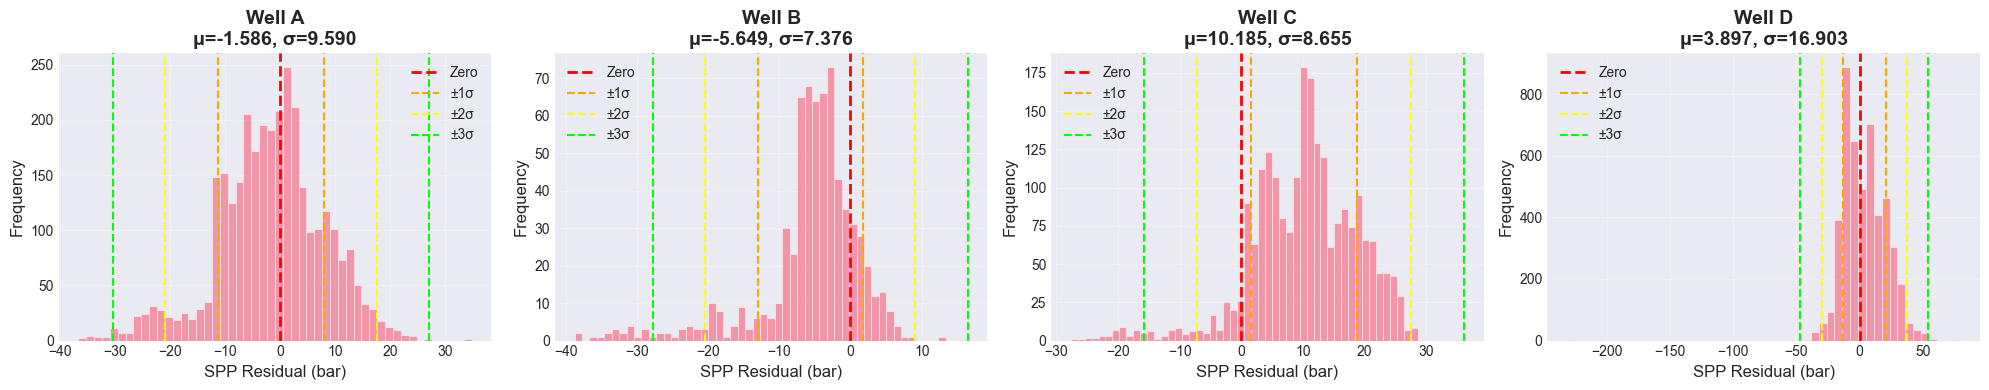


AP residual histograms:
Saved: ..\figures\residuals_n_warnings\residual_histograms_AP.pdf


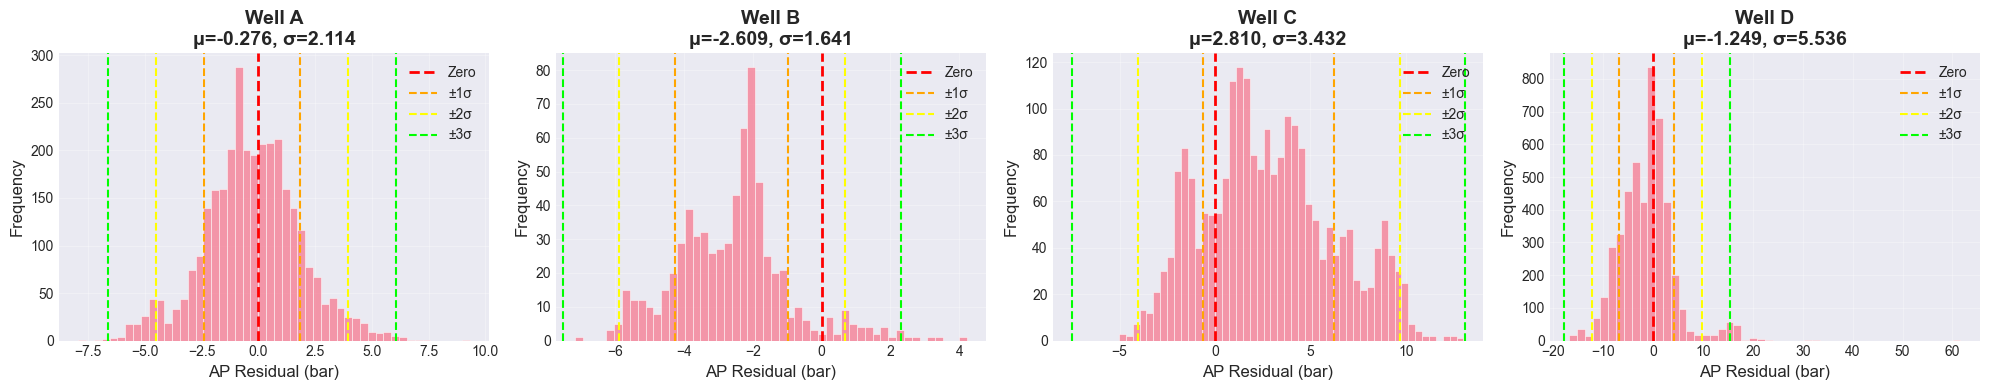

In [449]:
# Histograms of residuals per well (SPP first, then AP)

def plot_residual_histograms(df_in, target):
    cfg = TARGETS[target]
    residual_col = cfg["residual"]
    wells = sorted(df_in['well_id'].unique())
    n_wells = len(wells)
    fig, axes = plt.subplots(1, n_wells, figsize=(5*n_wells, 4))

    if n_wells == 1:
        axes = [axes]

    for idx, well_id in enumerate(wells):
        ax = axes[idx]
        well_mask = df_in['well_id'] == well_id
        well_residuals = df_in[well_mask][residual_col].dropna()
        
        if len(well_residuals) > 0:
            mu = well_residuals.mean()
            sigma = well_residuals.std()
            
            # Use colors that work well with darkgrid background
            ax.hist(well_residuals, bins=50, alpha=0.7, edgecolor='white', linewidth=0.5)
            ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
            ax.axvline(mu - sigma, color='orange', linestyle='--', linewidth=1.5, label='±1σ')
            ax.axvline(mu + sigma, color='orange', linestyle='--', linewidth=1.5)
            ax.axvline(mu - 2*sigma, color='yellow', linestyle='--', linewidth=1.5, label='±2σ')
            ax.axvline(mu + 2*sigma, color='yellow', linestyle='--', linewidth=1.5)
            ax.axvline(mu - 3*sigma, color='lime', linestyle='--', linewidth=1.5, label='±3σ')
            ax.axvline(mu + 3*sigma, color='lime', linestyle='--', linewidth=1.5)
            
            ax.set_xlabel(f'{target} Residual (bar)', fontsize=12)
            ax.set_ylabel('Frequency', fontsize=12)
            ax.set_title(f'Well {well_id}\nμ={mu:.3f}, σ={sigma:.3f}', fontsize=14, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'No data\nfor Well {well_id}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'Well {well_id}', fontsize=14, fontweight='bold')

    fig.tight_layout()
    
    # Save to PDF
    output_dir = Path("../figures/residuals_n_warnings")
    output_dir.mkdir(parents=True, exist_ok=True)
    filename = output_dir / f"residual_histograms_{target}.pdf"
    fig.savefig(filename, format='pdf', bbox_inches='tight')
    print(f"Saved: {filename}")
    
    plt.show()

for target in SUMMARY_TARGET_ORDER:
    print(f"\n{target} residual histograms:")
    plot_residual_histograms(df, target)


In [450]:
# ============================================================================
# COMPARISON PLOTTING: DIRECT VS TREND-BASED WARNINGS
# ============================================================================

def plot_comparison_direct_vs_trend(df_in, target, well_id, depth_start=None, depth_end=None, title_suffix=""):
    """
    Plot comparison between direct residual and trend-based warning approaches.
    
    Creates a 4-panel plot:
    1. SPP vs depth (observed and predicted)
    2. Residuals vs depth (raw, trend, with spikes highlighted)
    3. Warning scores vs depth (direct and trend-based)
    4. Warning flags vs depth (direct and trend-based)
    """
    cfg = TARGETS[target]
    obs_col = cfg["obs"]
    pred_col = cfg["pred"]
    residual_col = cfg["residual"]
    
    # Column names for direct approach
    base_name = residual_col.replace('r_', '')
    z_col = f"z_{base_name}"
    rolling_col = f"rolling_abs_{z_col}"
    warning_col = f"warning_{base_name.replace('_rf', '').replace('_lr', '')}"
    
    # Column names for trend approach
    spike_col = f"is_spike_{residual_col}"
    clean_col = f"{residual_col}_clean"
    trend_col = f"{residual_col}_trend_lowess"
    z_trend_col = f"z_{base_name}_trend"
    rolling_trend_col = f"rolling_abs_{z_trend_col}"
    warning_trend_col = f"warning_{base_name.replace('_rf', '').replace('_lr', '')}_trend"
    
    well_data = df_in[df_in['well_id'] == well_id].copy()
    well_data = well_data.sort_values(by=DEPTH_COL).reset_index(drop=True)
    
    # Filter depth range if specified
    if depth_start is not None and depth_end is not None:
        well_data = well_data[(well_data[DEPTH_COL] >= depth_start) & (well_data[DEPTH_COL] <= depth_end)]
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
    
    # Panel 1: Observed and predicted
    ax = axes[0]
    mask_obs = well_data[obs_col].notna()
    mask_pred = well_data[pred_col].notna()
    
    if mask_obs.sum() > 0:
        ax.plot(well_data.loc[mask_obs, DEPTH_COL], well_data.loc[mask_obs, obs_col], 
               'b-', label=f'Observed {target}', alpha=0.7, linewidth=1.5)
    if mask_pred.sum() > 0:
        ax.plot(well_data.loc[mask_pred, DEPTH_COL], well_data.loc[mask_pred, pred_col], 
               'r--', label=f'Predicted {target} (LR)', alpha=0.7, linewidth=1.5)
    
    # Highlight low-pressure events
    if 'mode' in well_data.columns:
        lpe_mask = well_data['mode'] == 'low_pressure_event'
        if lpe_mask.sum() > 0:
            ax.scatter(well_data.loc[lpe_mask, DEPTH_COL], well_data.loc[lpe_mask, obs_col],
                      c='orange', marker='x', s=50, label='Low Pressure Event', zorder=5)
    
    ax.set_ylabel(f'{target} (bar)')
    ax.set_title(f'Well {well_id} - {target} vs Depth{title_suffix}')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Panel 2: Residuals comparison
    ax = axes[1]
    mask_res = well_data[residual_col].notna()
    if mask_res.sum() > 0:
        ax.plot(well_data.loc[mask_res, DEPTH_COL], well_data.loc[mask_res, residual_col],
               'g-', alpha=0.5, linewidth=0.8, label='Raw Residuals')
    
    # Highlight spikes
    if spike_col in well_data.columns:
        mask_spikes = well_data[spike_col] & well_data[residual_col].notna()
        if mask_spikes.sum() > 0:
            ax.scatter(well_data.loc[mask_spikes, DEPTH_COL],
                      well_data.loc[mask_spikes, residual_col],
                      c='red', s=30, alpha=0.8, marker='x', label='Spikes', zorder=5)
    
    # Plot trend residual
    if trend_col in well_data.columns:
        mask_trend = well_data[trend_col].notna()
        if mask_trend.sum() > 0:
            ax.plot(well_data.loc[mask_trend, DEPTH_COL], well_data.loc[mask_trend, trend_col],
                   'b-', alpha=0.8, linewidth=2, label='Trend Residual (LOWESS)')
    
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_ylabel('Residual (bar)')
    ax.set_title(f'{target} Residuals: Raw vs Trend (with Spikes Highlighted)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Panel 3: Warning scores comparison
    ax = axes[2]
    # Direct approach
    if rolling_col in well_data.columns:
        mask_z = well_data[rolling_col].notna()
        if mask_z.sum() > 0:
            ax.plot(well_data.loc[mask_z, DEPTH_COL], well_data.loc[mask_z, rolling_col],
                   'purple', alpha=0.7, linewidth=1.5, label='Direct (rolling |z|)')
    
    # Trend approach
    if rolling_trend_col in well_data.columns:
        mask_z_trend = well_data[rolling_trend_col].notna()
        if mask_z_trend.sum() > 0:
            ax.plot(well_data.loc[mask_z_trend, DEPTH_COL], well_data.loc[mask_z_trend, rolling_trend_col],
                   'orange', alpha=0.7, linewidth=1.5, label='Trend-based (rolling |z|)')
    
    ax.axhline(THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold (T={THRESHOLD})')
    ax.set_ylabel(f'Rolling |z_{target}|')
    ax.set_title(f'Warning Scores Comparison (window={WINDOW_SIZE})')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Panel 4: Warning flags comparison
    ax = axes[3]
    # Direct warnings
    if warning_col in well_data.columns:
        mask_warn = well_data[warning_col].notna()
        if mask_warn.sum() > 0:
            ax.fill_between(well_data.loc[mask_warn, DEPTH_COL], 0, well_data.loc[mask_warn, warning_col],
                           where=(well_data.loc[mask_warn, warning_col] == 1),
                           color='red', alpha=0.3, label='Warning (Direct)')
            ax.plot(well_data.loc[mask_warn, DEPTH_COL], well_data.loc[mask_warn, warning_col],
                   'r-', linewidth=1.5, alpha=0.7)
    
    # Trend warnings
    if warning_trend_col in well_data.columns:
        mask_warn_trend = well_data[warning_trend_col].notna()
        if mask_warn_trend.sum() > 0:
            ax.fill_between(well_data.loc[mask_warn_trend, DEPTH_COL], 0.1, 
                           0.1 + well_data.loc[mask_warn_trend, warning_trend_col],
                           where=(well_data.loc[mask_warn_trend, warning_trend_col] == 1),
                           color='blue', alpha=0.3, label='Warning (Trend)')
            ax.plot(well_data.loc[mask_warn_trend, DEPTH_COL], 
                   0.1 + well_data.loc[mask_warn_trend, warning_trend_col],
                   'b-', linewidth=1.5, alpha=0.7)
    
    # Shade low-pressure event intervals
    if 'mode' in well_data.columns:
        lpe_mask = well_data['mode'] == 'low_pressure_event'
        if lpe_mask.sum() > 0:
            lpe_depths = well_data.loc[lpe_mask, DEPTH_COL]
            for depth in lpe_depths.unique():
                ax.axvline(depth, color='orange', linestyle=':', linewidth=0.5, alpha=0.3)
    
    ax.set_ylabel('Warning (0/1)')
    ax.set_xlabel(f'Depth ({DEPTH_COL})')
    ax.set_title(f'{target} Warning Flags: Direct vs Trend-Based')
    ax.set_ylim(-0.1, 1.2)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Well {well_id} - {target}: Direct vs Trend-Based Warning Comparison{title_suffix}', 
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

print("Comparison plotting function defined")


Comparison plotting function defined


In [451]:
# ============================================================================
# NEW RESIDUAL CHANNELS: AP USING PREDICTED SPP AND COMMON/DIFFERENCE MODES
# ============================================================================
# This section implements:
# 1. r_AP_lr_predSPP = AP_actual - AP_pred_lr_predSPP (AP residual using predicted SPP)
# 2. Apply same pipeline (spike filter + LOWESS + normalization) to r_SPP_lr and r_AP_lr_predSPP
# 3. Compute z_common and z_diff from normalized z-scores
# 4. Apply warning logic to z_common and z_diff

print("="*80)
print("COMPUTING NEW RESIDUAL CHANNELS: AP WITH PREDICTED SPP")
print("="*80)

# Process each dataset
for ds_key, df_proc in processed_datasets.items():
    print(f"\nProcessing dataset: {ds_key}")
    
    # Step 1: Compute r_AP_lr_predSPP residual
    print("  Step 1: Computing r_AP_lr_predSPP = AP_actual - AP_pred_lr_predSPP")
    df_proc = compute_residuals(df_proc, AP_COL, "AP_pred_lr_predSPP", "r_AP_lr_predSPP")
    
    # Step 2: Apply robust trend pipeline to both r_SPP_lr and r_AP_lr_predSPP
    # This will give us z_spp and z_ap after spike filtering, LOWESS smoothing, and normalization
    
    # For SPP: use existing r_SPP_lr_trend_lowess if available, otherwise compute
    if "r_SPP_lr_trend_lowess" not in df_proc.columns:
        print("  Step 2a: Applying robust trend pipeline to r_SPP_lr")
        # Apply spike detection and cleaning
        for well_id in sorted(df_proc['well_id'].unique()):
            well_mask = df_proc['well_id'] == well_id
            well_data = df_proc[well_mask].copy().sort_values(by=DEPTH_COL).reset_index(drop=True)
            
            if "r_SPP_lr" in well_data.columns:
                residuals = well_data["r_SPP_lr"].values
                spike_mask = detect_residual_spikes(residuals, threshold_sigma=SPIKE_Z_THRESHOLD, 
                                                    local_window=SPIKE_WINDOW)
                well_data["is_spike_r_SPP_lr"] = spike_mask
                well_data["r_SPP_lr_clean"] = clean_residuals(well_data["r_SPP_lr"], spike_mask)
                
                # Apply LOWESS smoothing
                from statsmodels.nonparametric.smoothers_lowess import lowess
                clean_res = well_data["r_SPP_lr_clean"].values
                valid_mask = ~np.isnan(clean_res)
                if valid_mask.sum() > 10:
                    depths = well_data[DEPTH_COL].values
                    smoothed = lowess(clean_res[valid_mask], depths[valid_mask], 
                                     frac=LOWESS_FRAC, it=0, return_sorted=False)
                    trend = np.full(len(well_data), np.nan)
                    trend[valid_mask] = smoothed
                    well_data["r_SPP_lr_trend_lowess"] = trend
                
                df_proc.loc[well_mask, "is_spike_r_SPP_lr"] = well_data["is_spike_r_SPP_lr"].values
                df_proc.loc[well_mask, "r_SPP_lr_clean"] = well_data["r_SPP_lr_clean"].values
                df_proc.loc[well_mask, "r_SPP_lr_trend_lowess"] = well_data["r_SPP_lr_trend_lowess"].values
    
    # For AP with predicted SPP: apply same pipeline
    print("  Step 2b: Applying robust trend pipeline to r_AP_lr_predSPP")
    for well_id in sorted(df_proc['well_id'].unique()):
        well_mask = df_proc['well_id'] == well_id
        well_data = df_proc[well_mask].copy().sort_values(by=DEPTH_COL).reset_index(drop=True)
        
        if "r_AP_lr_predSPP" in well_data.columns:
            residuals = well_data["r_AP_lr_predSPP"].values
            spike_mask = detect_residual_spikes(residuals, threshold_sigma=SPIKE_Z_THRESHOLD, 
                                                local_window=SPIKE_WINDOW)
            well_data["is_spike_r_AP_lr_predSPP"] = spike_mask
            well_data["r_AP_lr_predSPP_clean"] = clean_residuals(well_data["r_AP_lr_predSPP"], spike_mask)
            
            # Apply LOWESS smoothing
            from statsmodels.nonparametric.smoothers_lowess import lowess
            clean_res = well_data["r_AP_lr_predSPP_clean"].values
            valid_mask = ~np.isnan(clean_res)
            if valid_mask.sum() > 10:
                depths = well_data[DEPTH_COL].values
                smoothed = lowess(clean_res[valid_mask], depths[valid_mask], 
                                 frac=LOWESS_FRAC, it=0, return_sorted=False)
                trend = np.full(len(well_data), np.nan)
                trend[valid_mask] = smoothed
                well_data["r_AP_lr_predSPP_trend_lowess"] = trend
            
            df_proc.loc[well_mask, "is_spike_r_AP_lr_predSPP"] = well_data["is_spike_r_AP_lr_predSPP"].values
            df_proc.loc[well_mask, "r_AP_lr_predSPP_clean"] = well_data["r_AP_lr_predSPP_clean"].values
            df_proc.loc[well_mask, "r_AP_lr_predSPP_trend_lowess"] = well_data["r_AP_lr_predSPP_trend_lowess"].values
    
    # Step 3: Compute z-scores for both (normalize trend residuals per well)
    print("  Step 3: Computing z-scores for SPP and AP (predSPP)")
    
    # Compute statistics per well for trend residuals
    for trend_col, z_col in [("r_SPP_lr_trend_lowess", "z_SPP_trend"), 
                             ("r_AP_lr_predSPP_trend_lowess", "z_AP_predSPP_trend")]:
        if trend_col not in df_proc.columns:
            continue
            
        # Compute stats per well (using drill mode if available)
        stats_list = []
        for well_id in sorted(df_proc['well_id'].unique()):
            well_data = df_proc[df_proc['well_id'] == well_id]
            if 'mode' in well_data.columns:
                trend_residuals = well_data[well_data['mode'] == 'drill'][trend_col].dropna()
                if len(trend_residuals) == 0:
                    trend_residuals = well_data[trend_col].dropna()
            else:
                trend_residuals = well_data[trend_col].dropna()
            
            if len(trend_residuals) > 0:
                stats_list.append({
                    'well_id': well_id,
                    f'mu_{trend_col}': trend_residuals.mean(),
                    f'sigma_{trend_col}': trend_residuals.std(),
                })
        
        if stats_list:
            stats_df = pd.DataFrame(stats_list)
            # Merge stats, handling potential duplicate columns
            mu_col = f'mu_{trend_col}'
            sigma_col = f'sigma_{trend_col}'
            
            # Check if columns already exist and handle merge accordingly
            if mu_col in df_proc.columns or sigma_col in df_proc.columns:
                # Drop existing columns if they exist to avoid suffix issues
                cols_to_drop = [c for c in [mu_col, sigma_col] if c in df_proc.columns]
                df_proc = df_proc.drop(columns=cols_to_drop)
            
            df_proc = df_proc.merge(stats_df, on='well_id', how='left')
            
            # Verify columns exist after merge
            if mu_col not in df_proc.columns or sigma_col not in df_proc.columns:
                print(f"    Warning: Stats columns not found after merge for {trend_col}")
                continue
            
            # Compute z-scores
            df_proc[z_col] = np.nan
            
            for well_id in sorted(df_proc['well_id'].unique()):
                well_mask = df_proc['well_id'] == well_id
                well_data = df_proc[well_mask].copy()
                
                # Check that columns exist in well_data
                if trend_col not in well_data.columns or mu_col not in well_data.columns or sigma_col not in well_data.columns:
                    continue
                
                valid_mask = well_data[trend_col].notna() & well_data[mu_col].notna() & well_data[sigma_col].notna() & (well_data[sigma_col] > 0)
                if valid_mask.sum() > 0:
                    df_proc.loc[well_mask & valid_mask, z_col] = (
                        (well_data.loc[valid_mask, trend_col] - well_data.loc[valid_mask, mu_col]) /
                        well_data.loc[valid_mask, sigma_col]
                    ).values
    
    # Step 4: Compute z_common and z_diff
    print("  Step 4: Computing z_common and z_diff")
    df_proc["z_common"] = np.nan
    df_proc["z_diff"] = np.nan
    
    # Only compute where both z-scores are available
    valid_both = df_proc["z_SPP_trend"].notna() & df_proc["z_AP_predSPP_trend"].notna()
    if valid_both.sum() > 0:
        z_spp = df_proc.loc[valid_both, "z_SPP_trend"].values
        z_ap = df_proc.loc[valid_both, "z_AP_predSPP_trend"].values
        
        # Common mode: (z_spp + z_ap) / sqrt(2)
        df_proc.loc[valid_both, "z_common"] = (z_spp + z_ap) / np.sqrt(2)
        
        # Difference mode: (z_spp - z_ap) / sqrt(2)
        df_proc.loc[valid_both, "z_diff"] = (z_spp - z_ap) / np.sqrt(2)
    
    # Step 5: Apply warning logic to z_common and z_diff
    print("  Step 5: Applying warning logic to z_common and z_diff")
    
    for z_col, warn_col, roll_col in [("z_common", "warning_common", "rolling_abs_z_common"),
                                       ("z_diff", "warning_diff", "rolling_abs_z_diff")]:
        if z_col not in df_proc.columns:
            continue
            
        df_proc[roll_col] = np.nan
        df_proc[warn_col] = 0
        
        for well_id in sorted(df_proc['well_id'].unique()):
            well_mask = df_proc['well_id'] == well_id
            well_data = df_proc[well_mask].copy().sort_values(by=DEPTH_COL).reset_index(drop=True)
            
            valid_mask = well_data[z_col].notna()
            if valid_mask.sum() > 0:
                # Rolling mean of absolute z-scores
                abs_z = well_data[z_col].abs()
                rolling_abs_z = abs_z.rolling(window=WINDOW_SIZE, center=True, min_periods=1).mean()
                well_data[roll_col] = rolling_abs_z
                
                # Warning indicator: rolling_abs_z > threshold for at least min_run consecutive points
                # Use threshold 0.8 for z_diff, otherwise use THRESHOLD (1.5)
                threshold_to_use = 0.8 if z_col == "z_diff" else THRESHOLD
                above_threshold = (well_data[roll_col] > threshold_to_use).astype(int)
                
                # Find runs of consecutive points above threshold
                warning = np.zeros(len(well_data), dtype=int)
                run_length = 0
                for i in range(len(well_data)):
                    if above_threshold.iloc[i] == 1:
                        run_length += 1
                        if run_length >= MIN_RUN:
                            # Mark this point and previous min_run-1 points as warning
                            for j in range(max(0, i - MIN_RUN + 1), i + 1):
                                warning[j] = 1
                    else:
                        run_length = 0
                
                well_data[warn_col] = warning
                
                # Restrict warnings to drilling mode only
                if 'mode' in well_data.columns:
                    drill_mask = well_data['mode'] == 'drill'
                    well_data.loc[~drill_mask, warn_col] = 0
                
                # Update main dataframe
                df_proc.loc[well_mask, roll_col] = well_data[roll_col].values
                df_proc.loc[well_mask, warn_col] = well_data[warn_col].values
    
    # Update processed_datasets
    processed_datasets[ds_key] = df_proc
    print(f"  ✓ Completed processing for {ds_key}")

print("\n" + "="*80)
print("NEW RESIDUAL CHANNELS COMPUTED SUCCESSFULLY")
print("="*80)
print("New columns added:")
print("  - r_AP_lr_predSPP: AP residual using predicted SPP")
print("  - z_SPP_trend: Normalized z-score for SPP trend residuals")
print("  - z_AP_predSPP_trend: Normalized z-score for AP (predSPP) trend residuals")
print("  - z_common: Common-mode z-score (z_spp + z_ap) / sqrt(2)")
print("  - z_diff: Difference-mode z-score (z_spp - z_ap) / sqrt(2)")
print("  - rolling_abs_z_common, warning_common: Warning indicators for common mode")
print("  - rolling_abs_z_diff, warning_diff: Warning indicators for difference mode")


COMPUTING NEW RESIDUAL CHANNELS: AP WITH PREDICTED SPP

Processing dataset: actual_features
  Step 1: Computing r_AP_lr_predSPP = AP_actual - AP_pred_lr_predSPP
  Step 2b: Applying robust trend pipeline to r_AP_lr_predSPP
  Step 3: Computing z-scores for SPP and AP (predSPP)
  Step 4: Computing z_common and z_diff
  Step 5: Applying warning logic to z_common and z_diff
  ✓ Completed processing for actual_features

NEW RESIDUAL CHANNELS COMPUTED SUCCESSFULLY
New columns added:
  - r_AP_lr_predSPP: AP residual using predicted SPP
  - z_SPP_trend: Normalized z-score for SPP trend residuals
  - z_AP_predSPP_trend: Normalized z-score for AP (predSPP) trend residuals
  - z_common: Common-mode z-score (z_spp + z_ap) / sqrt(2)
  - z_diff: Difference-mode z-score (z_spp - z_ap) / sqrt(2)
  - rolling_abs_z_common, warning_common: Warning indicators for common mode
  - rolling_abs_z_diff, warning_diff: Warning indicators for difference mode


In [452]:
# ============================================================================
# VISUALIZATIONS: NEW RESIDUAL CHANNELS (PRIORITY A, B, E)
# ============================================================================

# Priority A: Z-scores with warnings over depth
def plot_z_scores_with_warnings(df_in, well_id, threshold=None):
    """
    Plot z_spp, z_ap_pred, z_common, and z_diff vs depth with warning regions.
    
    Parameters:
    -----------
    df_in : pd.DataFrame
        Input dataframe
    well_id : str
        Well identifier
    threshold : float, optional
        Threshold value for horizontal lines (default: THRESHOLD)
    """
    if threshold is None:
        threshold = THRESHOLD
    
    well = df_in[df_in['well_id'] == well_id].copy().sort_values(by=DEPTH_COL).reset_index(drop=True)
    
    if len(well) == 0:
        print(f"No data for well {well_id}")
        return
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    # Plot z-scores
    if "z_SPP_trend" in well.columns:
        ax.plot(well[DEPTH_COL], well["z_SPP_trend"], 'b-', alpha=0.7, linewidth=1.5, label='z_SPP')
    if "z_AP_predSPP_trend" in well.columns:
        ax.plot(well[DEPTH_COL], well["z_AP_predSPP_trend"], 'g-', alpha=0.7, linewidth=1.5, label='z_AP_pred')
    if "z_common" in well.columns:
        ax.plot(well[DEPTH_COL], well["z_common"], 'r-', alpha=0.7, linewidth=1.5, label='z_common')
    if "z_diff" in well.columns:
        ax.plot(well[DEPTH_COL], well["z_diff"], 'm-', alpha=0.7, linewidth=1.5, label='z_diff')
    
    # Add horizontal threshold lines
    ax.axhline(threshold, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Threshold (+{threshold})')
    ax.axhline(-threshold, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Threshold (-{threshold})')
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Add warning regions with different transparency
    if "warning_SPP_trend" in well.columns:
        warn_mask = well["warning_SPP_trend"] == 1
        if warn_mask.sum() > 0:
            ax.fill_between(well.loc[warn_mask, DEPTH_COL], -5, 5, alpha=0.15, color='blue', label='Warning SPP')
    
    if "warning_common" in well.columns:
        warn_mask = well["warning_common"] == 1
        if warn_mask.sum() > 0:
            ax.fill_between(well.loc[warn_mask, DEPTH_COL], -5, 5, alpha=0.20, color='red', label='Warning Common')
    
    if "warning_diff" in well.columns:
        warn_mask = well["warning_diff"] == 1
        if warn_mask.sum() > 0:
            ax.fill_between(well.loc[warn_mask, DEPTH_COL], -5, 5, alpha=0.25, color='magenta', label='Warning Diff')
    
    # Mark low pressure events if available
    if 'mode' in well.columns:
        lpe_mask = well['mode'] == 'low_pressure_event'
        if lpe_mask.sum() > 0:
            ax.scatter(well.loc[lpe_mask, DEPTH_COL], 
                      [threshold + 0.5] * lpe_mask.sum(), 
                      c='orange', marker='x', s=50, zorder=5, label='Low Pressure Event')
    
    ax.set_xlabel(DEPTH_COL)
    ax.set_ylabel('Z-Score')
    ax.set_title(f'Well {well_id}: Z-Scores with Warning Regions')
    ax.legend(loc='best', ncol=2)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-4, 4)  # Adjust as needed
    
    plt.tight_layout()
    plt.show()

# Priority B: Scatter plot z_spp vs z_ap_pred
def plot_z_scatter(df_in, well_id):
    """
    Scatter plot of z_spp vs z_ap_pred with color by depth and markers for warnings.
    
    Parameters:
    -----------
    df_in : pd.DataFrame
        Input dataframe
    well_id : str
        Well identifier
    """
    well = df_in[df_in['well_id'] == well_id].copy()
    
    if len(well) == 0:
        print(f"No data for well {well_id}")
        return
    
    # Filter to valid data
    valid_mask = well["z_SPP_trend"].notna() & well["z_AP_predSPP_trend"].notna()
    if valid_mask.sum() == 0:
        print(f"No valid z-score data for well {well_id}")
        return
    
    well_valid = well[valid_mask].copy()
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # Color by depth or mode
    if 'mode' in well_valid.columns:
        # Use mode for coloring if available
        mode_map = {'drill': 0, 'low_pressure_event': 1, 'invalid': 2}
        mode_colors = well_valid['mode'].map(mode_map).fillna(3)
        scatter = ax.scatter(well_valid["z_SPP_trend"], well_valid["z_AP_predSPP_trend"], 
                           c=mode_colors, cmap='Set1', alpha=0.6, s=20, edgecolors='none')
    else:
        # Color by depth
        scatter = ax.scatter(well_valid["z_SPP_trend"], well_valid["z_AP_predSPP_trend"], 
                           c=well_valid[DEPTH_COL], cmap='viridis', alpha=0.6, s=20, edgecolors='none')
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label(DEPTH_COL)
    
    # Add reference lines first (so they appear in legend)
    z_min = min(well_valid["z_SPP_trend"].min(), well_valid["z_AP_predSPP_trend"].min())
    z_max = max(well_valid["z_SPP_trend"].max(), well_valid["z_AP_predSPP_trend"].max())
    z_range = max(abs(z_min), abs(z_max))
    z_range = max(z_range, 3)  # At least show ±3
    
    ax.plot([-z_range, z_range], [-z_range, z_range], 'k--', alpha=0.5, linewidth=1, label='y=x')
    ax.plot([-z_range, z_range], [z_range, -z_range], 'k:', alpha=0.5, linewidth=1, label='y=-x')
    
    # Mark points with warning_diff
    if "warning_diff" in well_valid.columns:
        warn_mask = well_valid["warning_diff"] == 1
        if warn_mask.sum() > 0:
            ax.scatter(well_valid.loc[warn_mask, "z_SPP_trend"], 
                      well_valid.loc[warn_mask, "z_AP_predSPP_trend"],
                      facecolors='none', edgecolors='red', linewidths=2, s=100, 
                      marker='o', label='Warning Diff', zorder=5)
    
    # Add threshold lines (no label, just visual guides)
    ax.axvline(THRESHOLD, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax.axvline(-THRESHOLD, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax.axhline(THRESHOLD, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax.axhline(-THRESHOLD, color='red', linestyle='--', alpha=0.3, linewidth=1)
    
    ax.set_xlabel('z_SPP')
    ax.set_ylabel('z_AP_pred')
    ax.set_title(f'Well {well_id}: z_SPP vs z_AP_pred')
    
    # Handle legend - combine mode legend with other elements if mode coloring was used
    if 'mode' in well_valid.columns:
        # Get existing legend handles and labels
        handles, labels = ax.get_legend_handles_labels()
        # Add mode legend elements
        from matplotlib.patches import Patch
        mode_legend = [
            Patch(facecolor='blue', alpha=0.6, label='Drill'),
            Patch(facecolor='orange', alpha=0.6, label='Low Pressure Event'),
            Patch(facecolor='gray', alpha=0.6, label='Invalid')
        ]
        ax.legend(handles=mode_legend + handles, loc='best')
    else:
        ax.legend(loc='best')
    
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-z_range, z_range)
    ax.set_ylim(-z_range, z_range)
    
    plt.tight_layout()
    plt.show()

# Priority E: AP residual trends comparison (actual SPP vs predicted SPP)
def plot_ap_residual_comparison(df_in, well_id):
    """
    Compare AP residual trends: with actual SPP vs with predicted SPP.
    
    Parameters:
    -----------
    df_in : pd.DataFrame
        Input dataframe
    well_id : str
        Well identifier
    """
    well = df_in[df_in['well_id'] == well_id].copy().sort_values(by=DEPTH_COL).reset_index(drop=True)
    
    if len(well) == 0:
        print(f"No data for well {well_id}")
        return
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    # Plot AP residual trends
    if "r_AP_lr_trend_lowess" in well.columns:
        valid_mask = well["r_AP_lr_trend_lowess"].notna()
        if valid_mask.sum() > 0:
            ax.plot(well.loc[valid_mask, DEPTH_COL], well.loc[valid_mask, "r_AP_lr_trend_lowess"], 
                   'b-', alpha=0.8, linewidth=2, label='AP residual (actual SPP)')
    
    if "r_AP_lr_predSPP_trend_lowess" in well.columns:
        valid_mask = well["r_AP_lr_predSPP_trend_lowess"].notna()
        if valid_mask.sum() > 0:
            ax.plot(well.loc[valid_mask, DEPTH_COL], well.loc[valid_mask, "r_AP_lr_predSPP_trend_lowess"], 
                   'r-', alpha=0.8, linewidth=2, label='AP residual (predicted SPP)')
    
    # Add zero line
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    # Mark low pressure events if available
    if 'mode' in well.columns:
        lpe_mask = well['mode'] == 'low_pressure_event'
        if lpe_mask.sum() > 0:
            ax.scatter(well.loc[lpe_mask, DEPTH_COL], 
                      [0] * lpe_mask.sum(), 
                      c='orange', marker='x', s=50, zorder=5, label='Low Pressure Event')
    
    ax.set_xlabel(DEPTH_COL)
    ax.set_ylabel('AP Residual Trend (bar)')
    ax.set_title(f'Well {well_id}: AP Residual Trends Comparison (Actual SPP vs Predicted SPP)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Visualization functions defined:")
print("  - plot_z_scores_with_warnings: Z-scores with warning regions (Priority A)")
print("  - plot_z_scatter: Scatter plot z_SPP vs z_AP_pred (Priority B)")
print("  - plot_ap_residual_comparison: AP residual trends comparison (Priority E)")


Visualization functions defined:
  - plot_z_scores_with_warnings: Z-scores with warning regions (Priority A)
  - plot_z_scatter: Scatter plot z_SPP vs z_AP_pred (Priority B)
  - plot_ap_residual_comparison: AP residual trends comparison (Priority E)


### AP, Residual and Warning vs Depth per Well

Depth-series plots showing:
1. Observed and predicted AP vs depth
2. Residual vs depth
3. Rolling absolute z-score vs depth
4. Warning indicator vs depth

Plots are shown for:
- A "clean" drill interval (no obvious low-pressure events)
- An interval that includes low-pressure events or suspicious behavior


In [453]:
# Plot function for depth-series analysis (supports both SPP and AP)
def plot_target_warning_analysis(df_in, target, well_id, depth_start=None, depth_end=None, title_suffix=""):
    """
    Plot observed/predicted, residuals, rolling z-scores, and warnings vs depth for a specific well.
    target: "SPP" or "AP"
    """
    cfg = TARGETS[target]
    obs_col = cfg["obs"]
    pred_col = cfg["pred"]
    residual_col = cfg["residual"]
    sigma_col = cfg["sigma_alias"]

    base_name = residual_col.replace('r_', '')
    z_col = f"z_{base_name}"
    rolling_col = f"rolling_abs_{z_col}"
    warning_col = f"warning_{base_name.replace('_rf', '').replace('_lr', '')}"

    pred_label = "Predicted SPP (LR)" if target == "SPP" else "Predicted AP (LR)"
    obs_label = f"Observed {target}"

    well_data = df_in[df_in['well_id'] == well_id].copy()
    well_data = well_data.sort_values(by=DEPTH_COL).reset_index(drop=True)
    
    # Filter depth range if specified
    if depth_start is not None and depth_end is not None:
        well_data = well_data[(well_data[DEPTH_COL] >= depth_start) & (well_data[DEPTH_COL] <= depth_end)]
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
    
    # 1. Observed and predicted
    ax = axes[0]
    mask_obs = well_data[obs_col].notna()
    mask_pred = well_data[pred_col].notna()
    
    if mask_obs.sum() > 0:
        ax.plot(well_data.loc[mask_obs, DEPTH_COL], well_data.loc[mask_obs, obs_col], 
               'b-', label=obs_label, alpha=0.7, linewidth=1.5)
    if mask_pred.sum() > 0:
        ax.plot(well_data.loc[mask_pred, DEPTH_COL], well_data.loc[mask_pred, pred_col], 
               'r--', label=pred_label, alpha=0.7, linewidth=1.5)
    
    # Highlight low-pressure events
    if 'mode' in well_data.columns:
        lpe_mask = well_data['mode'] == 'low_pressure_event'
        if lpe_mask.sum() > 0:
            ax.scatter(well_data.loc[lpe_mask, DEPTH_COL], well_data.loc[lpe_mask, obs_col],
                      c='orange', marker='x', s=50, label='Low Pressure Event', zorder=5)
    
    # Highlight test split if available
    if 'split' in well_data.columns:
        test_mask = well_data['split'] == 'test'
        if test_mask.sum() > 0:
            test_depths = well_data.loc[test_mask, DEPTH_COL]
            ax.axvspan(test_depths.min(), test_depths.max(), alpha=0.1, color='gray', label='Test split')
    
    ax.set_ylabel(f'{target} (bar)')
    ax.set_title(f'Well {well_id} - {target} vs Depth{title_suffix}')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # 2. Residual
    ax = axes[1]
    mask_res = well_data[residual_col].notna()
    if mask_res.sum() > 0:
        ax.plot(well_data.loc[mask_res, DEPTH_COL], well_data.loc[mask_res, residual_col],
               'g-', alpha=0.7, linewidth=1, label=f'{target} residual')
        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        
        # Add ±2σ and ±3σ lines
        if sigma_col in well_data.columns:
            sigma = well_data[sigma_col].iloc[0]
            if pd.notna(sigma) and sigma > 0:
                ax.axhline(2*sigma, color='orange', linestyle=':', linewidth=1, label='±2σ')
                ax.axhline(-2*sigma, color='orange', linestyle=':', linewidth=1)
                ax.axhline(3*sigma, color='red', linestyle=':', linewidth=1, label='±3σ')
                ax.axhline(-3*sigma, color='red', linestyle=':', linewidth=1)
    
    # For AP: Add comparison of residual trends and residuals (actual SPP vs predicted SPP)
    if target == "AP":
        # AP residual (raw) with actual SPP
        if "r_AP_lr" in well_data.columns:
            mask_ap_act_raw = well_data["r_AP_lr"].notna()
            if mask_ap_act_raw.sum() > 0:
                ax.plot(well_data.loc[mask_ap_act_raw, DEPTH_COL], well_data.loc[mask_ap_act_raw, "r_AP_lr"],
                       'b-', alpha=0.5, linewidth=1, linestyle='-', label='AP residual (actual SPP)')
        
        # AP residual (raw) with predicted SPP
        if "r_AP_lr_predSPP" in well_data.columns:
            mask_ap_pred_raw = well_data["r_AP_lr_predSPP"].notna()
            if mask_ap_pred_raw.sum() > 0:
                ax.plot(well_data.loc[mask_ap_pred_raw, DEPTH_COL], well_data.loc[mask_ap_pred_raw, "r_AP_lr_predSPP"],
                       'r-', alpha=0.5, linewidth=1, linestyle='--', label='AP residual (predicted SPP)')
        
        # AP residual trend with actual SPP
        if "r_AP_lr_trend_lowess" in well_data.columns:
            mask_ap_act = well_data["r_AP_lr_trend_lowess"].notna()
            if mask_ap_act.sum() > 0:
                ax.plot(well_data.loc[mask_ap_act, DEPTH_COL], well_data.loc[mask_ap_act, "r_AP_lr_trend_lowess"],
                       'b-', alpha=0.8, linewidth=2, linestyle='-', label='AP residual trend (actual SPP)')
        
        # AP residual trend with predicted SPP
        if "r_AP_lr_predSPP_trend_lowess" in well_data.columns:
            mask_ap_pred = well_data["r_AP_lr_predSPP_trend_lowess"].notna()
            if mask_ap_pred.sum() > 0:
                ax.plot(well_data.loc[mask_ap_pred, DEPTH_COL], well_data.loc[mask_ap_pred, "r_AP_lr_predSPP_trend_lowess"],
                       'r-', alpha=0.8, linewidth=2, linestyle='--', label='AP residual trend (predicted SPP)')
    
    # Add z_common and z_diff trend residuals if available
    if "z_common" in well_data.columns:
        # Convert z_common back to residual scale (approximate, using target's sigma)
        mask_common = well_data["z_common"].notna()
        if mask_common.sum() > 0 and sigma_col in well_data.columns:
            sigma = well_data[sigma_col].iloc[0]
            if pd.notna(sigma) and sigma > 0:
                # Approximate residual scale: z * sigma
                common_residual_approx = well_data.loc[mask_common, "z_common"] * sigma
                ax.plot(well_data.loc[mask_common, DEPTH_COL], common_residual_approx,
                       'orange', alpha=0.6, linewidth=1.5, linestyle=':', label='z_common (approx residual scale)')
    
    if "z_diff" in well_data.columns:
        mask_diff = well_data["z_diff"].notna()
        if mask_diff.sum() > 0 and sigma_col in well_data.columns:
            sigma = well_data[sigma_col].iloc[0]
            if pd.notna(sigma) and sigma > 0:
                # Approximate residual scale: z * sigma
                diff_residual_approx = well_data.loc[mask_diff, "z_diff"] * sigma
                ax.plot(well_data.loc[mask_diff, DEPTH_COL], diff_residual_approx,
                       'm-', alpha=0.6, linewidth=1.5, linestyle=':', label='z_diff (approx residual scale)')
    
    ax.set_ylabel('Residual (bar)')
    ax.set_title(f'{target} Residual vs Depth')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # 3. Rolling absolute z-score
    ax = axes[2]
    mask_z = well_data[rolling_col].notna() if rolling_col in well_data.columns else []
    if len(mask_z) > 0 and np.nansum(mask_z) > 0:
        ax.plot(well_data.loc[mask_z, DEPTH_COL], well_data.loc[mask_z, rolling_col],
               'purple', alpha=0.7, linewidth=1.5, label=f'Rolling |z_{target}|')
        ax.axhline(THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold (T={THRESHOLD})')
        ax.axhline(-THRESHOLD, color='red', linestyle='--', linewidth=2, alpha=0.5)
    
    # For AP: Add comparison of z-scores (actual SPP vs predicted SPP)
    if target == "AP":
        # AP z-score with actual SPP (if available) - show both signed and absolute
        if "z_AP_lr_trend" in well_data.columns:
            mask_ap_act_z = well_data["z_AP_lr_trend"].notna()
            if mask_ap_act_z.sum() > 0:
                # Signed z-score
                ax.plot(well_data.loc[mask_ap_act_z, DEPTH_COL], well_data.loc[mask_ap_act_z, "z_AP_lr_trend"],
                       'b-', alpha=0.6, linewidth=1.5, linestyle='-', label='z_AP (actual SPP)')
                # Absolute z-score
                ax.plot(well_data.loc[mask_ap_act_z, DEPTH_COL], well_data.loc[mask_ap_act_z, "z_AP_lr_trend"].abs(),
                       'b-', alpha=0.8, linewidth=2, linestyle='-', label='|z_AP| (actual SPP)')
        
        # AP z-score with predicted SPP - show both signed and absolute
        if "z_AP_predSPP_trend" in well_data.columns:
            mask_ap_pred_z = well_data["z_AP_predSPP_trend"].notna()
            if mask_ap_pred_z.sum() > 0:
                # Signed z-score
                ax.plot(well_data.loc[mask_ap_pred_z, DEPTH_COL], well_data.loc[mask_ap_pred_z, "z_AP_predSPP_trend"],
                       'r-', alpha=0.6, linewidth=1.5, linestyle='--', label='z_AP_pred (predicted SPP)')
                # Absolute z-score
                ax.plot(well_data.loc[mask_ap_pred_z, DEPTH_COL], well_data.loc[mask_ap_pred_z, "z_AP_predSPP_trend"].abs(),
                       'r-', alpha=0.8, linewidth=2, linestyle='--', label='|z_AP_pred| (predicted SPP)')
    
    # Add z_common - show both signed and absolute
    if "z_common" in well_data.columns:
        mask_common = well_data["z_common"].notna()
        if mask_common.sum() > 0:
            # Signed z-score
            ax.plot(well_data.loc[mask_common, DEPTH_COL], well_data.loc[mask_common, "z_common"],
                   'orange', alpha=0.6, linewidth=1.5, linestyle=':', label='z_common')
            # Absolute z-score
            ax.plot(well_data.loc[mask_common, DEPTH_COL], well_data.loc[mask_common, "z_common"].abs(),
                   'orange', alpha=0.7, linewidth=1.5, linestyle=':', label='|z_common|')
    
    # Add z_diff - show both signed and absolute
    if "z_diff" in well_data.columns:
        mask_diff = well_data["z_diff"].notna()
        if mask_diff.sum() > 0:
            # Signed z-score
            ax.plot(well_data.loc[mask_diff, DEPTH_COL], well_data.loc[mask_diff, "z_diff"],
                   'm-', alpha=0.6, linewidth=1.5, linestyle=':', label='z_diff')
            # Absolute z-score
            ax.plot(well_data.loc[mask_diff, DEPTH_COL], well_data.loc[mask_diff, "z_diff"].abs(),
                   'm-', alpha=0.7, linewidth=1.5, linestyle=':', label='|z_diff|')
    
    # Add rolling versions if available
    if "rolling_abs_z_common" in well_data.columns:
        mask_roll_common = well_data["rolling_abs_z_common"].notna()
        if mask_roll_common.sum() > 0:
            ax.plot(well_data.loc[mask_roll_common, DEPTH_COL], well_data.loc[mask_roll_common, "rolling_abs_z_common"],
                   'orange', alpha=0.5, linewidth=1, linestyle='-.', label='Rolling |z_common|')
    
    if "rolling_abs_z_diff" in well_data.columns:
        mask_roll_diff = well_data["rolling_abs_z_diff"].notna()
        if mask_roll_diff.sum() > 0:
            ax.plot(well_data.loc[mask_roll_diff, DEPTH_COL], well_data.loc[mask_roll_diff, "rolling_abs_z_diff"],
                   'm', alpha=0.5, linewidth=1, linestyle='-.', label='Rolling |z_diff|')
    
    # Add zero line for reference
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    
    ax.set_ylabel(f'Rolling |z_{target}| / |z_common| / |z_diff|')
    ax.set_title(f'Rolling Absolute Z-Score (window={WINDOW_SIZE})')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # 4. Warning indicator
    ax = axes[3]
    if warning_col in well_data.columns:
        mask_warn = well_data[warning_col].notna()
    else:
        mask_warn = []
    if len(mask_warn) > 0 and np.nansum(mask_warn) > 0:
        ax.fill_between(well_data.loc[mask_warn, DEPTH_COL], 0, well_data.loc[mask_warn, warning_col],
                       where=(well_data.loc[mask_warn, warning_col] == 1),
                       color='red', alpha=0.5, label='Warning')
        ax.plot(well_data.loc[mask_warn, DEPTH_COL], well_data.loc[mask_warn, warning_col],
               'r-', linewidth=2)
    
    ax.set_ylabel('Warning (0/1)')
    ax.set_xlabel(f'Depth ({DEPTH_COL})')
    ax.set_title(f'{target} Warning Indicator')
    ax.set_ylim(-0.1, 1.1)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [466]:
# ============================================================================
# COMPREHENSIVE PLOT: AP ANALYSIS
# ============================================================================

def plot_comprehensive_analysis(df_in, well_id, depth_start=None, depth_end=None):
    """
    Create comprehensive figure for AP analysis.
    Shows observed vs predicted, residuals, z-scores, and absolute z-scores.
    
    Parameters:
    -----------
    df_in : pd.DataFrame
        Input dataframe
    well_id : str
        Well identifier
    depth_start : float, optional
        Start depth for filtering
    depth_end : float, optional
        End depth for filtering
    """
    well_data = df_in[df_in['well_id'] == well_id].copy()
    well_data = well_data.sort_values(by=DEPTH_COL).reset_index(drop=True)
    
    # Filter depth range if specified
    if depth_start is not None and depth_end is not None:
        well_data = well_data[(well_data[DEPTH_COL] >= depth_start) & (well_data[DEPTH_COL] <= depth_end)]
    
    if len(well_data) == 0:
        print(f"No data for well {well_id}")
        return
    
    # ========================================================================
    # AP ANALYSIS
    # ========================================================================
    fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
    fig.suptitle(f'Well {well_id}: AP Analysis', fontsize=14, fontweight='bold')
    
    # Plot 1: Residuals (z_common and z_diff as strong, others as weak dotted)
    ax = axes[0]
    # Convert z_common and z_diff to residual scale (strong lines)
    if "z_common" in well_data.columns and "sigma_AP_well" in well_data.columns:
        mask_common = well_data["z_common"].notna()
        if mask_common.sum() > 0:
            sigma = well_data["sigma_AP_well"].iloc[0] if pd.notna(well_data["sigma_AP_well"].iloc[0]) else 1.0
            if sigma > 0:
                common_residual_approx = well_data.loc[mask_common, "z_common"] * sigma
                ax.plot(well_data.loc[mask_common, DEPTH_COL], common_residual_approx,
                       'orange', alpha=0.9, linewidth=2, label='z_common (residual scale)')

    if "z_diff" in well_data.columns and "sigma_AP_well" in well_data.columns:  
        mask_diff = well_data["z_diff"].notna()
        if mask_diff.sum() > 0:
            sigma = well_data["sigma_AP_well"].iloc[0] if pd.notna(well_data["sigma_AP_well"].iloc[0]) else 1.0
            if sigma > 0:
                diff_residual_approx = well_data.loc[mask_diff, "z_diff"] * sigma
                ax.plot(well_data.loc[mask_diff, DEPTH_COL], diff_residual_approx,
                       'm-', alpha=0.9, linewidth=2, label='z_diff (residual scale)')
    
    # r_AP and r_SPP trends as weak dotted lines
    if "r_AP_lr_trend_lowess" in well_data.columns:
        mask_ap_trend = well_data["r_AP_lr_trend_lowess"].notna()
        if mask_ap_trend.sum() > 0:
            ax.plot(well_data.loc[mask_ap_trend, DEPTH_COL], well_data.loc[mask_ap_trend, "r_AP_lr_trend_lowess"],
                   'g-', alpha=0.4, linewidth=1, linestyle=':', label='r_AP trend (actual SPP)')

    if "r_AP_lr_predSPP_trend_lowess" in well_data.columns:
        mask_ap_pred_trend = well_data["r_AP_lr_predSPP_trend_lowess"].notna()  
        if mask_ap_pred_trend.sum() > 0:
            ax.plot(well_data.loc[mask_ap_pred_trend, DEPTH_COL], well_data.loc[mask_ap_pred_trend, "r_AP_lr_predSPP_trend_lowess"],
                   'r-', alpha=0.4, linewidth=1, linestyle=':', label='r_AP trend (predicted SPP)')
    
    if "r_SPP_lr_trend_lowess" in well_data.columns:
        mask_spp_trend = well_data["r_SPP_lr_trend_lowess"].notna()
        if mask_spp_trend.sum() > 0:
            ax.plot(well_data.loc[mask_spp_trend, DEPTH_COL], well_data.loc[mask_spp_trend, "r_SPP_lr_trend_lowess"],
                   'b-', alpha=0.4, linewidth=1, linestyle=':', label='r_SPP trend')
    
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_ylabel('Residual (bar)')
    ax.set_title('Residuals')
    ax.legend(loc='best', ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Absolute Z-Scores (z_common and z_diff as strong, others as weak dotted)
    ax = axes[1]
    # z_common and z_diff as strong lines
    if "z_common" in well_data.columns:
        mask_common = well_data["z_common"].notna()
        if mask_common.sum() > 0:
            ax.plot(well_data.loc[mask_common, DEPTH_COL], well_data.loc[mask_common, "z_common"].abs(),
                   'orange', alpha=0.9, linewidth=2, label='|z_common|')
    
    if "z_diff" in well_data.columns:
        mask_diff = well_data["z_diff"].notna()
        if mask_diff.sum() > 0:
            ax.plot(well_data.loc[mask_diff, DEPTH_COL], well_data.loc[mask_diff, "z_diff"].abs(),
                   'm-', alpha=0.9, linewidth=2, label='|z_diff|')
    
    # z_AP as weak dotted lines
    if "z_AP_lr_trend" in well_data.columns:
        mask_ap_z = well_data["z_AP_lr_trend"].notna()
        if mask_ap_z.sum() > 0:
            ax.plot(well_data.loc[mask_ap_z, DEPTH_COL], well_data.loc[mask_ap_z, "z_AP_lr_trend"].abs(),
                   'g--', alpha=0.4, linewidth=1, linestyle=':', label='|z_AP| (actual SPP)')
    
    if "z_AP_predSPP_trend" in well_data.columns:
        mask_ap_pred_z = well_data["z_AP_predSPP_trend"].notna()
        if mask_ap_pred_z.sum() > 0:
            ax.plot(well_data.loc[mask_ap_pred_z, DEPTH_COL], well_data.loc[mask_ap_pred_z, "z_AP_predSPP_trend"].abs(),
                   'r--', alpha=0.4, linewidth=1, linestyle=':', label='|z_AP| (predicted SPP)')
    
    # Threshold lines: THRESHOLD for z_common, 0.8 for z_diff
    ax.axhline(THRESHOLD, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Threshold ({THRESHOLD})')
    ax.axhline(0.8, color='purple', linestyle='--', linewidth=2, alpha=0.7, label='Threshold z_diff (0.8)')
    ax.set_ylabel('Absolute Z-Score')
    ax.set_title('Absolute Z-Scores')
    ax.legend(loc='best', ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Warning Flags (ONLY from z_diff and z_common)
    ax = axes[2]
    if "warning_common" in well_data.columns:
        ax.fill_between(well_data[DEPTH_COL], 0, well_data["warning_common"], 
                       where=well_data["warning_common"]==1, 
                       color='orange', alpha=0.25, label='Warning (z_common)')
    
    if "warning_diff" in well_data.columns:
        ax.fill_between(well_data[DEPTH_COL], 0.1, 0.1 + well_data["warning_diff"], 
                       where=well_data["warning_diff"]==1, 
                       color='magenta', alpha=0.25, label='Warning (z_diff)')
    
    ax.set_ylabel('Warning (0/1)')
    ax.set_xlabel(DEPTH_COL)
    ax.set_ylim(-0.1, 1.3)
    ax.set_title('Warning Flags (z_common and z_diff)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    fig.tight_layout()
    
    # Save to PDF
    output_dir = Path("../figures/residuals_n_warnings")
    output_dir.mkdir(parents=True, exist_ok=True)
    filename = output_dir / f"z_diff_common_{well_id}.pdf"
    fig.savefig(filename, format='pdf', bbox_inches='tight')
    print(f"Saved: {filename}")
    
    plt.show()

print("Comprehensive analysis plot function defined: plot_comprehensive_analysis()")
print("  - Creates one figure for AP analysis")
print("  - Figure has 3 panels: Residuals, Absolute Z-Scores, Warning Flags")
print("  - Saves plots as PDFs to ../figures/residuals_n_warnings/")


Comprehensive analysis plot function defined: plot_comprehensive_analysis()
  - Creates one figure for AP analysis
  - Figure has 3 panels: Residuals, Absolute Z-Scores, Warning Flags
  - Saves plots as PDFs to ../figures/residuals_n_warnings/


In [470]:
# ============================================================================
# AP ANALYSIS PLOT: Observed/Predicted, Residuals, Rolling Z-Scores, Warnings
# ============================================================================

def plot_ap_analysis_with_warnings(df_in, well_id, depth_start=None, depth_end=None, title_suffix=""):
    """
    Create comprehensive AP analysis figure with 4 panels:
    1. AP Observed vs Predicted (actual SPP and predicted SPP)
    2. AP Residuals (actual SPP and predicted SPP, with trends)
    3. AP Absolute Z-Scores (rolling, actual SPP and predicted SPP)
    4. AP Warning Flags (actual SPP and predicted SPP)
    
    Parameters:
    -----------
    df_in : pd.DataFrame
        Input dataframe
    well_id : str
        Well identifier
    depth_start : float, optional
        Start depth for filtering
    depth_end : float, optional
        End depth for filtering
    title_suffix : str, optional
        Additional text for plot title
    """
    well_data = df_in[df_in['well_id'] == well_id].copy()
    well_data = well_data.sort_values(by=DEPTH_COL).reset_index(drop=True)
    
    # Filter depth range if specified
    if depth_start is not None and depth_end is not None:
        well_data = well_data[(well_data[DEPTH_COL] >= depth_start) & (well_data[DEPTH_COL] <= depth_end)]
    
    if len(well_data) == 0:
        print(f"No data for well {well_id}")
        return
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)
    fig.suptitle(f'Well {well_id}: AP Analysis{title_suffix}', fontsize=14, fontweight='bold')
    
    # Plot 1: AP Observed vs Predicted
    ax = axes[0]
    if AP_COL in well_data.columns:
        mask_ap = well_data[AP_COL].notna()
        if mask_ap.sum() > 0:
            ax.plot(well_data.loc[mask_ap, DEPTH_COL], well_data.loc[mask_ap, AP_COL],
                   'g-', alpha=0.8, linewidth=2, label='AP observed')
    
    if "AP_pred_lr" in well_data.columns:
        mask_ap_pred = well_data["AP_pred_lr"].notna()
        if mask_ap_pred.sum() > 0:
            ax.plot(well_data.loc[mask_ap_pred, DEPTH_COL], well_data.loc[mask_ap_pred, "AP_pred_lr"],
                   'g--', alpha=0.7, linewidth=1.5, label='AP predicted (actual SPP)')
    
    if "AP_pred_lr_predSPP" in well_data.columns:
        mask_ap_pred_spp = well_data["AP_pred_lr_predSPP"].notna()
        if mask_ap_pred_spp.sum() > 0:
            ax.plot(well_data.loc[mask_ap_pred_spp, DEPTH_COL], well_data.loc[mask_ap_pred_spp, "AP_pred_lr_predSPP"],
                   'r--', alpha=0.7, linewidth=1.5, label='AP predicted (predicted SPP)')
    
    ax.set_ylabel('AP (bar)', fontsize=12)
    ax.set_title('AP: Observed vs Predicted', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: AP Residuals (without z_common and z_diff)
    ax = axes[1]
    if "r_AP_lr" in well_data.columns:
        mask_ap_res = well_data["r_AP_lr"].notna()
        if mask_ap_res.sum() > 0:
            ax.plot(well_data.loc[mask_ap_res, DEPTH_COL], well_data.loc[mask_ap_res, "r_AP_lr"],
                   'g-', alpha=0.6, linewidth=1, label='r_AP (actual SPP)')
    
    if "r_AP_lr_predSPP" in well_data.columns:
        mask_ap_pred_res = well_data["r_AP_lr_predSPP"].notna()
        if mask_ap_pred_res.sum() > 0:
            ax.plot(well_data.loc[mask_ap_pred_res, DEPTH_COL], well_data.loc[mask_ap_pred_res, "r_AP_lr_predSPP"],
                   'r-', alpha=0.6, linewidth=1, label='r_AP (predicted SPP)')
    
    if "r_AP_lr_trend_lowess" in well_data.columns:
        mask_ap_trend = well_data["r_AP_lr_trend_lowess"].notna()
        if mask_ap_trend.sum() > 0:
            ax.plot(well_data.loc[mask_ap_trend, DEPTH_COL], well_data.loc[mask_ap_trend, "r_AP_lr_trend_lowess"],
                   'g-', alpha=0.9, linewidth=2, label='r_AP trend (actual SPP)')
    
    if "r_AP_lr_predSPP_trend_lowess" in well_data.columns:
        mask_ap_pred_trend = well_data["r_AP_lr_predSPP_trend_lowess"].notna()
        if mask_ap_pred_trend.sum() > 0:
            ax.plot(well_data.loc[mask_ap_pred_trend, DEPTH_COL], well_data.loc[mask_ap_pred_trend, "r_AP_lr_predSPP_trend_lowess"],
                   'r-', alpha=0.9, linewidth=2, label='r_AP trend (predicted SPP)')
    
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_ylabel('Residual (bar)', fontsize=12)
    ax.set_title('AP Residuals', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: AP Absolute Z-Scores (rolling, actual SPP and predicted SPP)
    ax = axes[2]
    if "rolling_abs_z_AP_lr_trend" in well_data.columns:
        mask_ap_roll = well_data["rolling_abs_z_AP_lr_trend"].notna()
        if mask_ap_roll.sum() > 0:
            ax.plot(well_data.loc[mask_ap_roll, DEPTH_COL], well_data.loc[mask_ap_roll, "rolling_abs_z_AP_lr_trend"],
                   'g-', alpha=0.7, linewidth=1.5, label='|z_AP trend| (actual SPP)')
    
    if "rolling_abs_z_AP_predSPP_trend" in well_data.columns:
        mask_ap_pred_roll = well_data["rolling_abs_z_AP_predSPP_trend"].notna()
        if mask_ap_pred_roll.sum() > 0:
            ax.plot(well_data.loc[mask_ap_pred_roll, DEPTH_COL], well_data.loc[mask_ap_pred_roll, "rolling_abs_z_AP_predSPP_trend"],
                   'r-', alpha=0.7, linewidth=1.5, label='|z_AP trend| (predicted SPP)')
    
    ax.axhline(THRESHOLD, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Threshold ({THRESHOLD})')
    ax.set_ylabel('Absolute Z-Score', fontsize=12)
    ax.set_title('AP Absolute Z-Scores (Trend)', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Plot 4: AP Warning Flags (based on trend, actual SPP and predicted SPP)
    ax = axes[3]
    if "warning_AP_trend" in well_data.columns:
        ax.fill_between(well_data[DEPTH_COL], 0, well_data["warning_AP_trend"], 
                       where=well_data["warning_AP_trend"]==1, 
                       color='green', alpha=0.25, label='Warning AP trend (actual SPP)')
    
    if "warning_AP_predSPP_trend" in well_data.columns:
        ax.fill_between(well_data[DEPTH_COL], 0.1, 0.1 + well_data["warning_AP_predSPP_trend"], 
                       where=well_data["warning_AP_predSPP_trend"]==1, 
                       color='red', alpha=0.25, label='Warning AP trend (predicted SPP)')
    
    ax.set_ylabel('Warning (0/1)', fontsize=12)
    ax.set_xlabel(f'Depth ({DEPTH_COL})', fontsize=12)
    ax.set_ylim(-0.1, 1.3)
    ax.set_title('AP Warning Flags (Trend-based)', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    fig.tight_layout()
    
    # Save to PDF
    output_dir = Path("../figures/residuals_n_warnings")
    output_dir.mkdir(parents=True, exist_ok=True)
    filename = output_dir / f"AP_warning_pipeline_{well_id}.pdf"
    fig.savefig(filename, format='pdf', bbox_inches='tight')
    print(f"Saved: {filename}")
    
    return fig

print("AP analysis plot function defined: plot_ap_analysis_with_warnings()")
print("  - Creates one figure for AP analysis with 4 panels")
print("  - Panels: Observed vs Predicted, Residuals, Z-Scores, Trend-based Warning Flags")
print("  - Saves plots as PDFs to ../figures/residuals_n_warnings/")

AP analysis plot function defined: plot_ap_analysis_with_warnings()
  - Creates one figure for AP analysis with 4 panels
  - Panels: Observed vs Predicted, Residuals, Z-Scores, Trend-based Warning Flags
  - Saves plots as PDFs to ../figures/residuals_n_warnings/


Using dataset: actual_features

Generating AP analysis plot for Well A
Saved: ..\figures\residuals_n_warnings\AP_warning_pipeline_A.pdf


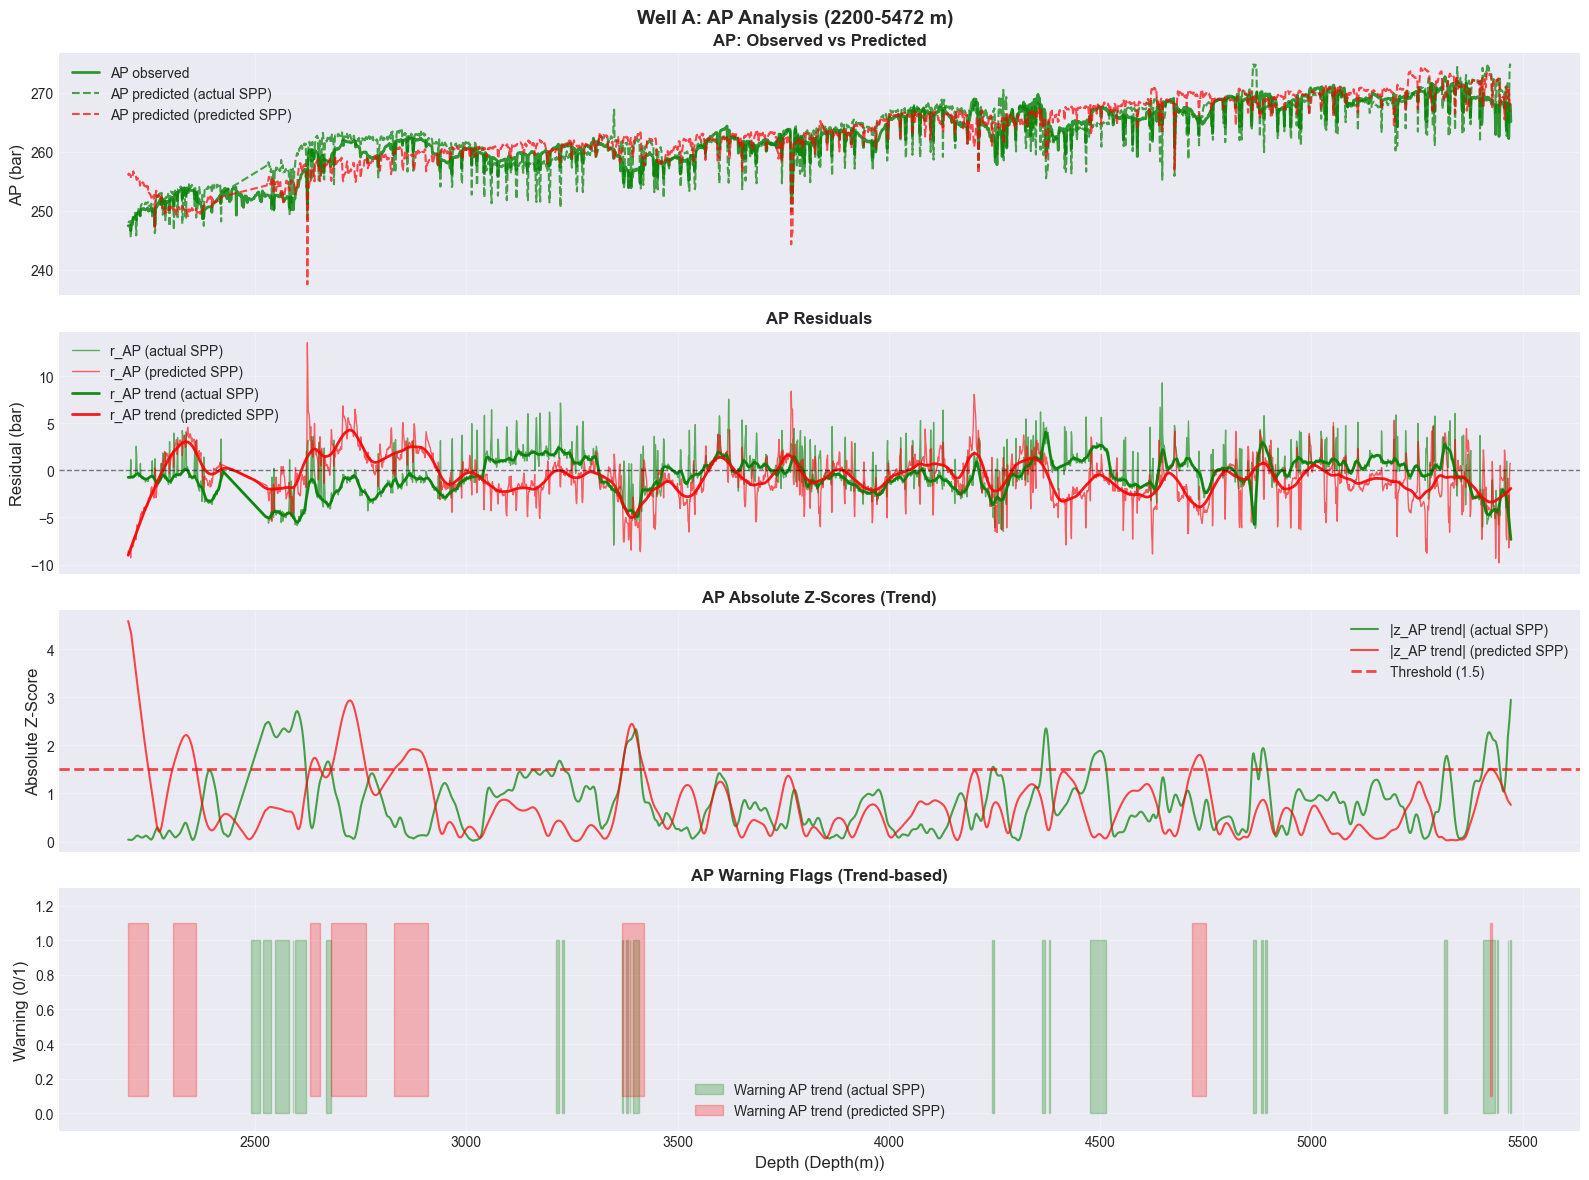


Generating AP analysis plot for Well B
Saved: ..\figures\residuals_n_warnings\AP_warning_pipeline_B.pdf


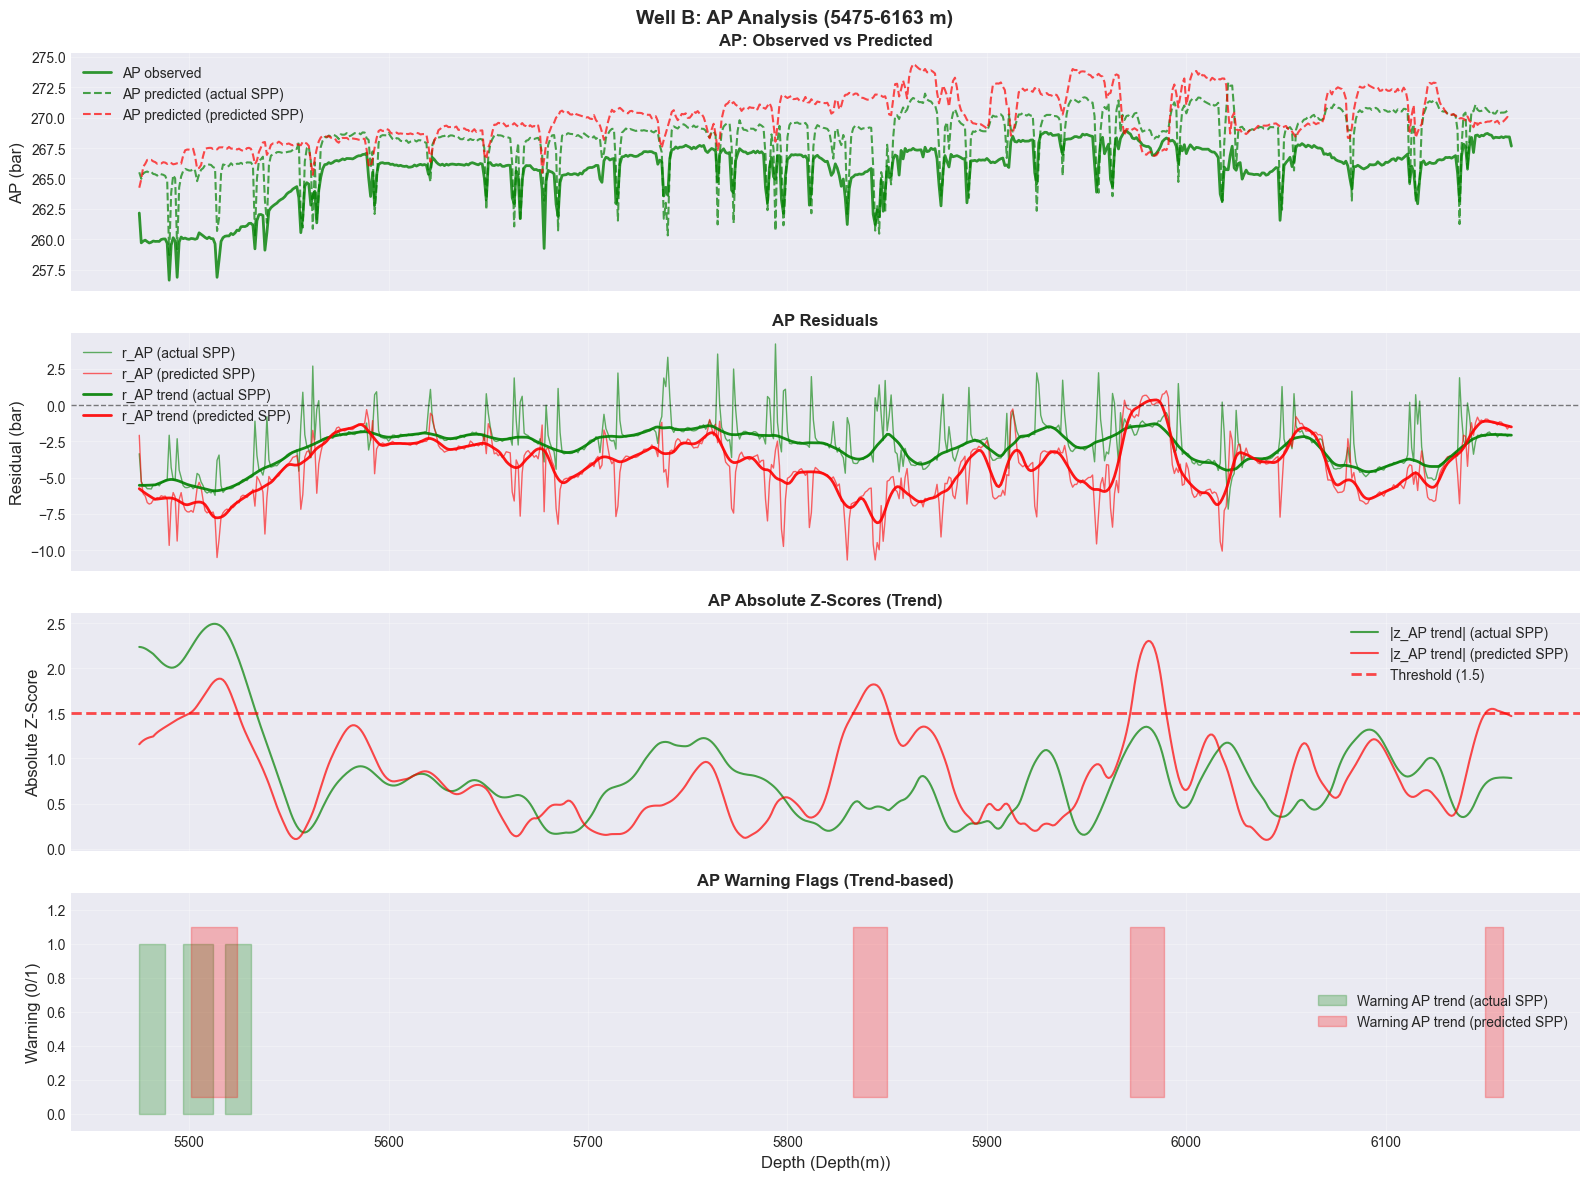


Generating AP analysis plot for Well C
Saved: ..\figures\residuals_n_warnings\AP_warning_pipeline_C.pdf


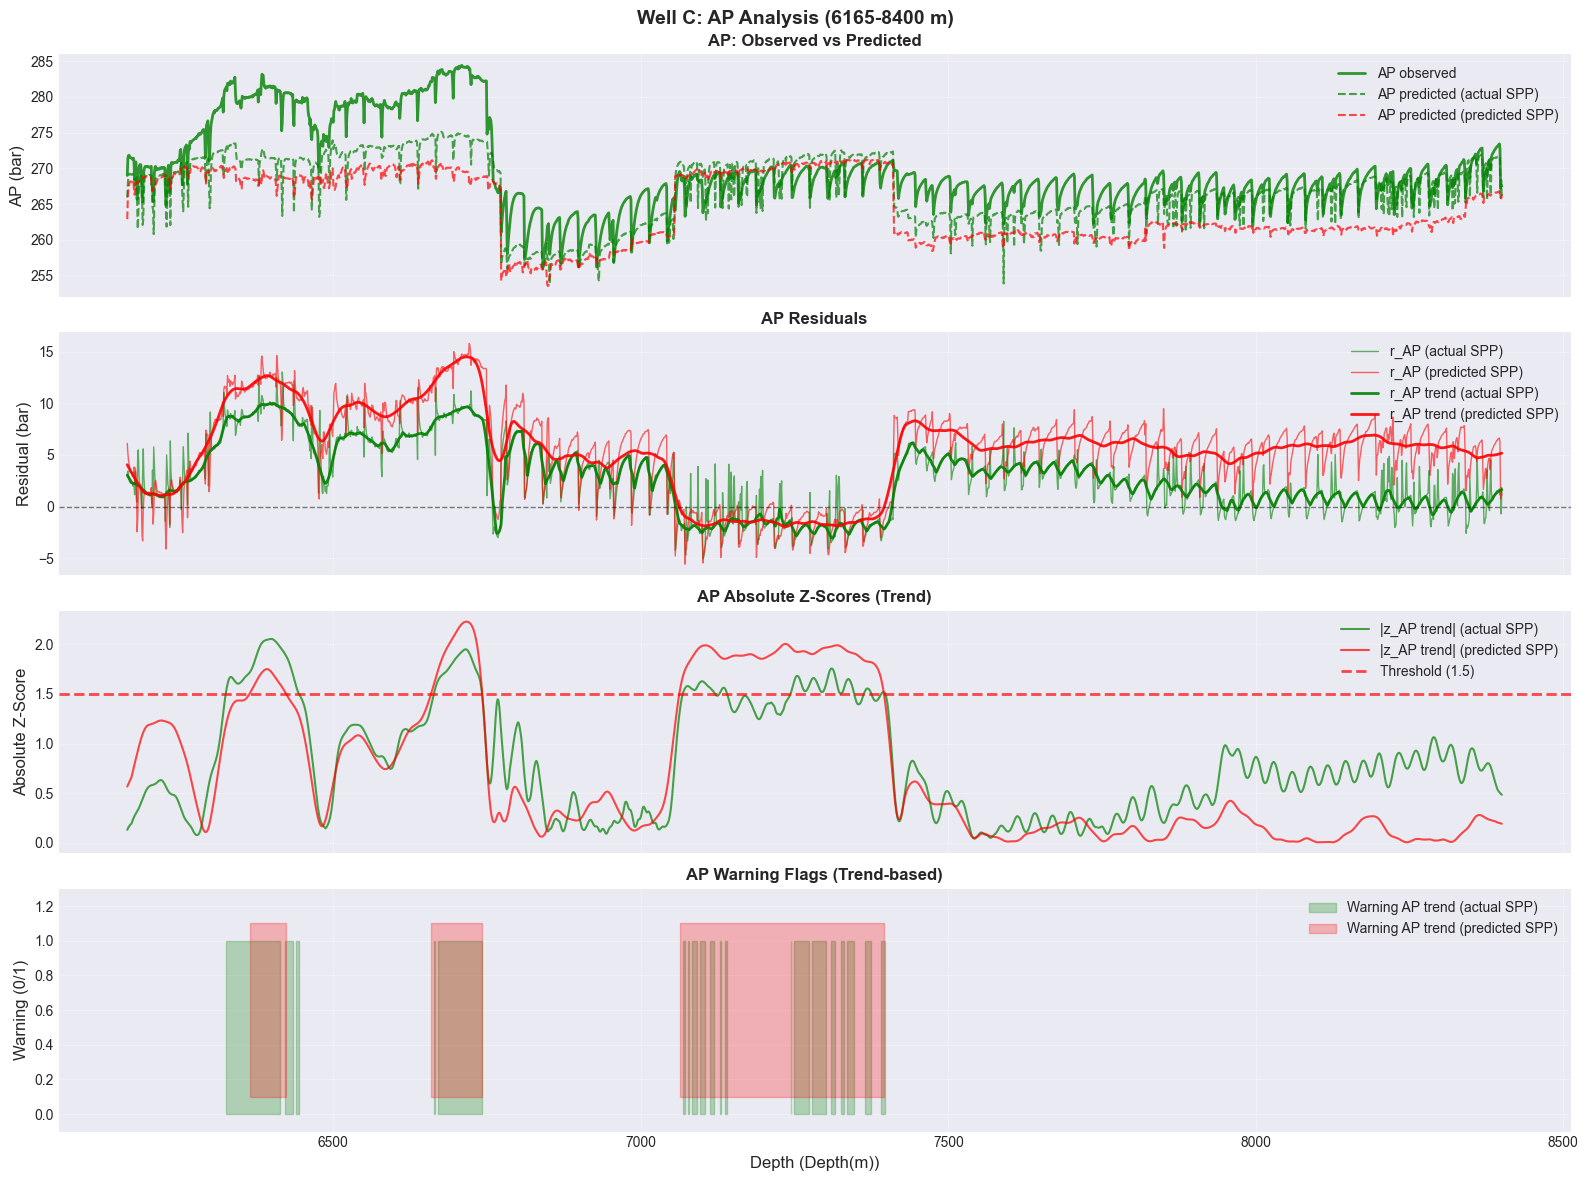


Generating AP analysis plot for Well D
Saved: ..\figures\residuals_n_warnings\AP_warning_pipeline_D.pdf


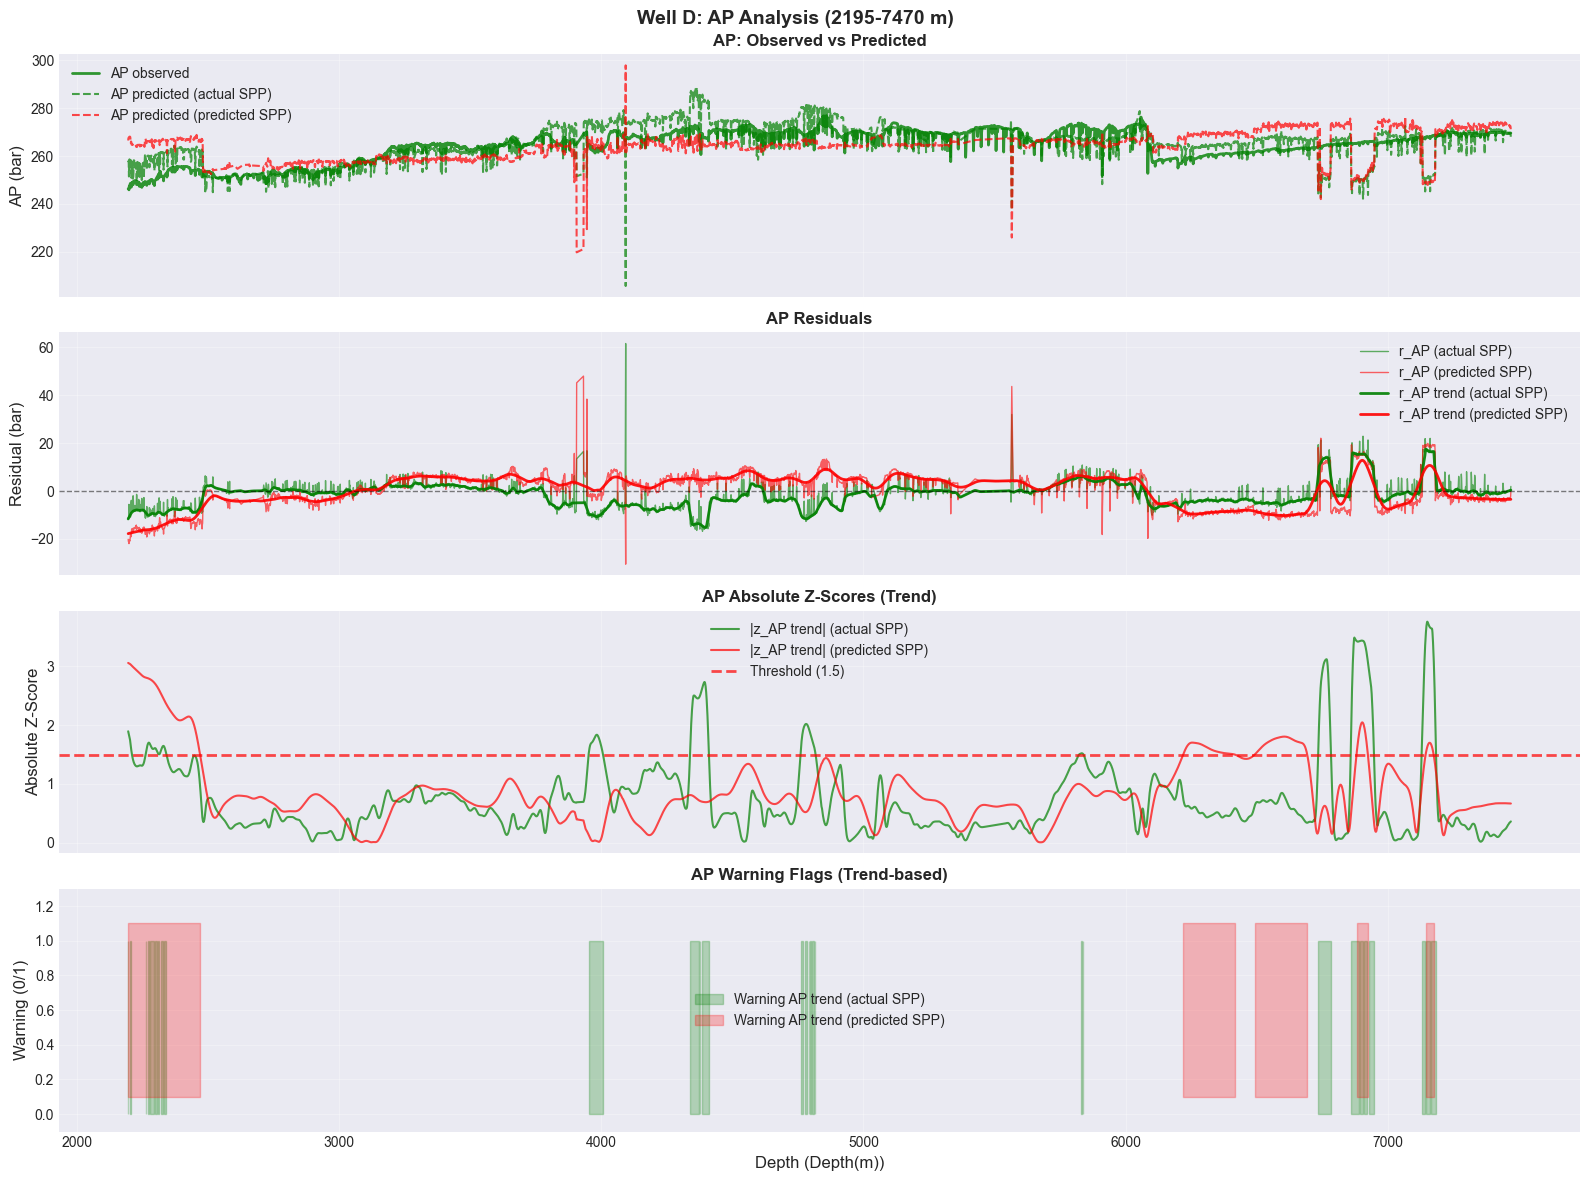


ALL AP ANALYSIS PLOTS COMPLETED


In [471]:
# ============================================================================
# GENERATE AP ANALYSIS PLOTS FOR ALL WELLS
# ============================================================================

# Get the active dataset
if 'ACTIVE_DATASET_KEY' in globals() and ACTIVE_DATASET_KEY in processed_datasets:
    df_ap_plots = processed_datasets[ACTIVE_DATASET_KEY].copy()
    print(f"Using dataset: {ACTIVE_DATASET_KEY}")
else:
    df_ap_plots = df.copy()
    print("Using default dataframe")

# Generate plots for each well (use LPE-focused interval if available)
for well_id in sorted(df_ap_plots['well_id'].unique()):
    data_w = df_ap_plots[df_ap_plots['well_id'] == well_id].sort_values(DEPTH_COL)
    if 'mode' in data_w.columns:
        lpe_mask = data_w['mode'] == 'low_pressure_event'
        if lpe_mask.sum() > 0:
            lpe_depths = data_w[lpe_mask][DEPTH_COL]
            d_start = max(data_w[DEPTH_COL].min(), lpe_depths.min() - 200)
            d_end = min(data_w[DEPTH_COL].max(), lpe_depths.max() + 200)
        else:
            d_range = data_w[DEPTH_COL].max() - data_w[DEPTH_COL].min()
            d_start = data_w[DEPTH_COL].min() + 0.3 * d_range
            d_end = data_w[DEPTH_COL].min() + 0.7 * d_range
    else:
        d_range = data_w[DEPTH_COL].max() - data_w[DEPTH_COL].min()
        d_start = data_w[DEPTH_COL].min() + 0.3 * d_range
        d_end = data_w[DEPTH_COL].min() + 0.7 * d_range
    
    print(f"\n{'='*80}")
    print(f"Generating AP analysis plot for Well {well_id}")
    print(f"{'='*80}")
    fig = plot_ap_analysis_with_warnings(df_ap_plots, well_id, depth_start=d_start, depth_end=d_end,
                                         title_suffix=f" ({d_start:.0f}-{d_end:.0f} m)")
    if fig is not None:
        plt.show()

print("\n" + "="*80)
print("ALL AP ANALYSIS PLOTS COMPLETED")
print("="*80)

GENERATING COMPREHENSIVE ANALYSIS PLOTS FOR ALL WELLS
Using dataset: actual_features

Generating comprehensive plot for Well A


C:\Users\valde\AppData\Local\Temp\ipykernel_5724\2597795774.py:63: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(well_data.loc[mask_ap_trend, DEPTH_COL], well_data.loc[mask_ap_trend, "r_AP_lr_trend_lowess"],
C:\Users\valde\AppData\Local\Temp\ipykernel_5724\2597795774.py:69: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(well_data.loc[mask_ap_pred_trend, DEPTH_COL], well_data.loc[mask_ap_pred_trend, "r_AP_lr_predSPP_trend_lowess"],
C:\Users\valde\AppData\Local\Temp\ipykernel_5724\2597795774.py:75: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(well_data.loc[mask_spp_trend, DEPTH_COL], well_data.lo

Saved: ..\figures\residuals_n_warnings\z_diff_common_A.pdf


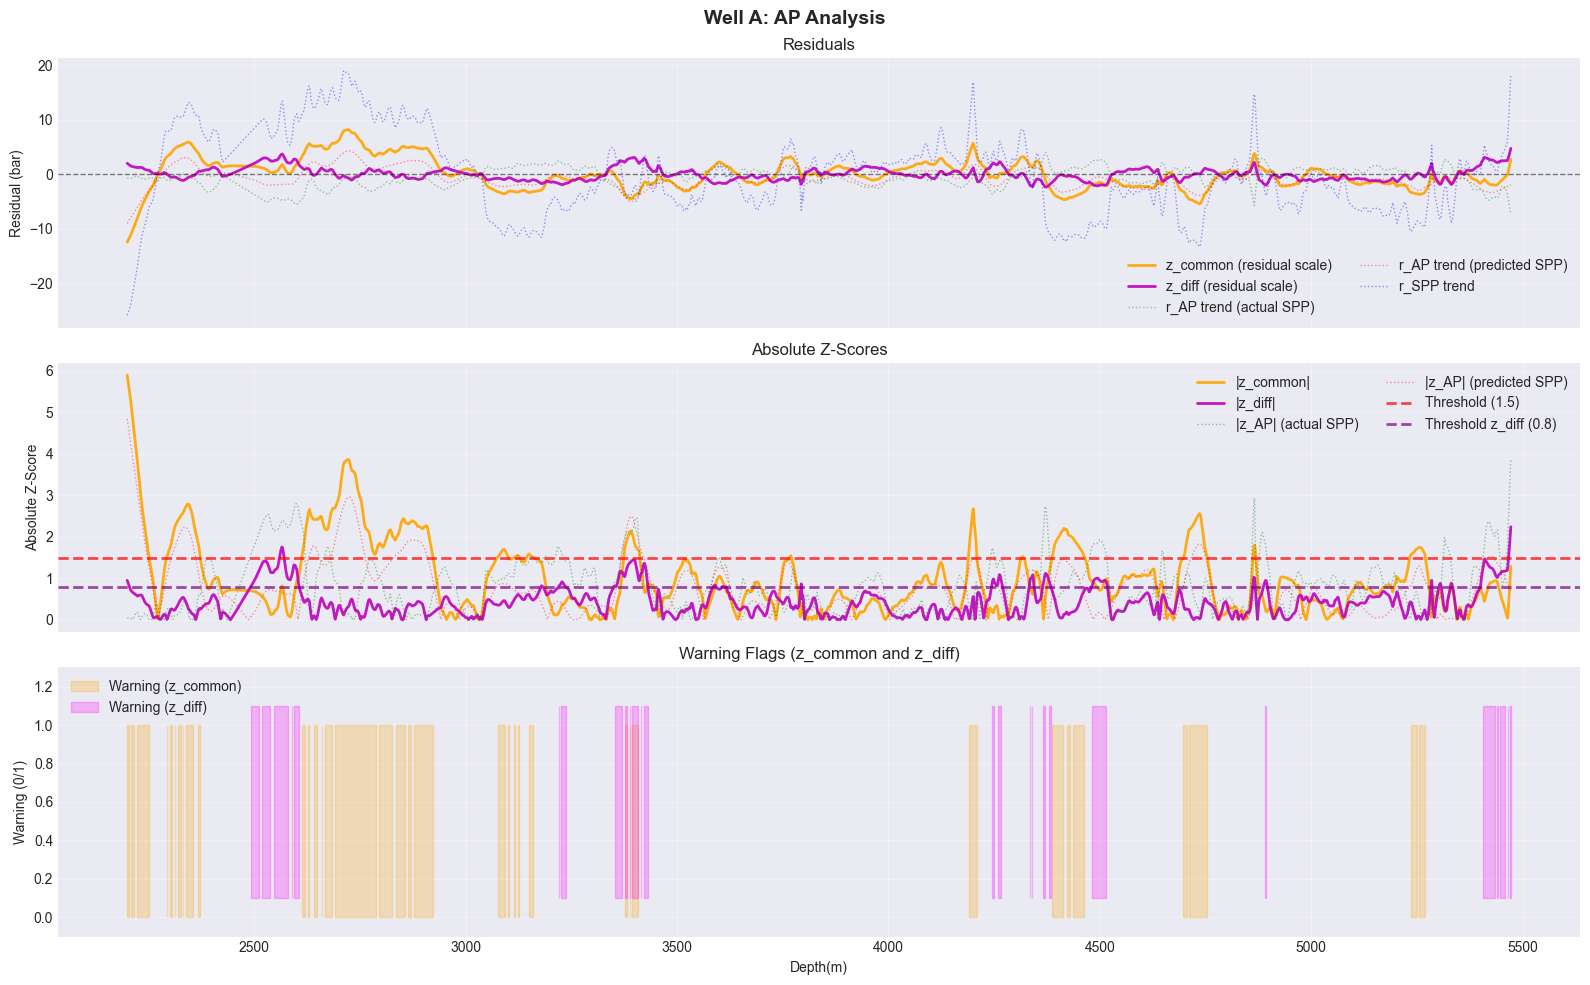


Generating comprehensive plot for Well B


C:\Users\valde\AppData\Local\Temp\ipykernel_5724\2597795774.py:63: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(well_data.loc[mask_ap_trend, DEPTH_COL], well_data.loc[mask_ap_trend, "r_AP_lr_trend_lowess"],
C:\Users\valde\AppData\Local\Temp\ipykernel_5724\2597795774.py:69: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(well_data.loc[mask_ap_pred_trend, DEPTH_COL], well_data.loc[mask_ap_pred_trend, "r_AP_lr_predSPP_trend_lowess"],
C:\Users\valde\AppData\Local\Temp\ipykernel_5724\2597795774.py:75: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(well_data.loc[mask_spp_trend, DEPTH_COL], well_data.lo

Saved: ..\figures\residuals_n_warnings\z_diff_common_B.pdf


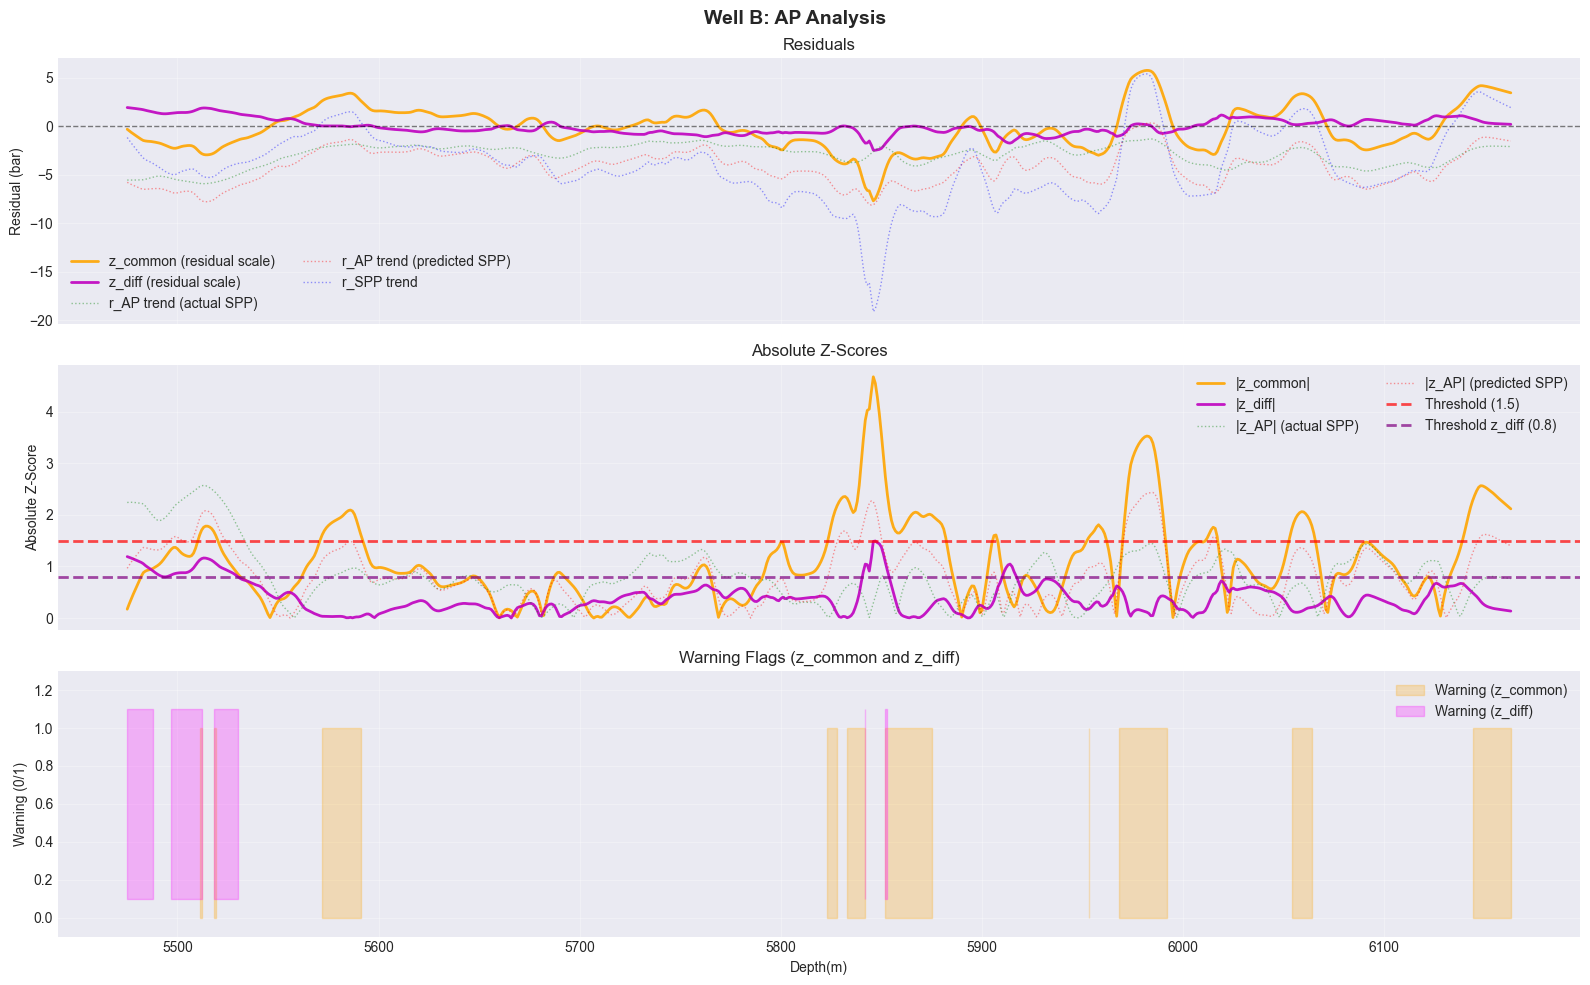


Generating comprehensive plot for Well C


C:\Users\valde\AppData\Local\Temp\ipykernel_5724\2597795774.py:63: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(well_data.loc[mask_ap_trend, DEPTH_COL], well_data.loc[mask_ap_trend, "r_AP_lr_trend_lowess"],
C:\Users\valde\AppData\Local\Temp\ipykernel_5724\2597795774.py:69: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(well_data.loc[mask_ap_pred_trend, DEPTH_COL], well_data.loc[mask_ap_pred_trend, "r_AP_lr_predSPP_trend_lowess"],
C:\Users\valde\AppData\Local\Temp\ipykernel_5724\2597795774.py:75: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(well_data.loc[mask_spp_trend, DEPTH_COL], well_data.lo

Saved: ..\figures\residuals_n_warnings\z_diff_common_C.pdf


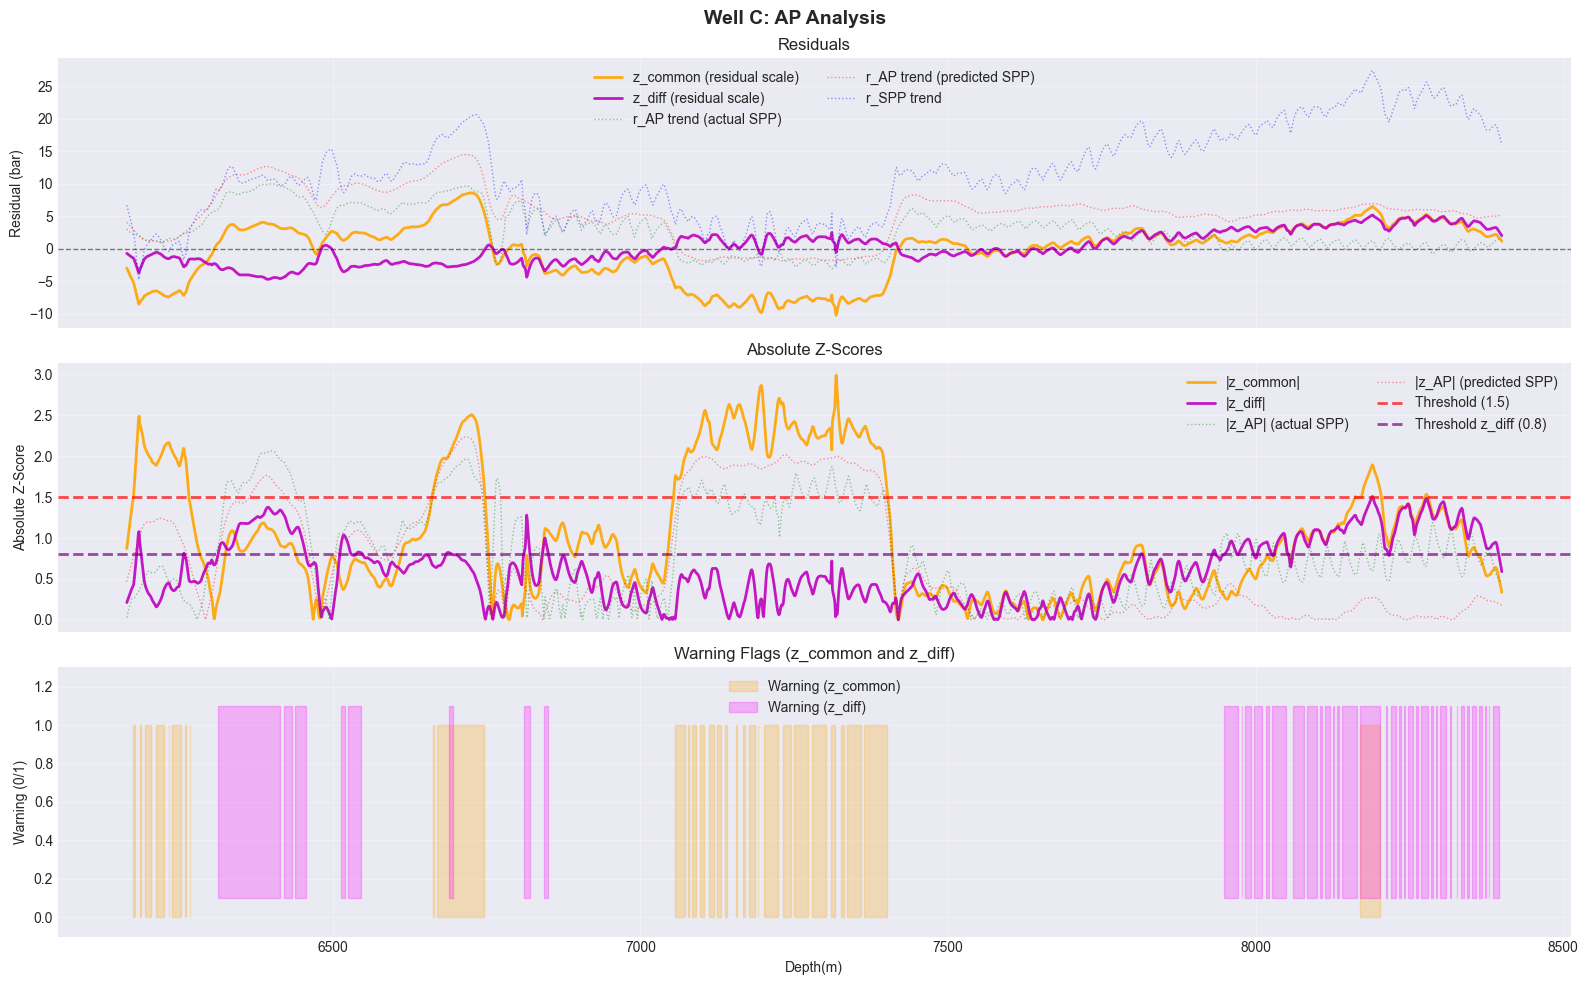


Generating comprehensive plot for Well D


C:\Users\valde\AppData\Local\Temp\ipykernel_5724\2597795774.py:63: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(well_data.loc[mask_ap_trend, DEPTH_COL], well_data.loc[mask_ap_trend, "r_AP_lr_trend_lowess"],
C:\Users\valde\AppData\Local\Temp\ipykernel_5724\2597795774.py:69: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(well_data.loc[mask_ap_pred_trend, DEPTH_COL], well_data.loc[mask_ap_pred_trend, "r_AP_lr_predSPP_trend_lowess"],
C:\Users\valde\AppData\Local\Temp\ipykernel_5724\2597795774.py:75: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(well_data.loc[mask_spp_trend, DEPTH_COL], well_data.lo

Saved: ..\figures\residuals_n_warnings\z_diff_common_D.pdf


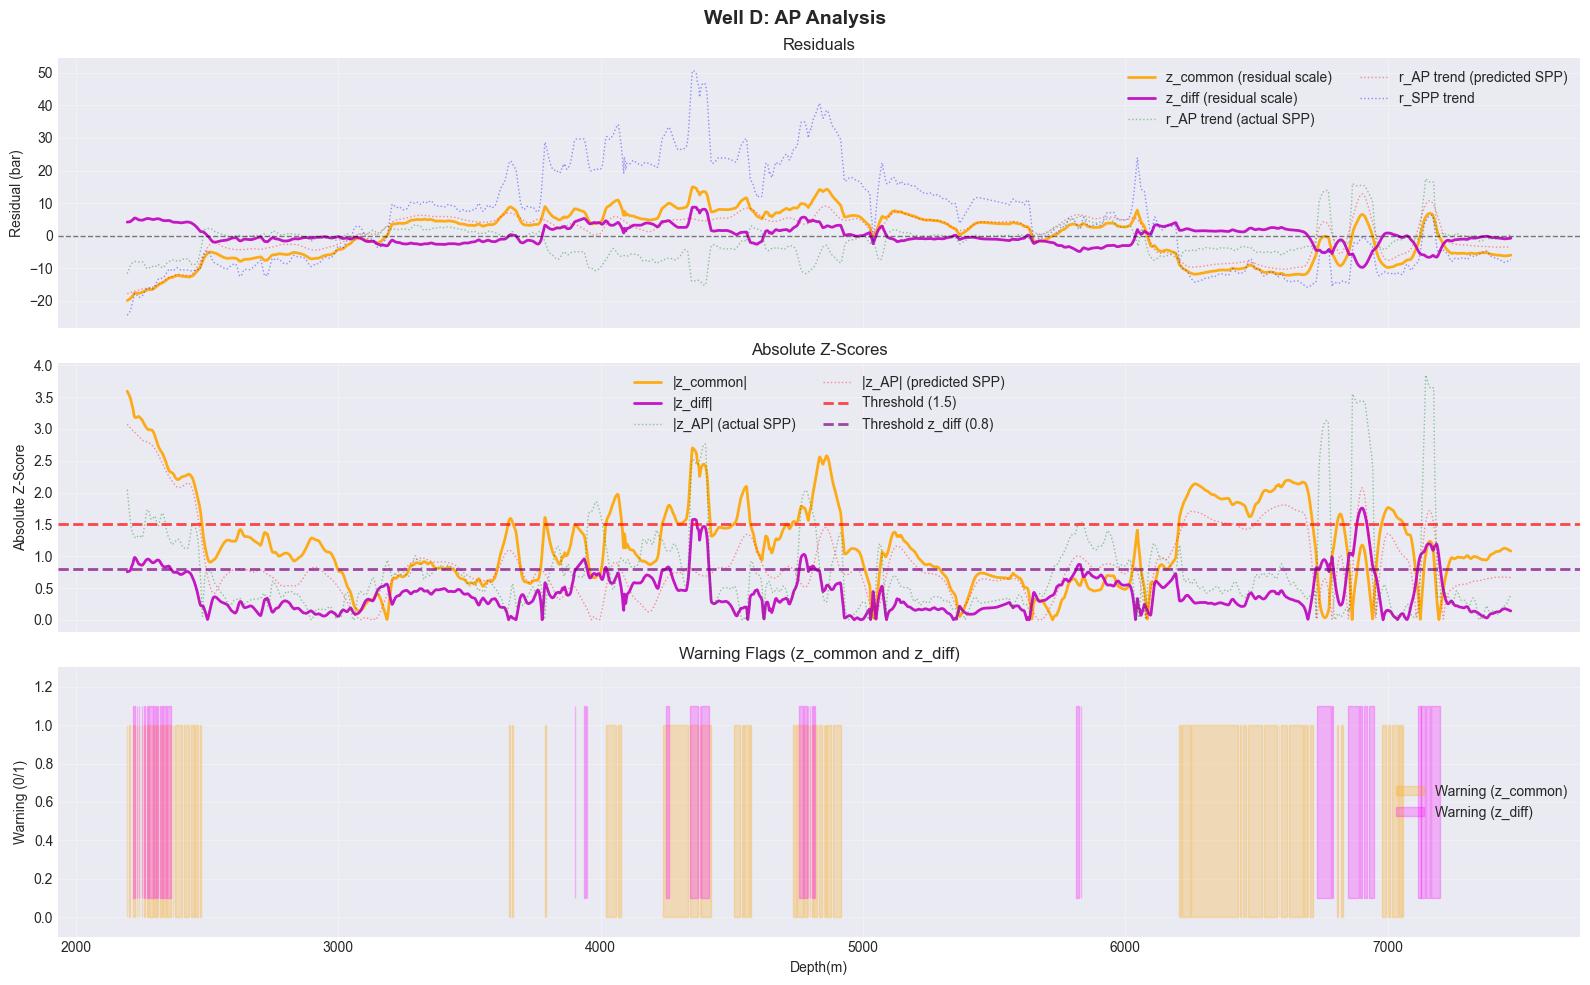


ALL COMPREHENSIVE PLOTS COMPLETED


In [467]:
# ============================================================================
# GENERATE COMPREHENSIVE PLOTS FOR ALL WELLS
# ============================================================================

print("="*80)
print("GENERATING COMPREHENSIVE ANALYSIS PLOTS FOR ALL WELLS")
print("="*80)

# Get the active dataset
if 'ACTIVE_DATASET_KEY' in globals() and ACTIVE_DATASET_KEY in processed_datasets:
    df_viz = processed_datasets[ACTIVE_DATASET_KEY].copy()
    print(f"Using dataset: {ACTIVE_DATASET_KEY}")
else:
    df_viz = df.copy()
    print("Using default dataframe")

# Generate comprehensive plots for each well
for well_id in sorted(df_viz['well_id'].unique()):
    print(f"\n{'='*80}")
    print(f"Generating comprehensive plot for Well {well_id}")
    print(f"{'='*80}")
    plot_comprehensive_analysis(df_viz, well_id)

print("\n" + "="*80)
print("ALL COMPREHENSIVE PLOTS COMPLETED")
print("="*80)


In [458]:
# Re-apply localized trend warnings to include both SPP and AP
for key, df_raw in processed_datasets.items():
    df_aug = apply_segment_trend_warning(df_raw, target_name=None)
    df_aug = apply_local_stats_trend_warning(df_aug, target_name=None)
    processed_datasets[key] = df_aug

# refresh active df
if 'ACTIVE_DATASET_KEY' in globals() and ACTIVE_DATASET_KEY in processed_datasets:
    df = processed_datasets[ACTIVE_DATASET_KEY].copy()
    print(f"Recomputed localized trend warnings for {ACTIVE_DATASET_KEY}: {len(df)} rows")



Recomputed localized trend warnings for actual_features: 11442 rows


### SPP: Global vs Localized Trend-Based Warnings

Plots compare global trend-based warnings to two localized variants:
- **Segment-based**: stats computed within overlapping depth windows
- **Rolling-local stats**: local mean/std via rolling window on trend residuals

This highlights how localized normalization can capture local fluctuations while reducing influence from distant mispredictions.


Saved: ..\figures\residuals_n_warnings\warning_flag_well_A.pdf


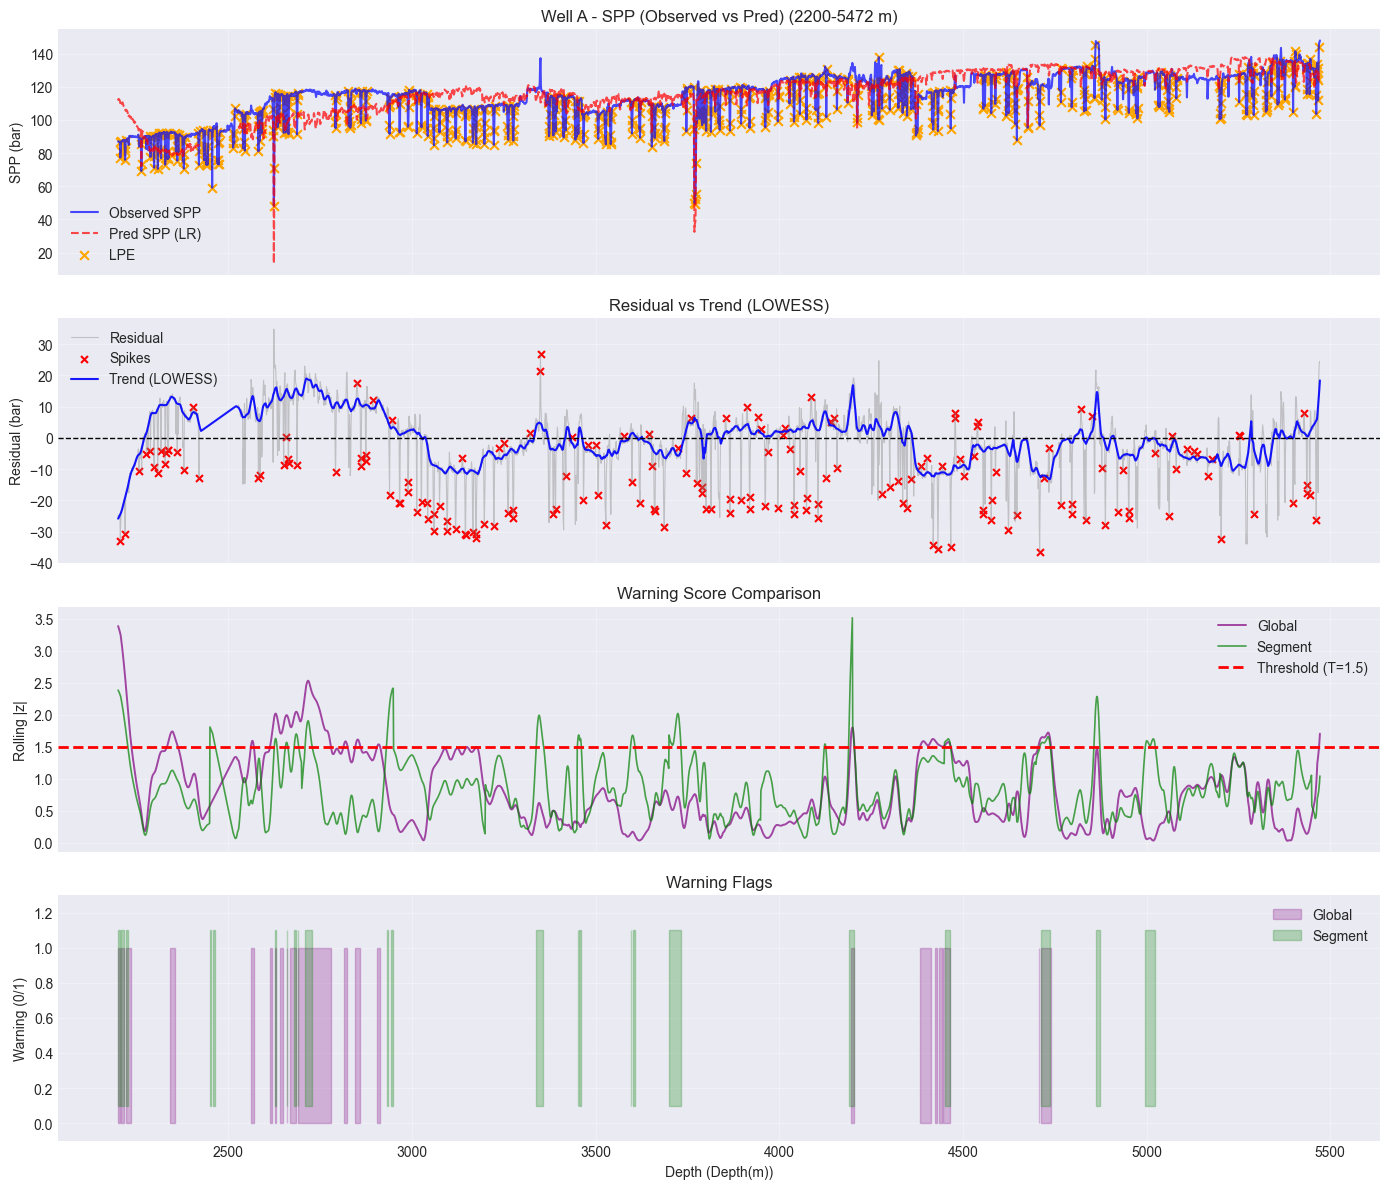

Saved: ..\figures\residuals_n_warnings\warning_flag_well_B.pdf


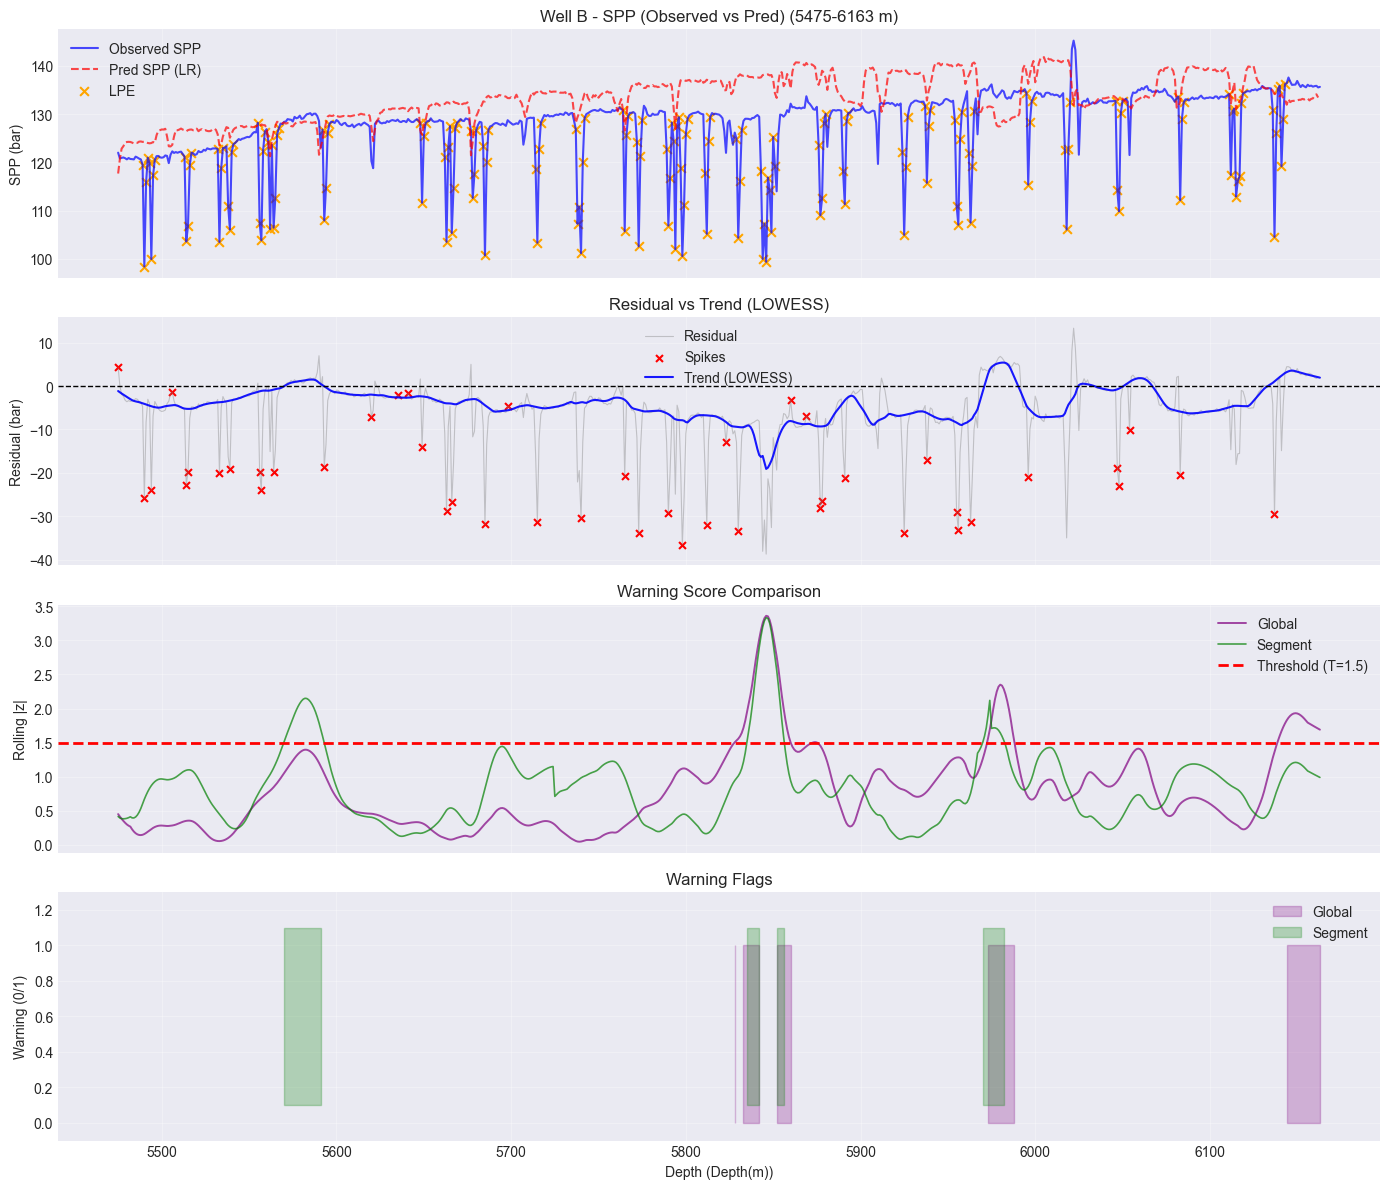

Saved: ..\figures\residuals_n_warnings\warning_flag_well_C.pdf


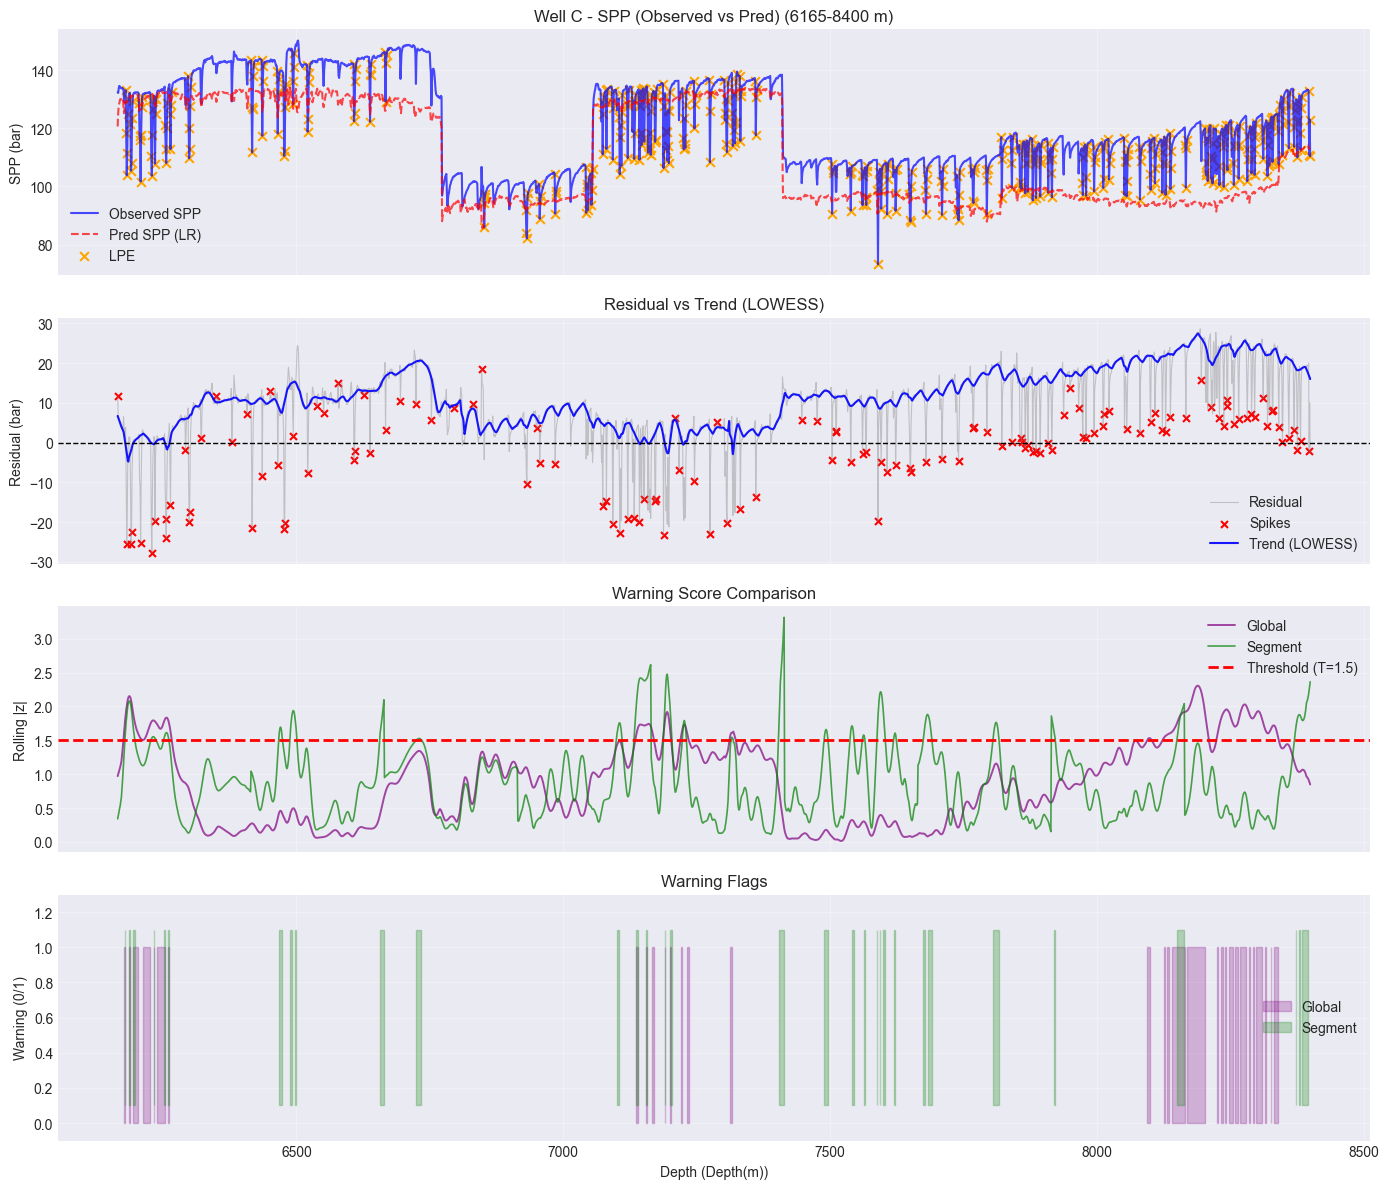

Saved: ..\figures\residuals_n_warnings\warning_flag_well_D.pdf


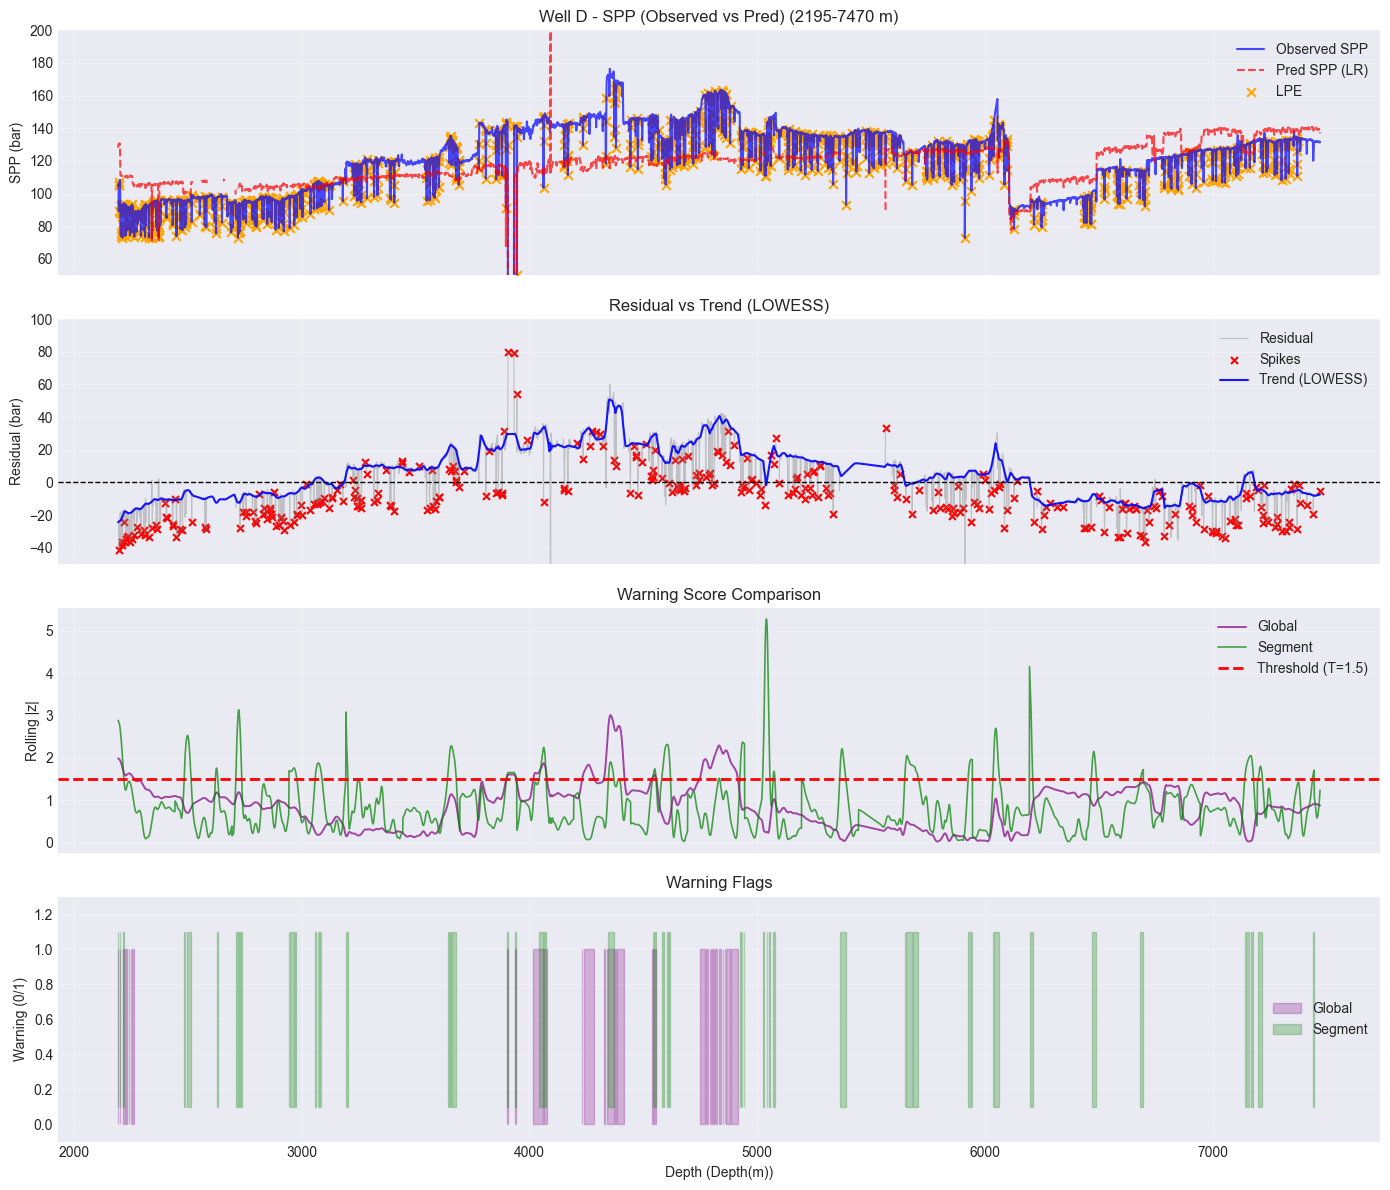


Generating simplified residual pipeline plot for Well B
Saved: ..\figures\residuals_n_warnings\residual_pipeline_well_B.pdf


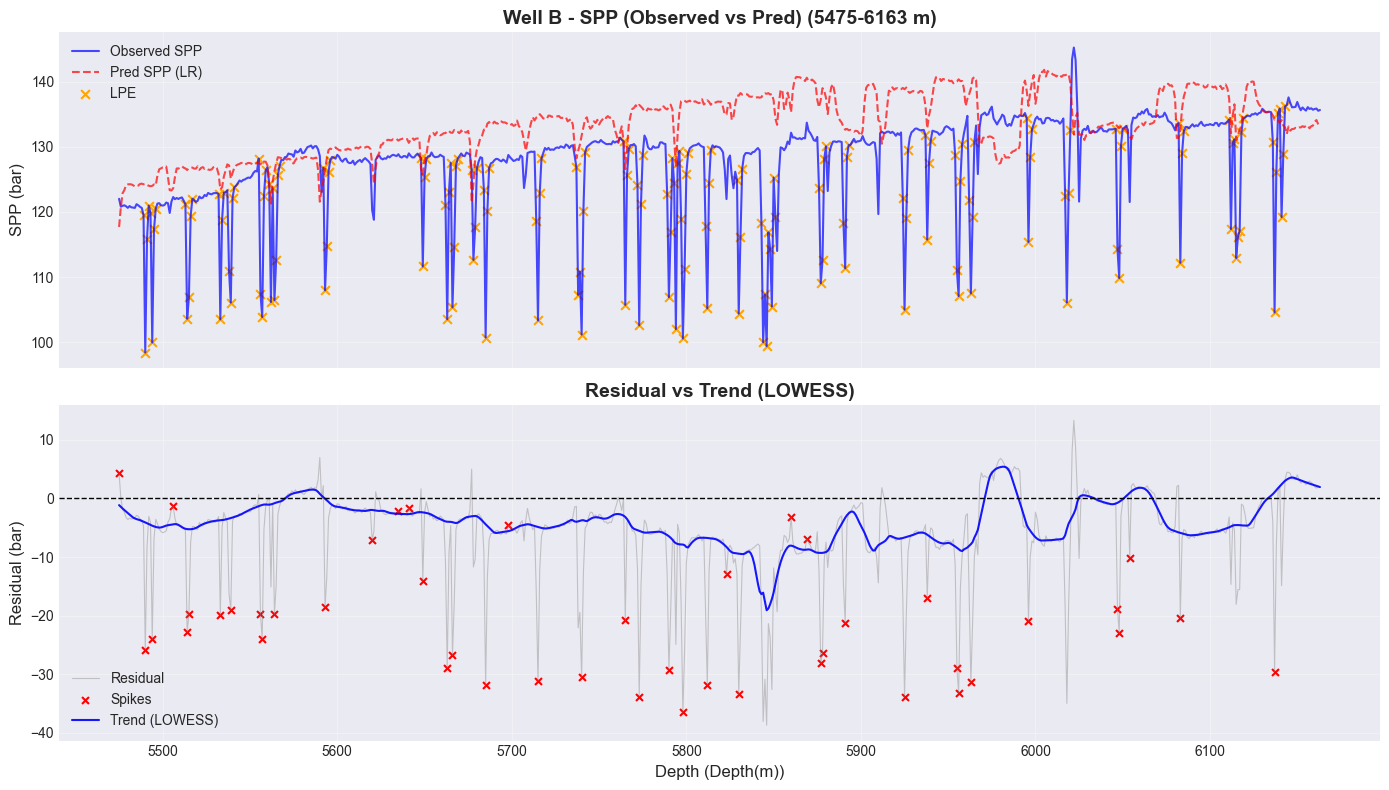


Generating simplified residual pipeline plot for Well C
Saved: ..\figures\residuals_n_warnings\residual_pipeline_well_C.pdf


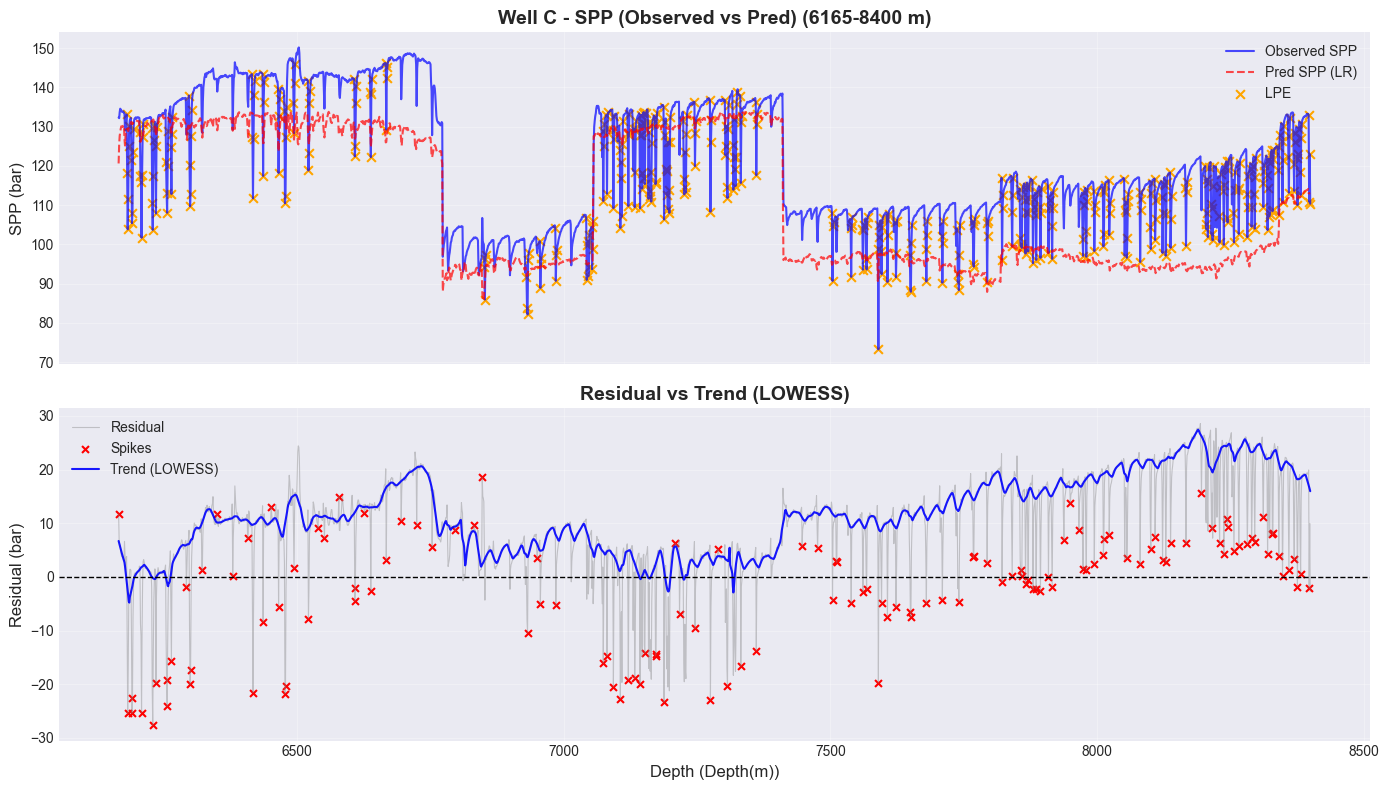

In [459]:
# ==========================================================================
# PLOTTING: GLOBAL VS LOCALIZED (SPP)
# ==========================================================================

def plot_spp_local_variants(df_in, well_id, depth_start=None, depth_end=None, title_suffix=""):
    trend_col = "r_SPP_lr_trend_lowess"
    roll_global = "rolling_abs_z_SPP_lr_trend"
    warn_global = "warning_SPP_trend"
    roll_seg = "rolling_abs_z_SPP_lr_trend_seg"
    warn_seg = "warning_SPP_trend_seg"
    roll_local = "rolling_abs_z_SPP_lr_trend_local"
    warn_local = "warning_SPP_trend_local"
    spike_col = "is_spike_r_SPP_lr"
    residual_col = "r_SPP_lr"
    
    well = df_in[df_in['well_id'] == well_id].copy().sort_values(DEPTH_COL).reset_index(drop=True)
    if depth_start is not None and depth_end is not None:
        well = well[(well[DEPTH_COL] >= depth_start) & (well[DEPTH_COL] <= depth_end)]
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
    
    # Observed vs predicted
    ax = axes[0]
    ax.plot(well[DEPTH_COL], well[SPP_COL], 'b-', alpha=0.7, label='Observed SPP')
    ax.plot(well[DEPTH_COL], well['SPP_pred_lr'], 'r--', alpha=0.7, label='Pred SPP (LR)')
    if 'mode' in well.columns:
        lpe_mask = well['mode'] == 'low_pressure_event'
        if lpe_mask.sum() > 0:
            ax.scatter(well.loc[lpe_mask, DEPTH_COL], well.loc[lpe_mask, SPP_COL], c='orange', marker='x', s=40, label='LPE')
    ax.set_ylabel('SPP (bar)')
    ax.set_title(f'Well {well_id} - SPP (Observed vs Pred){title_suffix}')
    ax.legend()
    ax.grid(True, alpha=0.3)
        # Set y-axis limits for Well D to handle skewed values
    if well_id == 'D':
        ax.set_ylim(50, 200)
    
    # Residuals and trend
    ax = axes[1]
    ax.plot(well[DEPTH_COL], well[residual_col], 'gray', alpha=0.4, linewidth=0.8, label='Residual')
    if spike_col in well.columns:
        spikes = well[spike_col] & well[residual_col].notna()
        if spikes.sum() > 0:
            ax.scatter(well.loc[spikes, DEPTH_COL], well.loc[spikes, residual_col], c='red', s=25, marker='x', label='Spikes')
    ax.plot(well[DEPTH_COL], well[trend_col], 'b-', alpha=0.9, linewidth=1.5, label='Trend (LOWESS)')
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_ylabel('Residual (bar)')
    ax.set_title('Residual vs Trend (LOWESS)')
    ax.legend()
    ax.grid(True, alpha=0.3)
        # Set y-axis limits for Well D to handle skewed values
    if well_id == 'D':
        ax.set_ylim(-50, 100)
    
    # Warning scores
    ax = axes[2]
    if roll_global in well.columns:
        ax.plot(well[DEPTH_COL], well[roll_global], 'purple', alpha=0.7, linewidth=1.4, label='Global')
    if roll_seg in well.columns:
        ax.plot(well[DEPTH_COL], well[roll_seg], 'green', alpha=0.7, linewidth=1.2, label='Segment')
    ax.axhline(THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold (T={THRESHOLD})')
    ax.set_ylabel('Rolling |z|')
    ax.set_title('Warning Score Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Warning flags
    ax = axes[3]
    if warn_global in well.columns:
        ax.fill_between(well[DEPTH_COL], 0, well[warn_global], where=well[warn_global]==1, color='purple', alpha=0.25, label='Global')
    if warn_seg in well.columns:
        ax.fill_between(well[DEPTH_COL], 0.1, 0.1 + well[warn_seg], where=well[warn_seg]==1, color='green', alpha=0.25, label='Segment')
    ax.set_ylabel('Warning (0/1)')
    ax.set_xlabel(f'Depth ({DEPTH_COL})')
    ax.set_ylim(-0.1, 1.3)
    ax.set_title('Warning Flags')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    
    # Save to PDF
    output_dir = Path("../figures/residuals_n_warnings")
    output_dir.mkdir(parents=True, exist_ok=True)
    filename = output_dir / f"warning_flag_well_{well_id}.pdf"
    fig.savefig(filename, format='pdf', bbox_inches='tight')
    print(f"Saved: {filename}")
    
    plt.show()

# Generate plots for all wells (use LPE-focused interval if available)
for well_id in sorted(df['well_id'].unique()):
    data_w = df[df['well_id'] == well_id].sort_values(DEPTH_COL)
    if 'mode' in data_w.columns:
        lpe_mask = data_w['mode'] == 'low_pressure_event'
        if lpe_mask.sum() > 0:
            lpe_depths = data_w[lpe_mask][DEPTH_COL]
            d_start = max(data_w[DEPTH_COL].min(), lpe_depths.min() - 200)
            d_end = min(data_w[DEPTH_COL].max(), lpe_depths.max() + 200)
        else:
            d_range = data_w[DEPTH_COL].max() - data_w[DEPTH_COL].min()
            d_start = data_w[DEPTH_COL].min() + 0.3 * d_range
            d_end = data_w[DEPTH_COL].min() + 0.7 * d_range
    else:
        d_range = data_w[DEPTH_COL].max() - data_w[DEPTH_COL].min()
        d_start = data_w[DEPTH_COL].min() + 0.3 * d_range
        d_end = data_w[DEPTH_COL].min() + 0.7 * d_range
        print(f"\nSPP - Well {well_id}: Global vs Localized warnings")
    plot_spp_local_variants(df, well_id, depth_start=d_start, depth_end=d_end,  
                            title_suffix=f" ({d_start:.0f}-{d_end:.0f} m)")     

# Simplified function for SPP observed vs pred and residual vs trend only
def plot_spp_residual_pipeline(df_in, well_id, depth_start=None, depth_end=None, title_suffix=""):
    """
    Plot only SPP observed vs predicted and Residual vs trend (no warning plots).
    """
    trend_col = "r_SPP_lr_trend_lowess"
    spike_col = "is_spike_r_SPP_lr"
    residual_col = "r_SPP_lr"
    
    well = df_in[df_in['well_id'] == well_id].copy().sort_values(DEPTH_COL).reset_index(drop=True)
    if depth_start is not None and depth_end is not None:
        well = well[(well[DEPTH_COL] >= depth_start) & (well[DEPTH_COL] <= depth_end)]
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Observed vs predicted
    ax = axes[0]
    ax.plot(well[DEPTH_COL], well[SPP_COL], 'b-', alpha=0.7, label='Observed SPP')
    ax.plot(well[DEPTH_COL], well['SPP_pred_lr'], 'r--', alpha=0.7, label='Pred SPP (LR)')
    if 'mode' in well.columns:
        lpe_mask = well['mode'] == 'low_pressure_event'
        if lpe_mask.sum() > 0:
            ax.scatter(well.loc[lpe_mask, DEPTH_COL], well.loc[lpe_mask, SPP_COL], c='orange', marker='x', s=40, label='LPE')
    ax.set_ylabel('SPP (bar)', fontsize=12)
    ax.set_title(f'Well {well_id} - SPP (Observed vs Pred){title_suffix}', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Residuals and trend
    ax = axes[1]
    ax.plot(well[DEPTH_COL], well[residual_col], 'gray', alpha=0.4, linewidth=0.8, label='Residual')
    if spike_col in well.columns:
        spikes = well[spike_col] & well[residual_col].notna()
        if spikes.sum() > 0:
            ax.scatter(well.loc[spikes, DEPTH_COL], well.loc[spikes, residual_col], c='red', s=25, marker='x', label='Spikes')
    ax.plot(well[DEPTH_COL], well[trend_col], 'b-', alpha=0.9, linewidth=1.5, label='Trend (LOWESS)')
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_ylabel('Residual (bar)', fontsize=12)
    ax.set_xlabel(f'Depth ({DEPTH_COL})', fontsize=12)
    ax.set_title('Residual vs Trend (LOWESS)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    fig.tight_layout()
    return fig

# Generate and save simplified plots for wells B and C
for well_id in ['B', 'C']:
    if well_id not in df['well_id'].unique():
        continue
    
    data_w = df[df['well_id'] == well_id].sort_values(DEPTH_COL)
    if 'mode' in data_w.columns:
        lpe_mask = data_w['mode'] == 'low_pressure_event'
        if lpe_mask.sum() > 0:
            lpe_depths = data_w[lpe_mask][DEPTH_COL]
            d_start = max(data_w[DEPTH_COL].min(), lpe_depths.min() - 200)
            d_end = min(data_w[DEPTH_COL].max(), lpe_depths.max() + 200)
        else:
            d_range = data_w[DEPTH_COL].max() - data_w[DEPTH_COL].min()
            d_start = data_w[DEPTH_COL].min() + 0.3 * d_range
            d_end = data_w[DEPTH_COL].min() + 0.7 * d_range
    else:
        d_range = data_w[DEPTH_COL].max() - data_w[DEPTH_COL].min()
        d_start = data_w[DEPTH_COL].min() + 0.3 * d_range
        d_end = data_w[DEPTH_COL].min() + 0.7 * d_range
    
    print(f"\nGenerating simplified residual pipeline plot for Well {well_id}")
    fig = plot_spp_residual_pipeline(df, well_id, depth_start=d_start, depth_end=d_end,
                                     title_suffix=f" ({d_start:.0f}-{d_end:.0f} m)")
    
    # Save to PDF
    output_dir = Path("../figures/residuals_n_warnings")
    output_dir.mkdir(parents=True, exist_ok=True)
    filename = output_dir / f"residual_pipeline_well_{well_id}.pdf"
    fig.savefig(filename, format='pdf', bbox_inches='tight')
    print(f"Saved: {filename}")
    plt.show()



Generating zoomed-in plots for specified intervals...

Well A: 2500-2800m


Saved: ..\figures\residuals_n_warnings\zoomed_interval_well_A_2500_2800.pdf


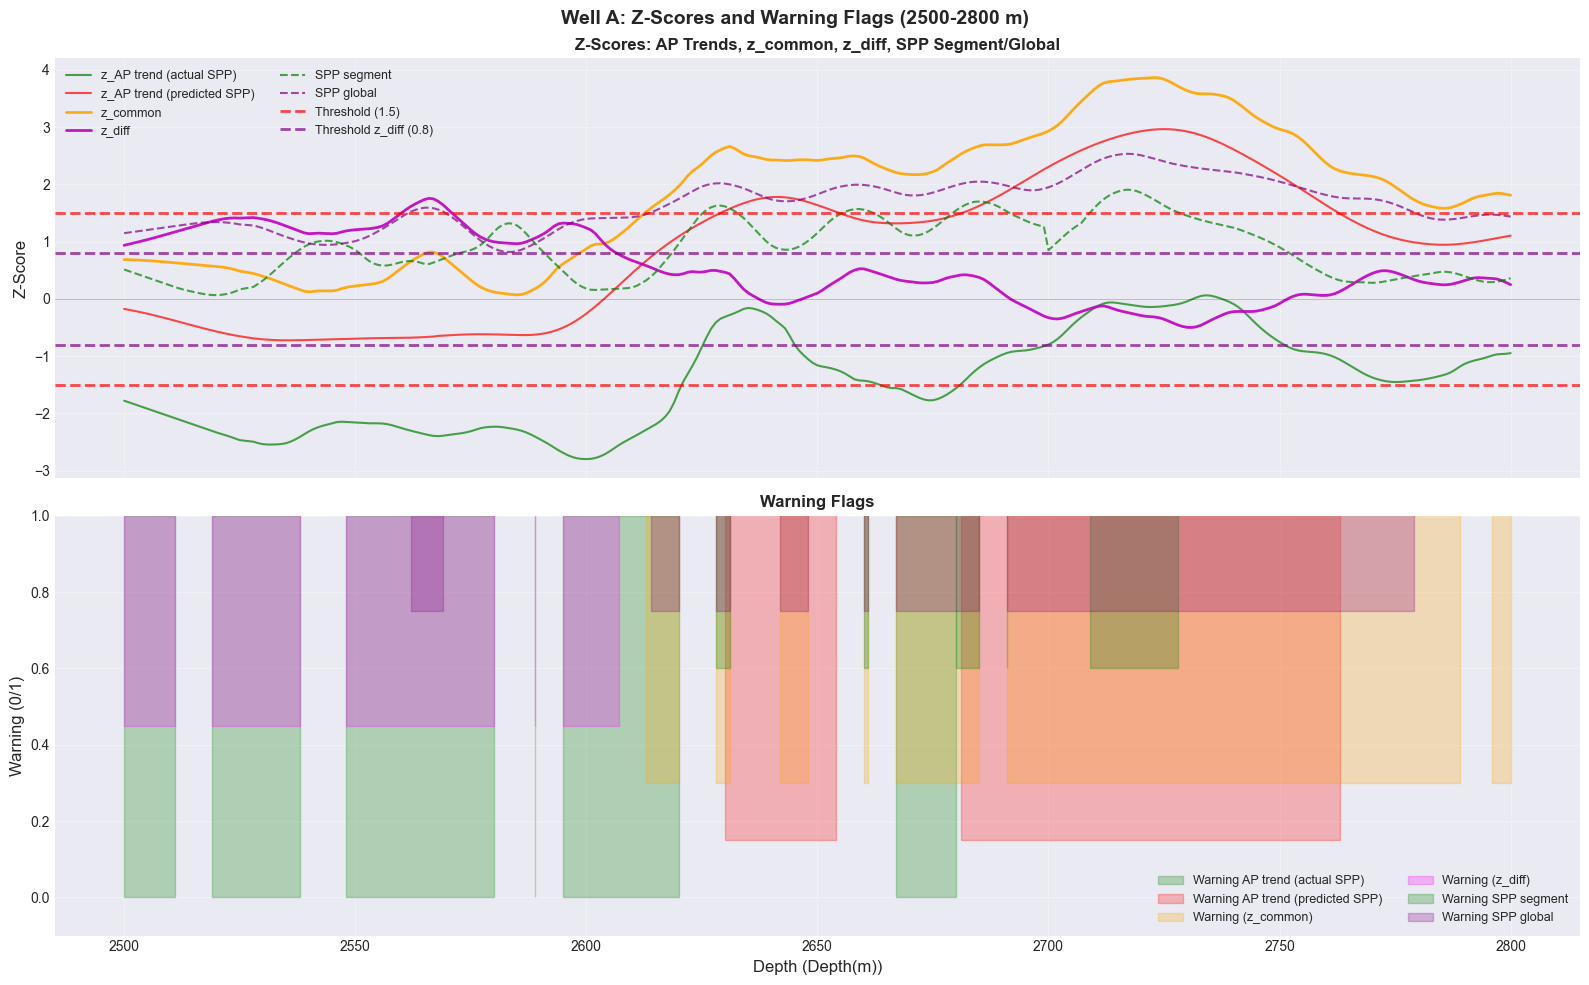


Well A: 2800-3100m
Saved: ..\figures\residuals_n_warnings\zoomed_interval_well_A_2800_3100.pdf


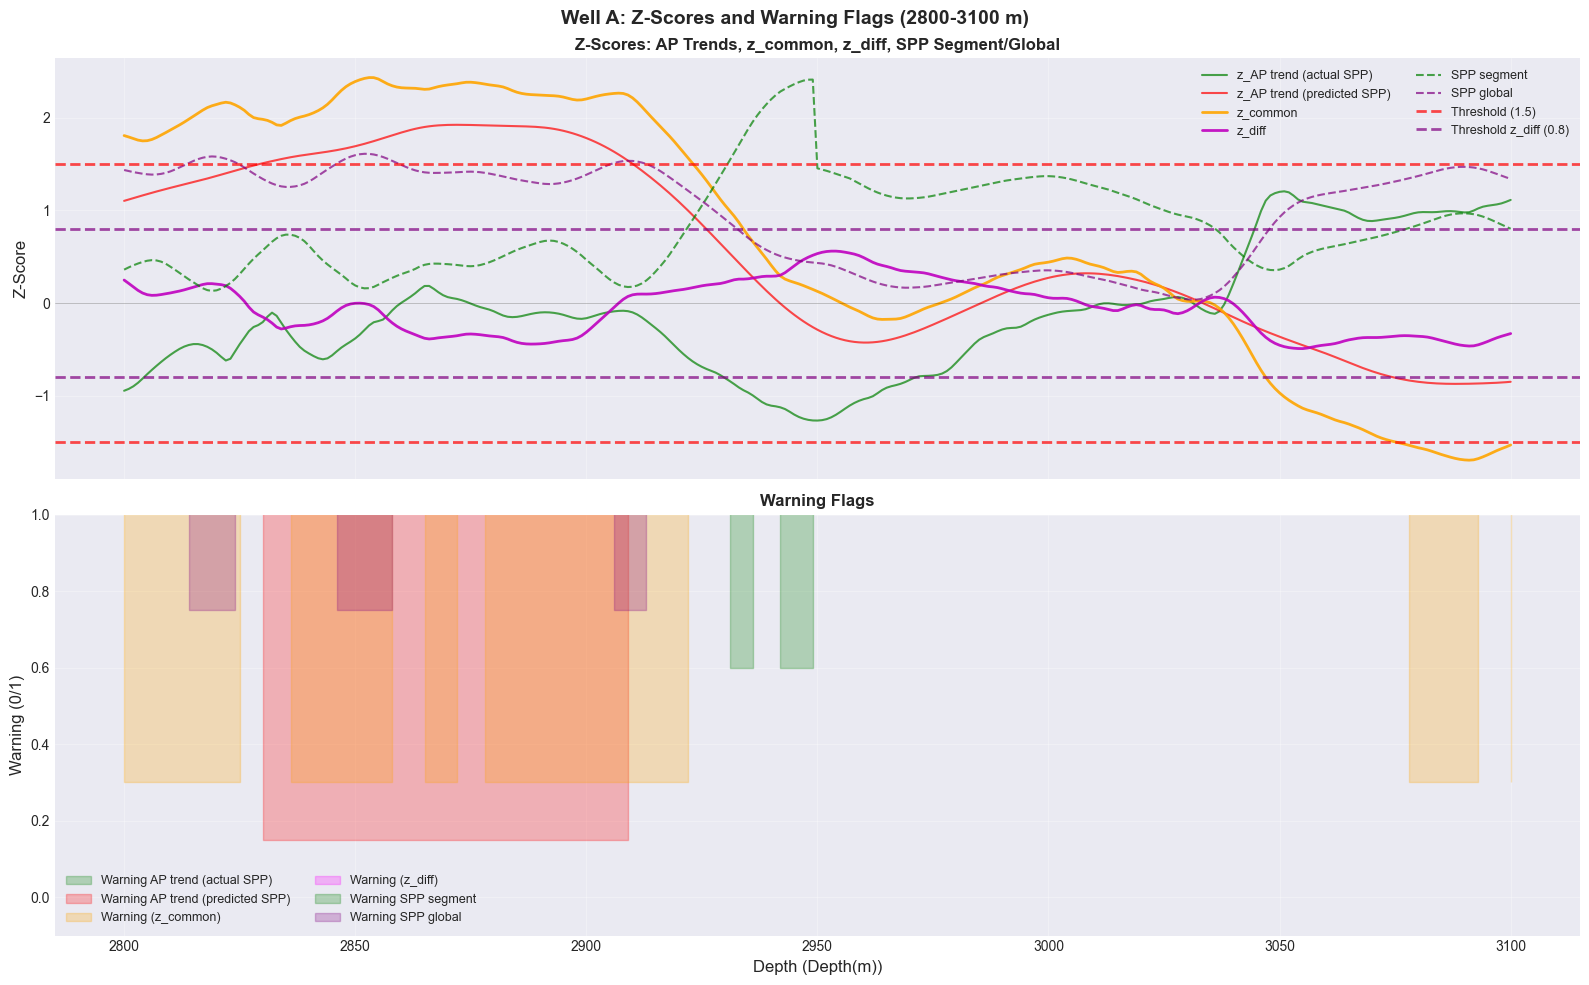


Well A: 4700-5000m
Saved: ..\figures\residuals_n_warnings\zoomed_interval_well_A_4700_5000.pdf


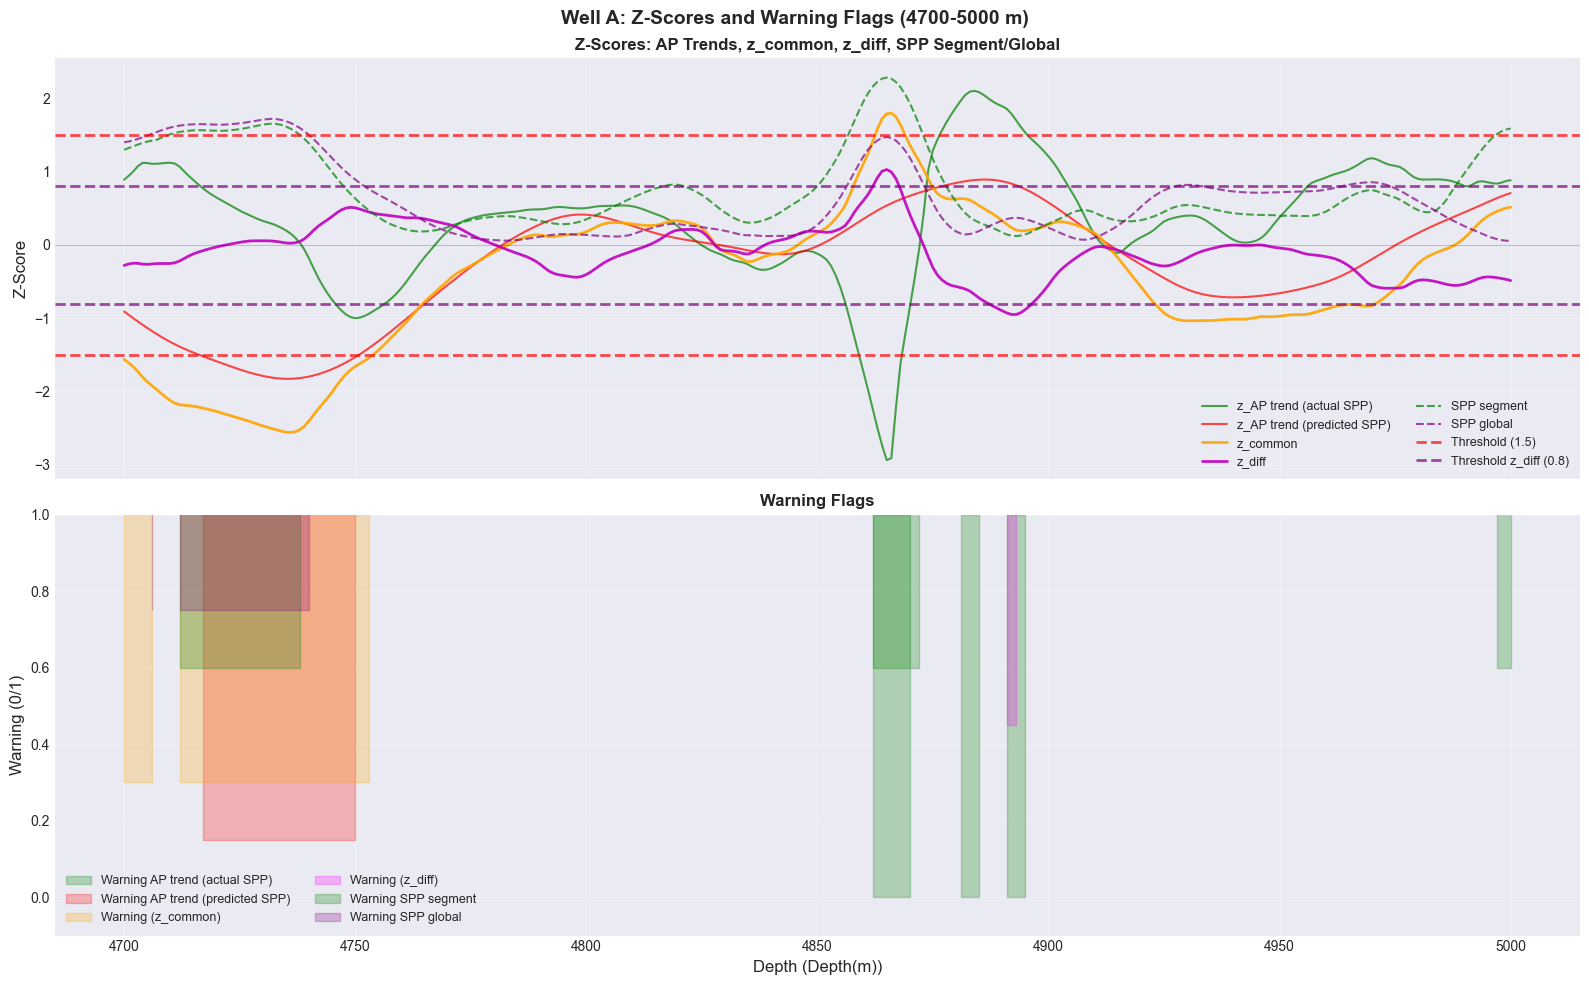


Well A: 5275-5475m
Saved: ..\figures\residuals_n_warnings\zoomed_interval_well_A_5275_5475.pdf


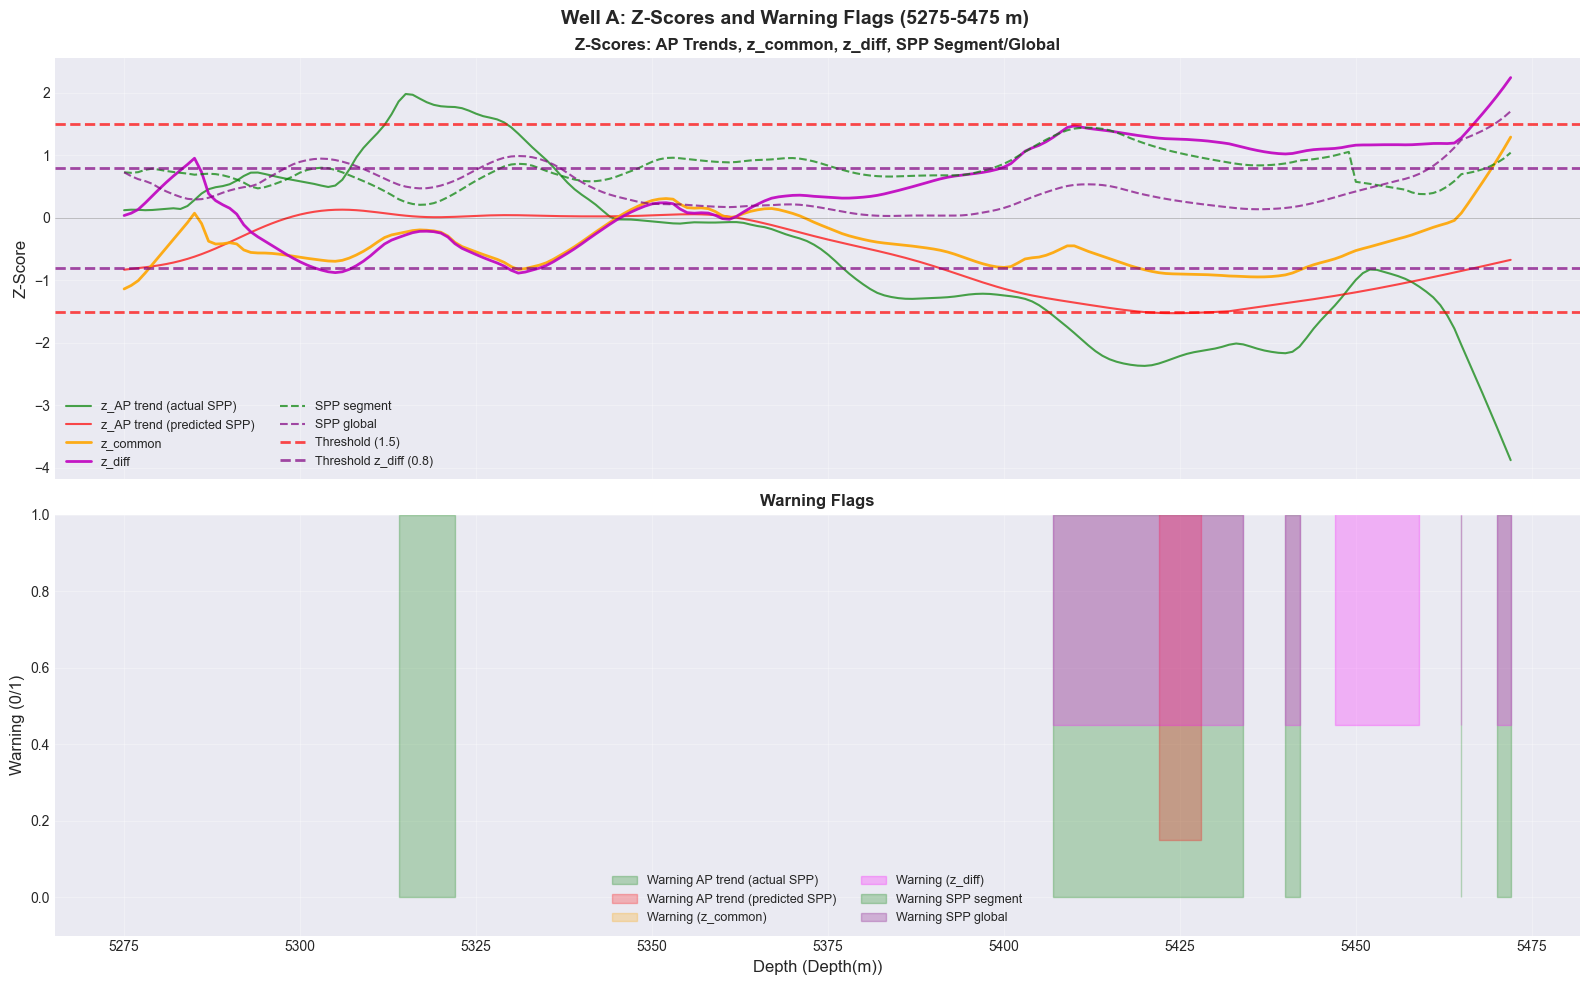


Well C: 7100-7400m
Saved: ..\figures\residuals_n_warnings\zoomed_interval_well_C_7100_7400.pdf


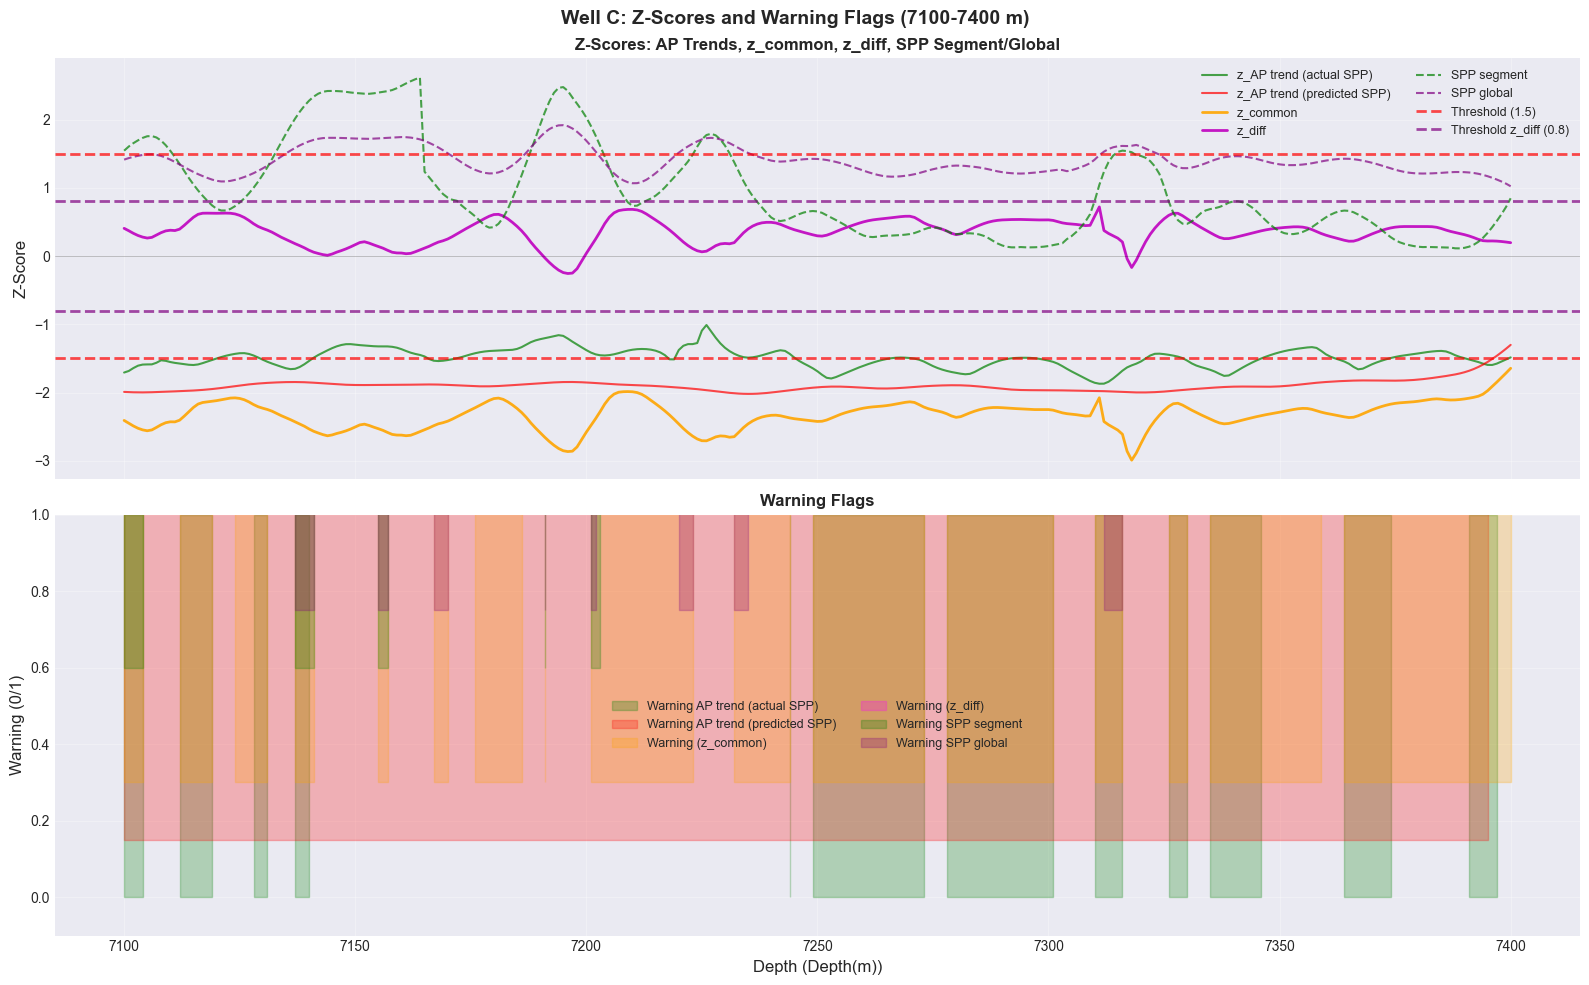


Well C: 7950-8250m
Saved: ..\figures\residuals_n_warnings\zoomed_interval_well_C_7950_8250.pdf


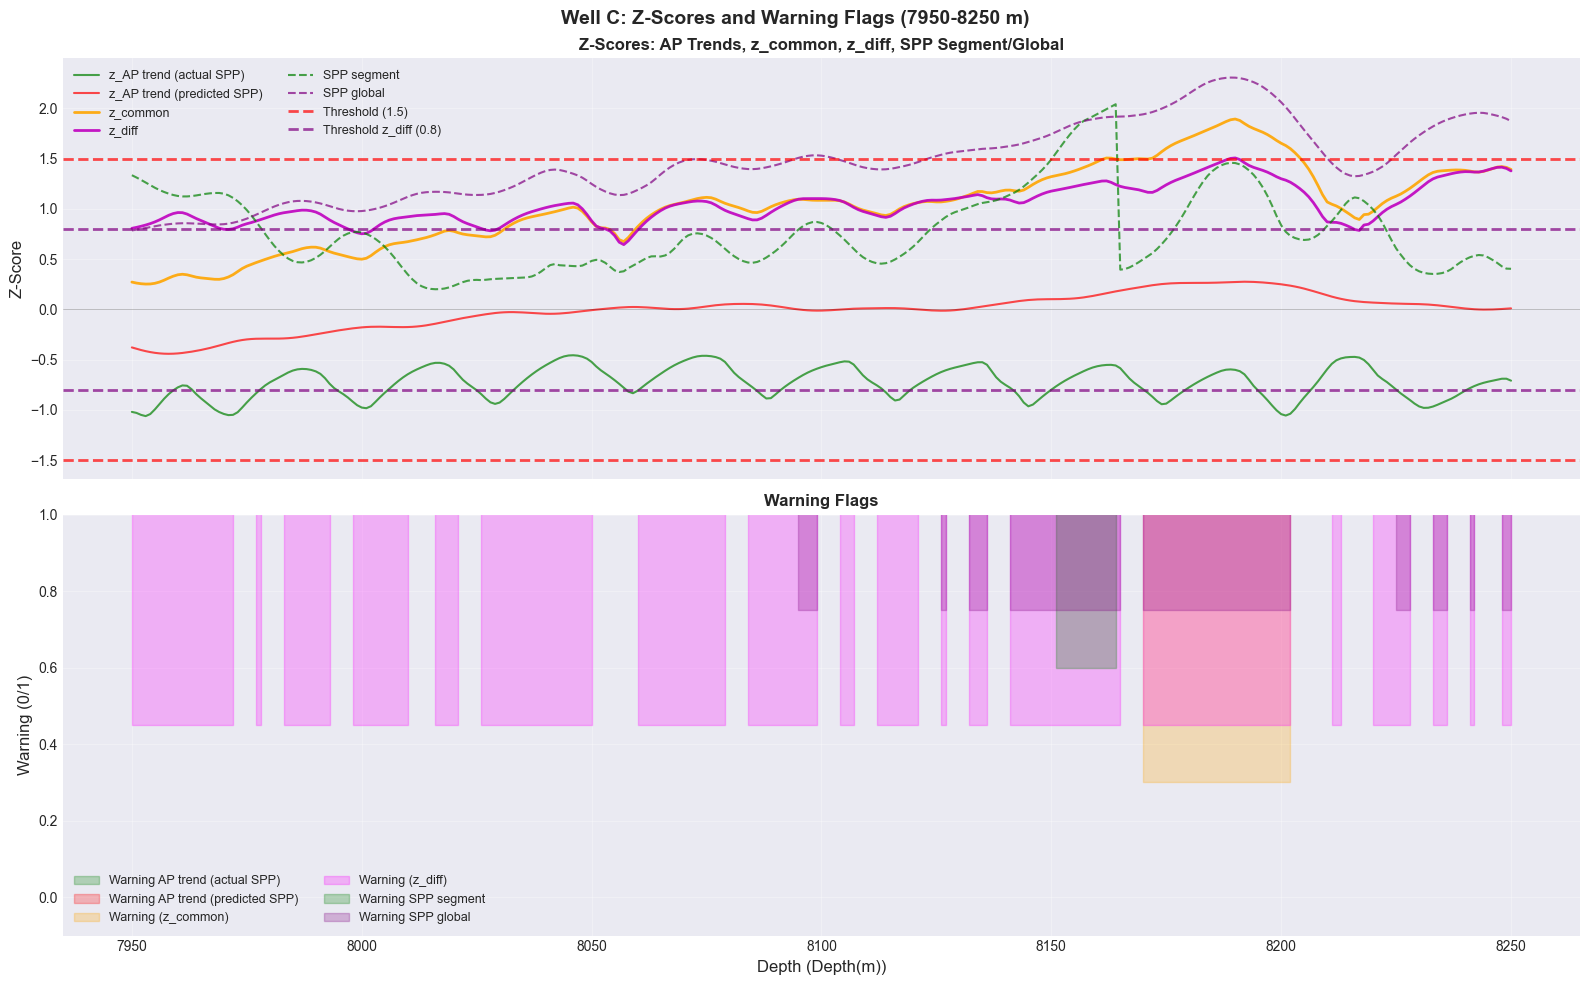


Well D: 3920-4220m
Saved: ..\figures\residuals_n_warnings\zoomed_interval_well_D_3920_4220.pdf


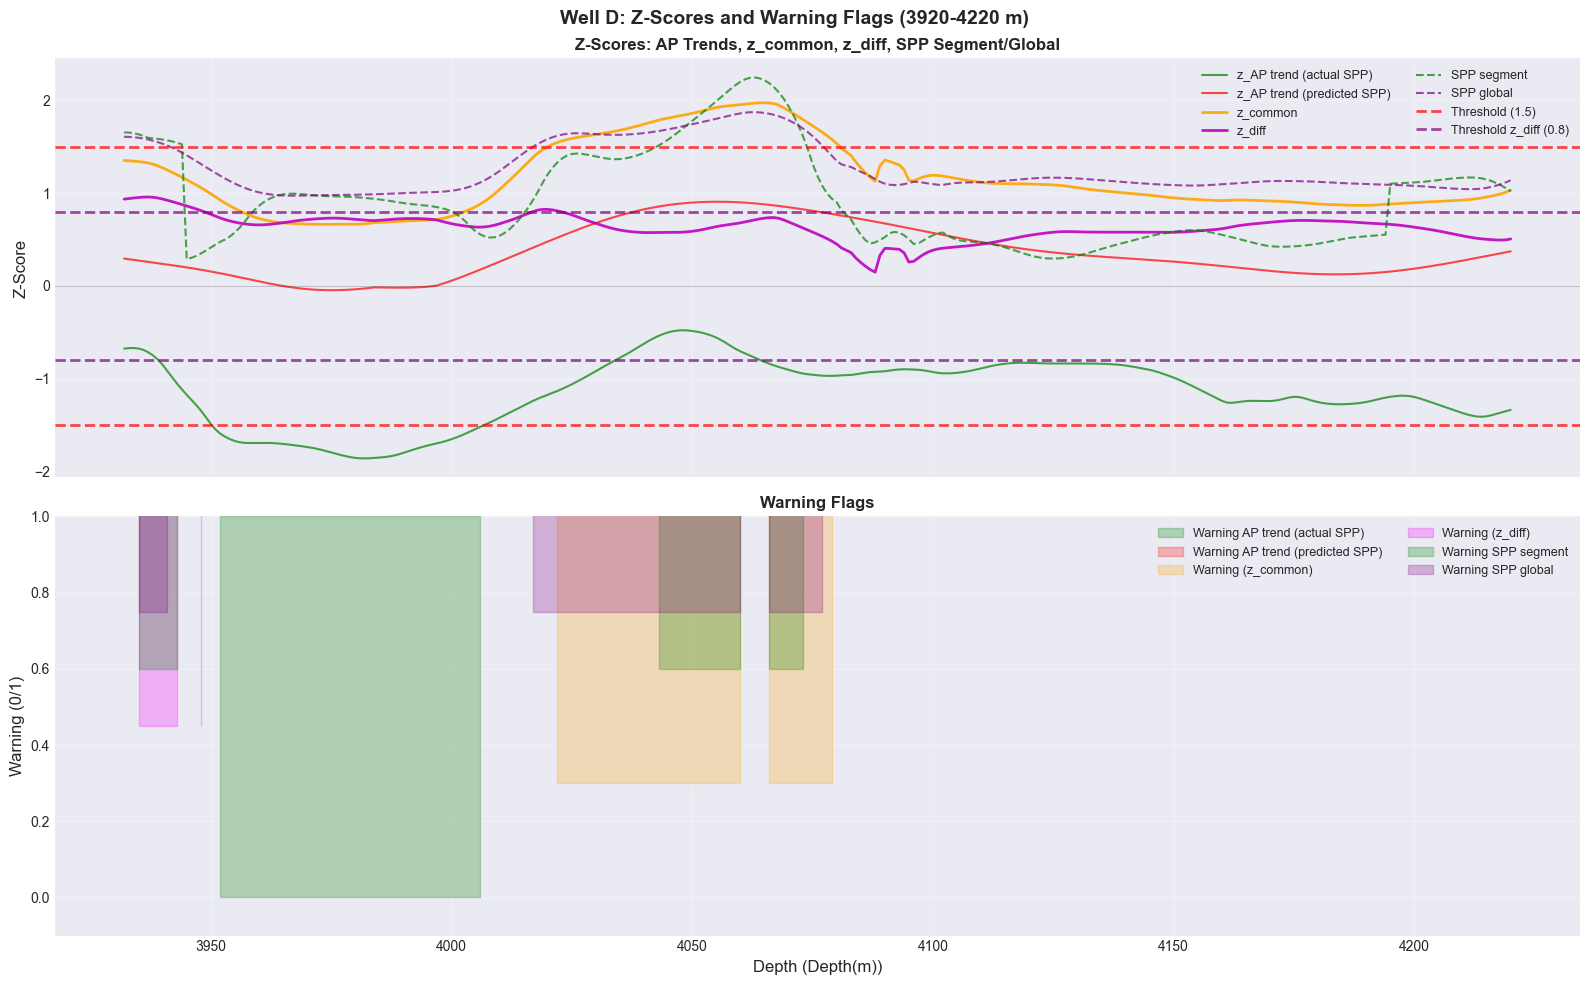


Well D: 4550-4850m
Saved: ..\figures\residuals_n_warnings\zoomed_interval_well_D_4550_4850.pdf


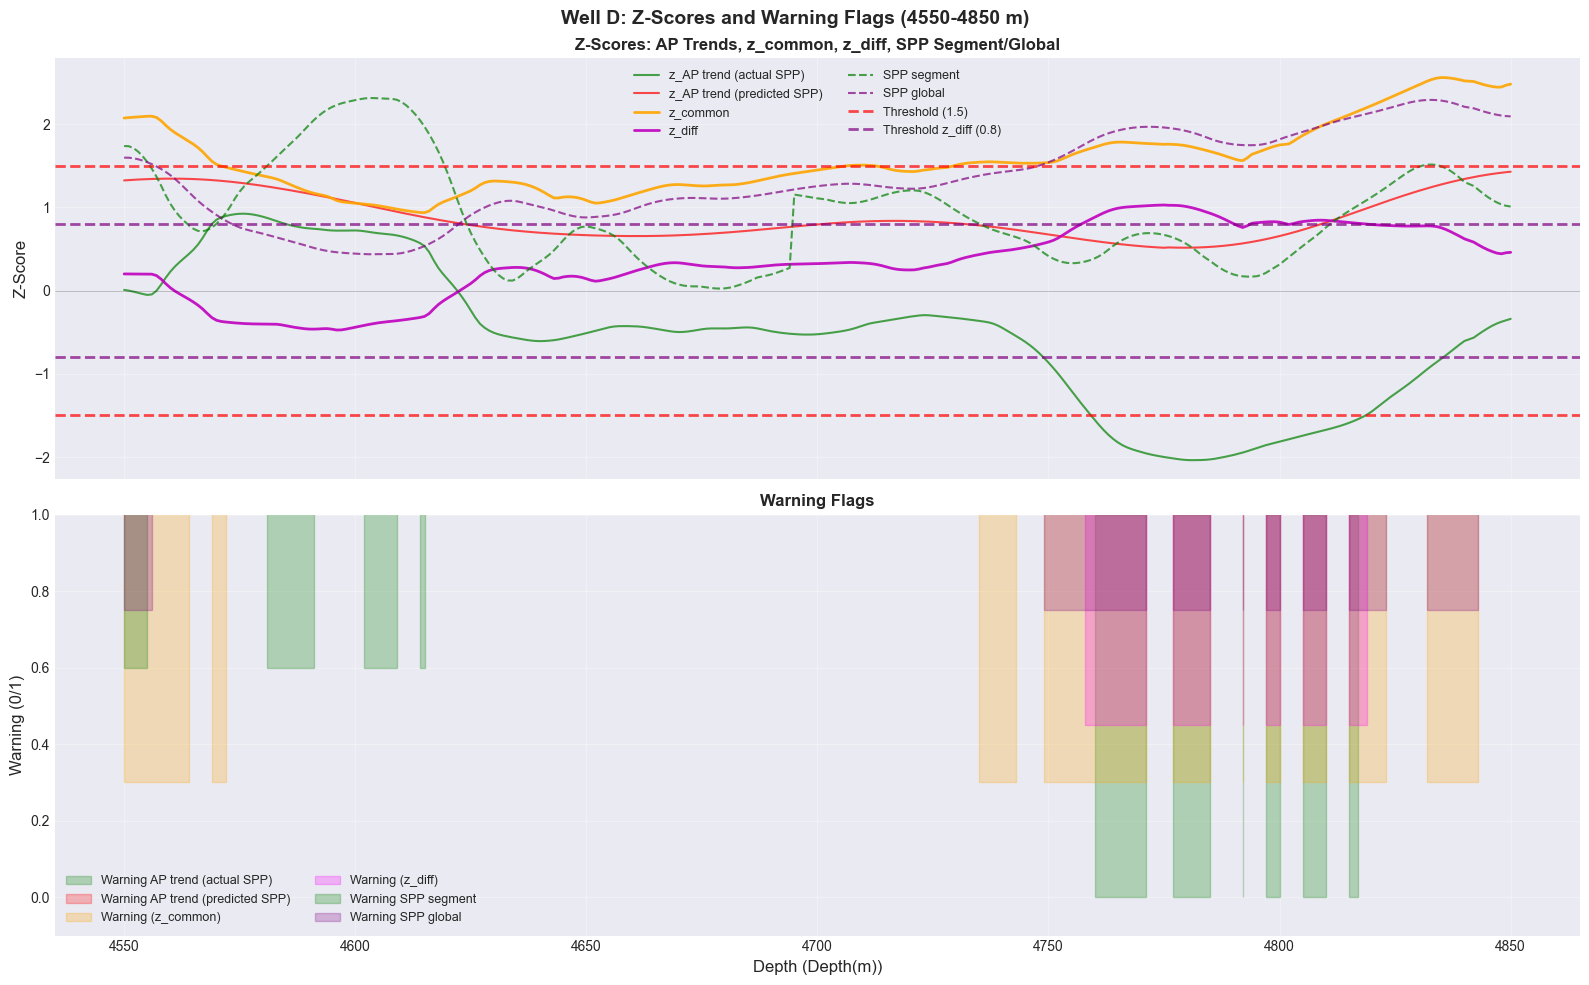


Well D: 5800-6100m
Saved: ..\figures\residuals_n_warnings\zoomed_interval_well_D_5800_6100.pdf


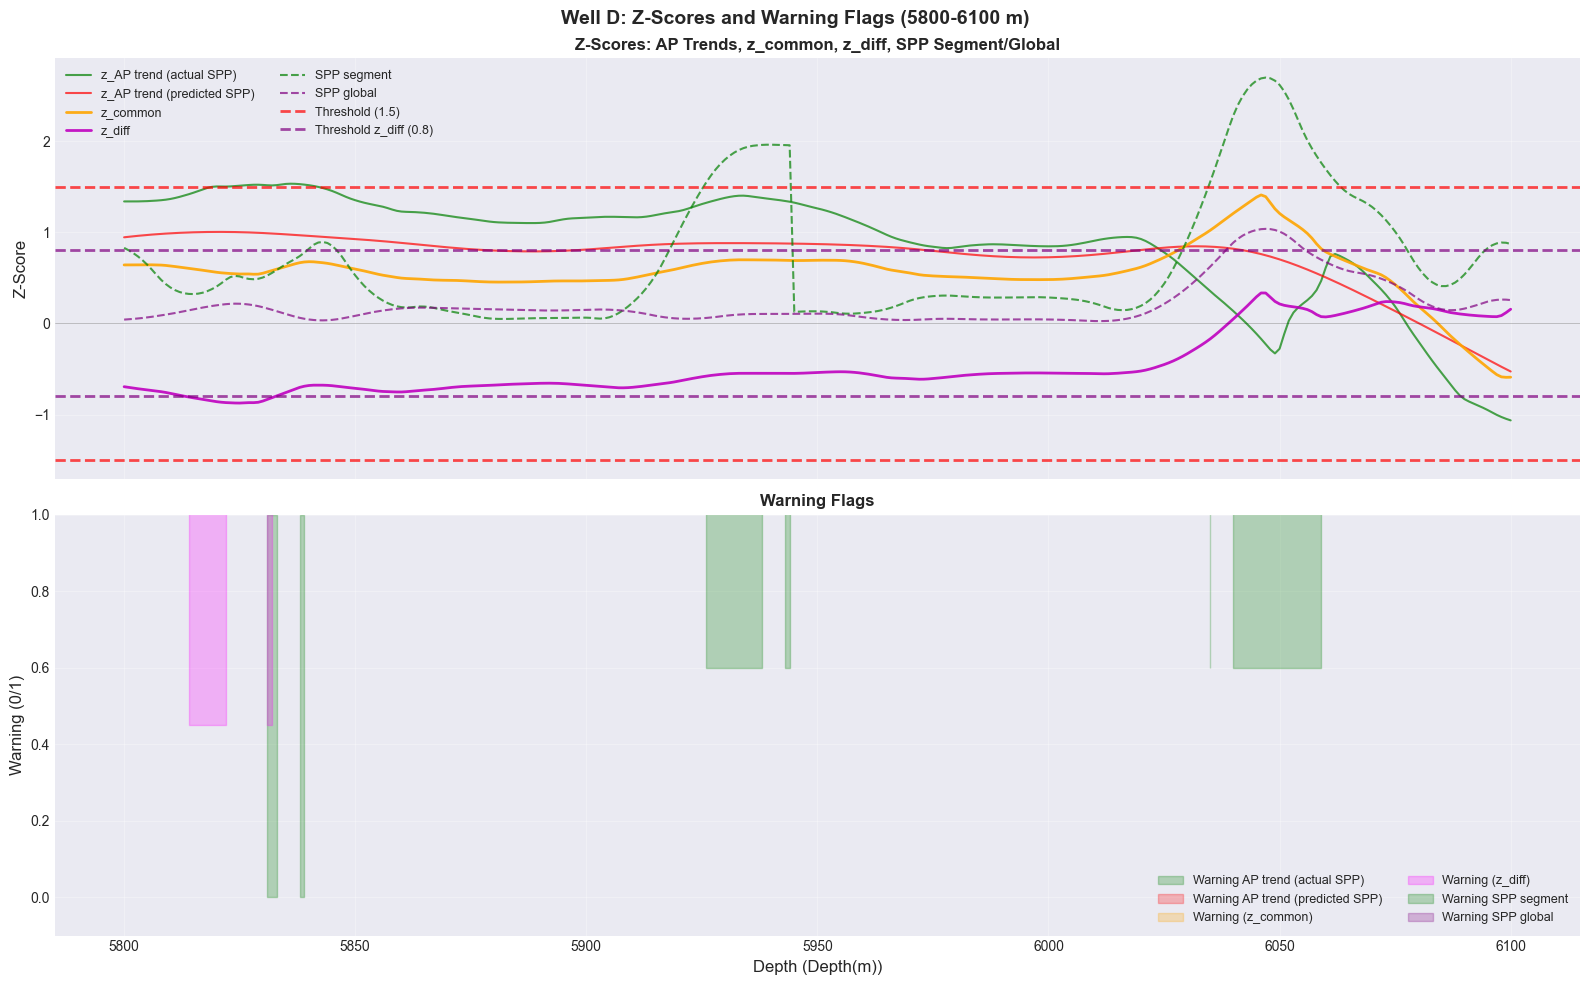


Well D: 6500-6800m
Saved: ..\figures\residuals_n_warnings\zoomed_interval_well_D_6500_6800.pdf


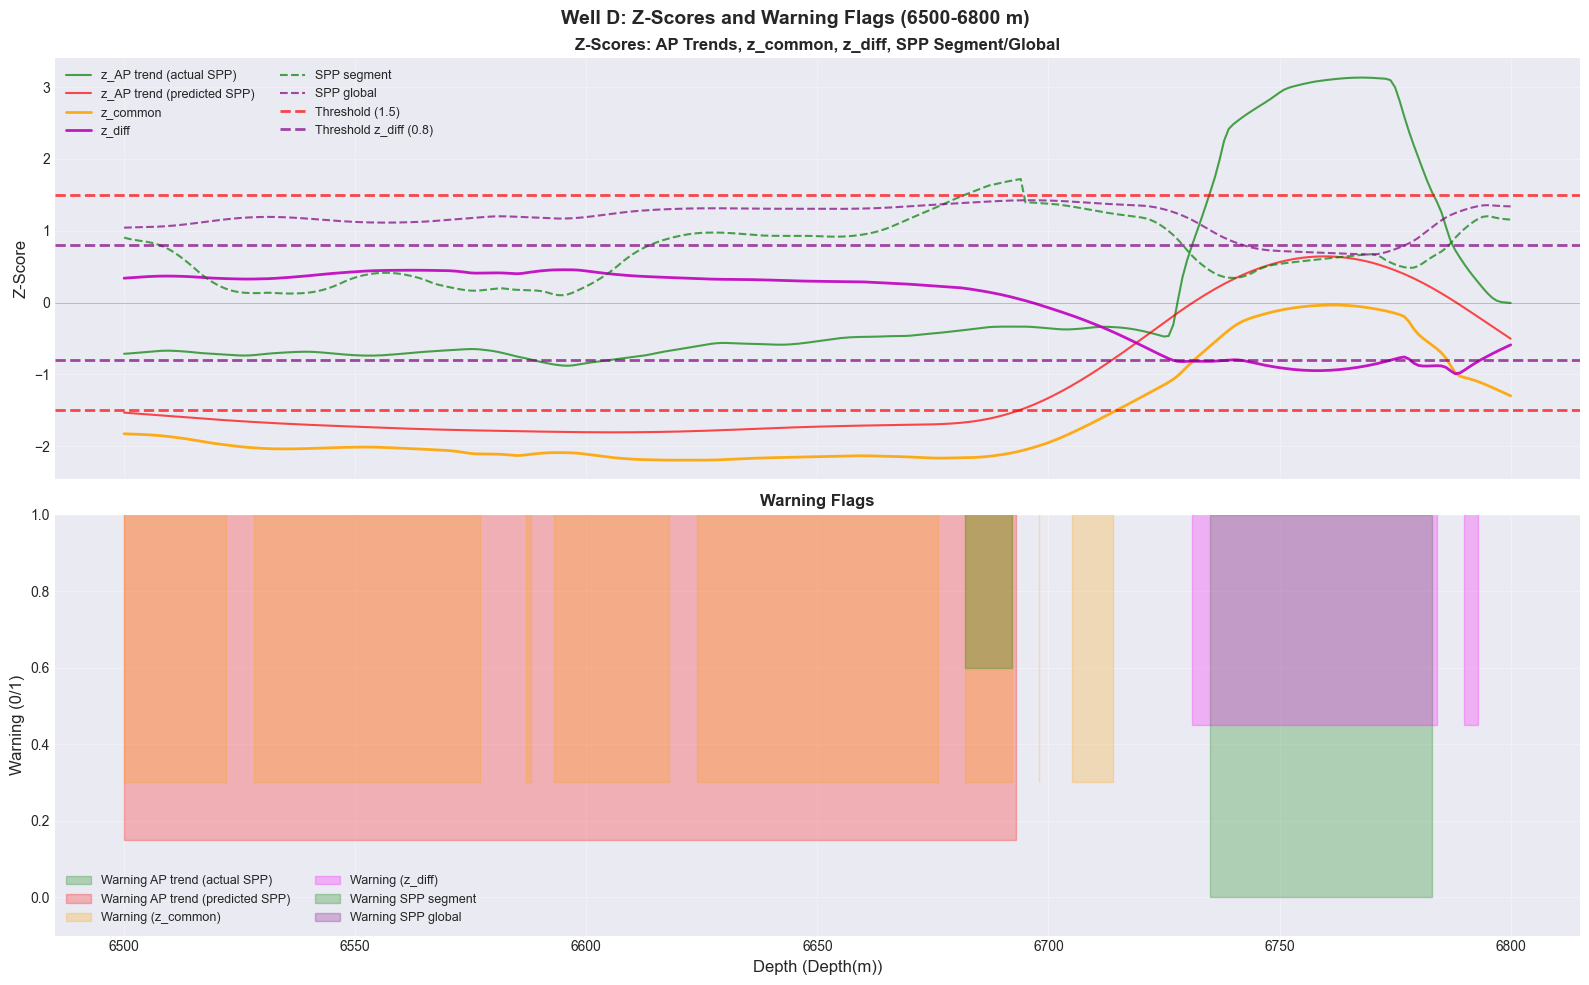


All zoomed-in plots generated and saved.


In [477]:
# ============================================================================
# ZOOMED-IN PLOTS: Combined Z-Scores and Warning Flags
# ============================================================================

def plot_zoomed_interval(df_in, well_id, depth_start, depth_end, title_suffix=""):
    """
    Create a 2-panel zoomed-in plot for a specific depth interval:
    - Upper panel: z_AP trends (actual/predicted SPP), z_common, z_diff, SPP segment/global
    - Lower panel: Warning flags for all metrics
    
    Parameters:
    -----------
    df_in : pd.DataFrame
        Input dataframe
    well_id : str
        Well identifier
    depth_start : float
        Start depth for filtering
    depth_end : float
        End depth for filtering
    title_suffix : str, optional
        Additional text for plot title
    """
    well_data = df_in[df_in['well_id'] == well_id].copy()
    well_data = well_data.sort_values(by=DEPTH_COL).reset_index(drop=True)
    
    # Filter depth range
    well_data = well_data[(well_data[DEPTH_COL] >= depth_start) & (well_data[DEPTH_COL] <= depth_end)]
    
    if len(well_data) == 0:
        print(f"No data for well {well_id} in range {depth_start}-{depth_end}m")
        return None
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
    fig.suptitle(f'Well {well_id}: Z-Scores and Warning Flags ({depth_start:.0f}-{depth_end:.0f} m){title_suffix}', 
                 fontsize=14, fontweight='bold')
    
    # ========================================================================
    # Upper Panel: Z-Scores
    # ========================================================================
    ax = axes[0]
    
    # z_AP trends (actual and predicted SPP)
    if "z_AP_lr_trend" in well_data.columns:
        mask_ap_z = well_data["z_AP_lr_trend"].notna()
        if mask_ap_z.sum() > 0:
            ax.plot(well_data.loc[mask_ap_z, DEPTH_COL], well_data.loc[mask_ap_z, "z_AP_lr_trend"],
                   'g-', alpha=0.7, linewidth=1.5, label='z_AP trend (actual SPP)')
    
    if "z_AP_predSPP_trend" in well_data.columns:
        mask_ap_pred_z = well_data["z_AP_predSPP_trend"].notna()
        if mask_ap_pred_z.sum() > 0:
            ax.plot(well_data.loc[mask_ap_pred_z, DEPTH_COL], well_data.loc[mask_ap_pred_z, "z_AP_predSPP_trend"],
                   'r-', alpha=0.7, linewidth=1.5, label='z_AP trend (predicted SPP)')
    
    # z_common and z_diff
    if "z_common" in well_data.columns:
        mask_common = well_data["z_common"].notna()
        if mask_common.sum() > 0:
            ax.plot(well_data.loc[mask_common, DEPTH_COL], well_data.loc[mask_common, "z_common"],
                   'orange', alpha=0.9, linewidth=2, label='z_common')
    
    if "z_diff" in well_data.columns:
        mask_diff = well_data["z_diff"].notna()
        if mask_diff.sum() > 0:
            ax.plot(well_data.loc[mask_diff, DEPTH_COL], well_data.loc[mask_diff, "z_diff"],
                   'm-', alpha=0.9, linewidth=2, label='z_diff')
    
    # SPP segment and global
    if "rolling_abs_z_SPP_lr_trend_seg" in well_data.columns:
        mask_spp_seg = well_data["rolling_abs_z_SPP_lr_trend_seg"].notna()
        if mask_spp_seg.sum() > 0:
            ax.plot(well_data.loc[mask_spp_seg, DEPTH_COL], well_data.loc[mask_spp_seg, "rolling_abs_z_SPP_lr_trend_seg"],
                   'green', alpha=0.7, linewidth=1.5, linestyle='--', label='SPP segment')
    
    if "rolling_abs_z_SPP_lr_trend" in well_data.columns:
        mask_spp_global = well_data["rolling_abs_z_SPP_lr_trend"].notna()
        if mask_spp_global.sum() > 0:
            ax.plot(well_data.loc[mask_spp_global, DEPTH_COL], well_data.loc[mask_spp_global, "rolling_abs_z_SPP_lr_trend"],
                   'purple', alpha=0.7, linewidth=1.5, linestyle='--', label='SPP global')
    
    # Threshold lines
    ax.axhline(THRESHOLD, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Threshold ({THRESHOLD})')
    ax.axhline(0.8, color='purple', linestyle='--', linewidth=2, alpha=0.7, label='Threshold z_diff (0.8)')
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.axhline(-THRESHOLD, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.axhline(-0.8, color='purple', linestyle='--', linewidth=2, alpha=0.7)
    
    ax.set_ylabel('Z-Score', fontsize=12)
    ax.set_title('Z-Scores: AP Trends, z_common, z_diff, SPP Segment/Global', fontsize=12, fontweight='bold')
    ax.legend(loc='best', ncol=2, fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # ========================================================================
    # Lower Panel: Warning Flags
    # ========================================================================
    ax = axes[1]
    
    # Warning flags with offset vertical positions
    y_offsets = [0, 0.15, 0.3, 0.45, 0.6, 0.75]
    colors = ['green', 'red', 'orange', 'magenta', 'green', 'purple']
    alphas = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
    labels = ['Warning AP trend (actual SPP)', 'Warning AP trend (predicted SPP)', 
              'Warning (z_common)', 'Warning (z_diff)', 
              'Warning SPP segment', 'Warning SPP global']
    columns = ['warning_AP_trend', 'warning_AP_predSPP_trend', 
               'warning_common', 'warning_diff',
               'warning_SPP_trend_seg', 'warning_SPP_trend']
    
    for i, (col, label, color, alpha, y_offset) in enumerate(zip(columns, labels, colors, alphas, y_offsets)):
        if col in well_data.columns:
            ax.fill_between(well_data[DEPTH_COL], y_offset, y_offset + well_data[col], 
                           where=well_data[col]==1, 
                           color=color, alpha=alpha, label=label)
    
    ax.set_ylabel('Warning (0/1)', fontsize=12)
    ax.set_xlabel(f'Depth ({DEPTH_COL})', fontsize=12)
    ax.set_ylim(-0.1, 1.0)
    ax.set_title('Warning Flags', fontsize=12, fontweight='bold')
    ax.legend(loc='best', ncol=2, fontsize=9)
    ax.grid(True, alpha=0.3)
    
    fig.tight_layout()
    
    # Save to PDF
    output_dir = Path("../figures/residuals_n_warnings")
    output_dir.mkdir(parents=True, exist_ok=True)
    filename = output_dir / f"zoomed_interval_well_{well_id}_{depth_start:.0f}_{depth_end:.0f}.pdf"
    fig.savefig(filename, format='pdf', bbox_inches='tight')
    print(f"Saved: {filename}")
    
    plt.show()
    return fig

# Generate plots for specified intervals
print("Generating zoomed-in plots for specified intervals...")

# Well A intervals
well_a_intervals = [
    (2500, 2800),
    (2800, 3100),
    (4700, 5000),
    (5275, 5475)
]

for d_start, d_end in well_a_intervals:
    print(f"\nWell A: {d_start}-{d_end}m")
    plot_zoomed_interval(df, 'A', d_start, d_end)

well_c_intervals = [
    (7100, 7400),
    (7950, 8250)
]
for d_start, d_end in well_c_intervals:
    print(f"\nWell C: {d_start}-{d_end}m")
    plot_zoomed_interval(df, 'C', d_start, d_end)

# Well D intervals
well_d_intervals = [
    (3920, 4220),
    (4550, 4850),
    (5800, 6100),
    (6500, 6800)
]

for d_start, d_end in well_d_intervals:
    print(f"\nWell D: {d_start}-{d_end}m")
    plot_zoomed_interval(df, 'D', d_start, d_end)

print("\nAll zoomed-in plots generated and saved.")

In [462]:
# Re-save as CSV files (replacing parquet)
OUTPUT_DIR = Path("../data/processed")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

for ds_key, df_proc in processed_datasets.items():
    # Collect all columns to save (same as before)
    cols_to_save = BASE_COLUMNS.copy()
    
    # Add all warning-related columns for both targets
    for target in TARGETS.keys():
        for col_name in WARNING_COLUMNS[target].values():
            if col_name in df_proc.columns:
                cols_to_save.append(col_name)
    
    # Add any additional columns that might be useful
    additional_cols = ['segment_id', 'is_spike_r_SPP_lr', 'is_spike_r_AP_lr',
                      'r_SPP_lr_clean', 'r_AP_lr_clean',
                      # New z-score variants
                      'z_AP_predSPP_trend', 'rolling_abs_z_AP_predSPP_trend', 'warning_AP_predSPP_trend',
                      'z_common', 'rolling_abs_z_common', 'warning_common',
                      'z_diff', 'rolling_abs_z_diff', 'warning_diff',
                      'r_AP_lr_predSPP', 'r_AP_lr_predSPP_clean', 'r_AP_lr_predSPP_trend_lowess']
    for col in additional_cols:
        if col in df_proc.columns and col not in cols_to_save:
            cols_to_save.append(col)
    
    # Filter to only existing columns
    cols_to_save = [col for col in cols_to_save if col in df_proc.columns]
    
    # Save per well as CSV
    for well_id in sorted(df_proc['well_id'].unique()):
        well_data = df_proc[df_proc['well_id'] == well_id][cols_to_save].copy()
        well_data = well_data.sort_values(DEPTH_COL).reset_index(drop=True)
        
        output_file = OUTPUT_DIR / f"well_{well_id}_warnings_{ds_key}.csv"
        well_data.to_csv(output_file, index=False)
        print(f"Saved Well {well_id} ({ds_key}) as CSV: {len(well_data)} rows, {len(cols_to_save)} columns -> {output_file.name}")
    
    # Also save combined dataset as CSV
    output_file_combined = OUTPUT_DIR / f"all_wells_warnings_{ds_key}.csv"
    df_proc[cols_to_save].to_csv(output_file_combined, index=False)
    print(f"Saved combined dataset ({ds_key}) as CSV: {len(df_proc)} rows, {len(cols_to_save)} columns -> {output_file_combined.name}")

print("\n✓ All warning columns saved as CSV files for each well and combined dataset")


Saved Well A (actual_features) as CSV: 3271 rows, 45 columns -> well_A_warnings_actual_features.csv
Saved Well B (actual_features) as CSV: 689 rows, 45 columns -> well_B_warnings_actual_features.csv
Saved Well C (actual_features) as CSV: 2236 rows, 45 columns -> well_C_warnings_actual_features.csv
Saved Well D (actual_features) as CSV: 5246 rows, 45 columns -> well_D_warnings_actual_features.csv
Saved combined dataset (actual_features) as CSV: 11442 rows, 45 columns -> all_wells_warnings_actual_features.csv

✓ All warning columns saved as CSV files for each well and combined dataset
